# Problem Statement

```
The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.

Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

```

In [2]:
# For dataset
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Missing value treatment
from sklearn.impute import SimpleImputer

# Categorical to numeric
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler 

# Checking accuracy
from sklearn.metrics import r2_score, mean_squared_error
from math import *

# Splitting and tuning
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Model
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

%matplotlib inline

In [3]:
train = pd.read_csv('Train.txt')
print('Shape: ', train.shape)
train.head()

Shape:  (8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
test = pd.read_csv('Test.txt')
print('Shape: ', test.shape)
test.head()

Shape:  (5681, 11)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


### Dropping unwanted features / columns

In [5]:
train.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1, inplace=True)
test.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1, inplace=True)

```
In Item_Fat_Content the data have only two class i.e Low fat & Regular but written sometimes as LF,low fat and reg so i replaced it with Low Fat & Regular, Otherwise the model will consider it has 5 class feature/column.
```

In [6]:
train['Item_Fat_Content'] = np.where(train['Item_Fat_Content'] == 'LF', 'Low Fat', train['Item_Fat_Content'])
train['Item_Fat_Content'] = np.where(train['Item_Fat_Content'] == 'low fat', 'Low Fat', train['Item_Fat_Content'])
train['Item_Fat_Content'] = np.where(train['Item_Fat_Content'] == 'reg', 'Regular', train['Item_Fat_Content'])

test['Item_Fat_Content'] = np.where(test['Item_Fat_Content'] == 'LF', 'Low Fat', test['Item_Fat_Content'])
test['Item_Fat_Content'] = np.where(test['Item_Fat_Content'] == 'low fat', 'Low Fat', test['Item_Fat_Content'])
test['Item_Fat_Content'] = np.where(test['Item_Fat_Content'] == 'reg', 'Regular', test['Item_Fat_Content'])

In [7]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [8]:
train.describe(include='object')

,Item_Fat_Content,Item_Type,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,6113,8523,8523
unique,2,16,3,3,4
top,Low Fat,Fruits and Vegetables,Medium,Tier 3,Supermarket Type1
freq,5517,1232,2793,3350,5577


```
After checking the mean, median & all using describe function, we get to know that Item_Visibility does not seem to have any big values so we dropping that feature
```

In [9]:
del train['Item_Visibility']
del test['Item_Visibility']

In [10]:
train.isnull().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### SimpleImputer for replacing nan or we can use fillna

In [11]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean') 
imputer = imputer.fit(train[['Item_Weight']])
train['Item_Weight'] = imputer.transform(train[['Item_Weight']])
train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0], inplace=True)

# I mostly prefer fillna to fill nan
test['Item_Weight'].fillna(test['Item_Weight'].mean(), inplace=True)
test['Outlet_Size'].fillna(test['Outlet_Size'].mode()[0], inplace=True)

In [12]:
train.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

```
Now by looking histogram we can say that Item_Outlet_Sales are mostly between (0-4000)
```

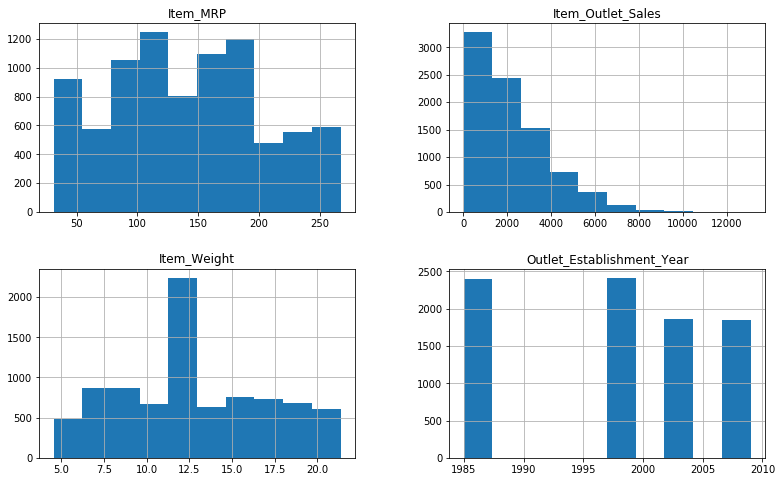

In [13]:
train.hist(figsize=(13,8))
plt.show()

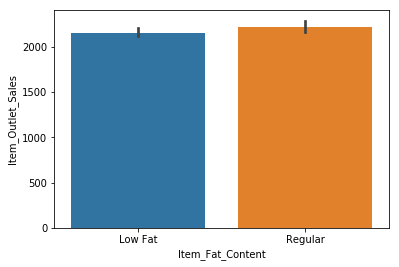

In [14]:
sns.barplot(train['Item_Fat_Content'], train['Item_Outlet_Sales'])
plt.show()

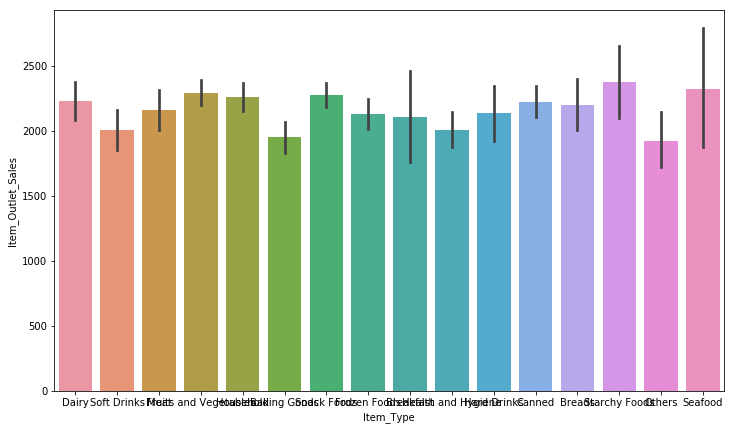

In [15]:
plt.figure(figsize=(12,7))
sns.barplot(train['Item_Type'], train['Item_Outlet_Sales'])
plt.show()

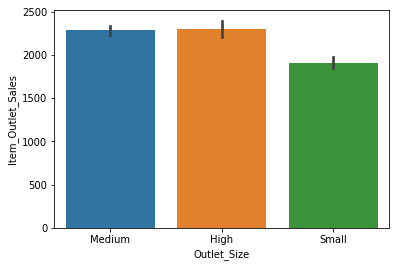

In [16]:
sns.barplot(train['Outlet_Size'], train['Item_Outlet_Sales'])
plt.show()

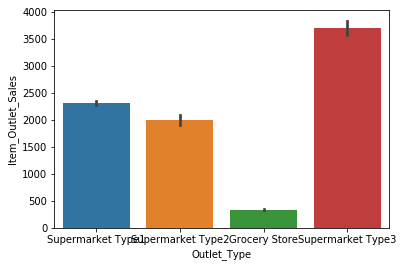

In [17]:
sns.barplot(train['Outlet_Type'], train['Item_Outlet_Sales'])
plt.show()

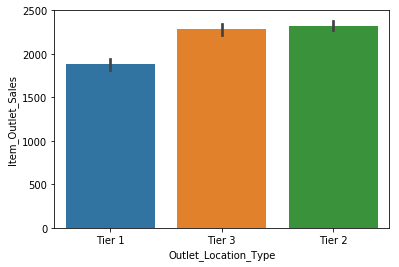

In [18]:
sns.barplot(train['Outlet_Location_Type'], train['Item_Outlet_Sales'])
plt.show()

In [19]:
le = LabelEncoder()
he = OneHotEncoder(categorical_features=[0])

In [20]:
train['Item_Fat_Content'] = le.fit_transform(train['Item_Fat_Content'])
train['Outlet_Size'] = le.fit_transform(train['Outlet_Size'])
train['Outlet_Location_Type'] = le.fit_transform(train['Outlet_Location_Type'])

test['Item_Fat_Content'] = le.fit_transform(test['Item_Fat_Content'])
test['Outlet_Size'] = le.fit_transform(test['Outlet_Size'])
test['Outlet_Location_Type'] = le.fit_transform(test['Outlet_Location_Type'])

In [21]:
train_col = train.select_dtypes('object').columns
test_col = test.select_dtypes('object').columns

In [22]:
train = pd.get_dummies(train, columns=train_col, drop_first=True)
test = pd.get_dummies(test, columns=test_col, drop_first=True)
train.head()

,Item_Weight,Item_Fat_Content,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Outlet_Sales,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0,249.8092,1999,1,0,3735.1380,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,5.92,1,48.2692,2009,1,2,443.4228,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,17.50,0,141.6180,1999,1,0,2097.2700,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,19.20,1,182.0950,1998,1,2,732.3800,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8.93,0,53.8614,1987,0,2,994.7052,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [23]:
test.head()

,Item_Weight,Item_Fat_Content,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,20.750000,0,107.8622,1999,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,8.300000,1,87.3198,2007,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,14.600000,0,241.7538,1998,1,2,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,7.315000,0,155.0340,2007,1,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,12.695633,1,234.2300,1985,1,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


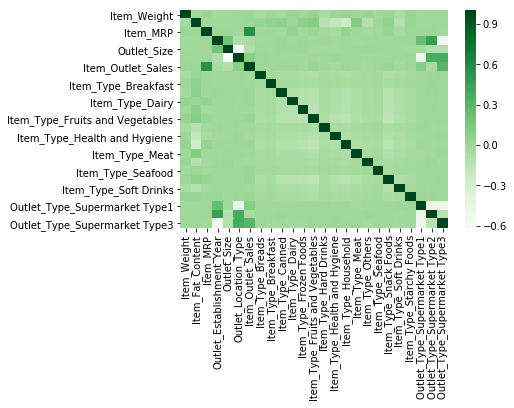

In [24]:
corr = train.corr()
sns.heatmap(corr, cmap='Greens')
plt.show()

In [25]:
X = train.drop('Item_Outlet_Sales', axis=1)
y = train['Item_Outlet_Sales']

### Splitting the train data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Support Vector Machine

In [27]:
svm = SVR()

In [28]:
svm.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
y_pred = svm.predict(X_test)

In [30]:
r2_score(y_test, y_pred)

-0.018863955216330996

In [31]:
svm.score(X_train, y_train)

-0.04077949399970526

In [32]:
svm.score(X_test, y_test)

-0.018863955216330996

# RandomForest

In [33]:
rf = RandomForestRegressor()

In [34]:
rf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [35]:
y_pred = rf.predict(X_test)

In [36]:
r2_score(y_test, y_pred)

0.5077374285666417

In [37]:
rf.score(X_train, y_train)

0.9134798122975321

# CatBoost

In [38]:
cb = CatBoostRegressor()

In [39]:
cb.fit(X_train, y_train)

0:	learn: 1691.8744252	total: 99.5ms	remaining: 1m 39s
1:	learn: 1663.5410629	total: 132ms	remaining: 1m 5s
2:	learn: 1636.9808002	total: 163ms	remaining: 54.1s
3:	learn: 1614.8322240	total: 188ms	remaining: 46.8s
4:	learn: 1592.0662541	total: 219ms	remaining: 43.6s
5:	learn: 1569.8451567	total: 251ms	remaining: 41.6s
6:	learn: 1548.5515076	total: 282ms	remaining: 40s
7:	learn: 1527.5865921	total: 316ms	remaining: 39.1s
8:	learn: 1509.6024072	total: 357ms	remaining: 39.3s
9:	learn: 1489.3954017	total: 390ms	remaining: 38.6s
10:	learn: 1470.3177256	total: 423ms	remaining: 38s
11:	learn: 1452.5220403	total: 454ms	remaining: 37.4s
12:	learn: 1436.0517778	total: 485ms	remaining: 36.8s
13:	learn: 1419.7690363	total: 520ms	remaining: 36.6s
14:	learn: 1404.3655499	total: 562ms	remaining: 36.9s
15:	learn: 1389.0286453	total: 593ms	remaining: 36.4s
16:	learn: 1375.2882547	total: 623ms	remaining: 36s
17:	learn: 1361.4840928	total: 653ms	remaining: 35.6s
18:	learn: 1348.4222138	total: 684ms	remai

153:	learn: 1072.4344226	total: 5.34s	remaining: 29.4s
154:	learn: 1072.3208071	total: 5.38s	remaining: 29.3s
155:	learn: 1072.0950193	total: 5.41s	remaining: 29.3s
156:	learn: 1071.8316455	total: 5.45s	remaining: 29.3s
157:	learn: 1071.6867459	total: 5.48s	remaining: 29.2s
158:	learn: 1071.5909863	total: 5.51s	remaining: 29.2s
159:	learn: 1071.4081279	total: 5.54s	remaining: 29.1s
160:	learn: 1071.1060185	total: 5.58s	remaining: 29.1s
161:	learn: 1071.0150575	total: 5.61s	remaining: 29s
162:	learn: 1070.8694036	total: 5.64s	remaining: 29s
163:	learn: 1070.7189120	total: 5.67s	remaining: 28.9s
164:	learn: 1070.5583445	total: 5.71s	remaining: 28.9s
165:	learn: 1070.4464019	total: 5.74s	remaining: 28.8s
166:	learn: 1070.2188862	total: 5.77s	remaining: 28.8s
167:	learn: 1070.1240268	total: 5.81s	remaining: 28.8s
168:	learn: 1070.0327018	total: 5.84s	remaining: 28.7s
169:	learn: 1069.9602352	total: 5.87s	remaining: 28.7s
170:	learn: 1069.7995021	total: 5.9s	remaining: 28.6s
171:	learn: 106

303:	learn: 1055.3724712	total: 10.5s	remaining: 24.1s
304:	learn: 1055.1687552	total: 10.6s	remaining: 24.1s
305:	learn: 1055.0987774	total: 10.6s	remaining: 24.1s
306:	learn: 1055.0251064	total: 10.6s	remaining: 24s
307:	learn: 1054.9319514	total: 10.7s	remaining: 24s
308:	learn: 1054.8690751	total: 10.7s	remaining: 23.9s
309:	learn: 1054.7938940	total: 10.7s	remaining: 23.9s
310:	learn: 1054.6465018	total: 10.8s	remaining: 23.8s
311:	learn: 1054.6229520	total: 10.8s	remaining: 23.8s
312:	learn: 1054.5423737	total: 10.8s	remaining: 23.8s
313:	learn: 1054.4629451	total: 10.9s	remaining: 23.7s
314:	learn: 1054.3900433	total: 10.9s	remaining: 23.7s
315:	learn: 1054.2814688	total: 10.9s	remaining: 23.6s
316:	learn: 1054.2010297	total: 11s	remaining: 23.6s
317:	learn: 1054.1613031	total: 11s	remaining: 23.6s
318:	learn: 1054.0666123	total: 11s	remaining: 23.5s
319:	learn: 1054.0021170	total: 11.1s	remaining: 23.5s
320:	learn: 1053.9222867	total: 11.1s	remaining: 23.4s
321:	learn: 1053.853

455:	learn: 1046.1055236	total: 16.1s	remaining: 19.2s
456:	learn: 1046.0142027	total: 16.2s	remaining: 19.2s
457:	learn: 1045.9234083	total: 16.2s	remaining: 19.2s
458:	learn: 1045.8789515	total: 16.3s	remaining: 19.2s
459:	learn: 1045.8179257	total: 16.3s	remaining: 19.2s
460:	learn: 1045.6712703	total: 16.4s	remaining: 19.2s
461:	learn: 1045.5627327	total: 16.4s	remaining: 19.1s
462:	learn: 1045.5312518	total: 16.5s	remaining: 19.1s
463:	learn: 1045.4609267	total: 16.5s	remaining: 19.1s
464:	learn: 1045.3653099	total: 16.6s	remaining: 19s
465:	learn: 1045.3441242	total: 16.6s	remaining: 19s
466:	learn: 1045.3002907	total: 16.7s	remaining: 19s
467:	learn: 1045.2934306	total: 16.7s	remaining: 19s
468:	learn: 1045.2280874	total: 16.7s	remaining: 19s
469:	learn: 1045.1424697	total: 16.8s	remaining: 18.9s
470:	learn: 1045.1168560	total: 16.8s	remaining: 18.9s
471:	learn: 1045.0787451	total: 16.9s	remaining: 18.9s
472:	learn: 1045.0572642	total: 16.9s	remaining: 18.8s
473:	learn: 1044.901

608:	learn: 1037.9199558	total: 21.8s	remaining: 14s
609:	learn: 1037.8980905	total: 21.8s	remaining: 13.9s
610:	learn: 1037.8331093	total: 21.8s	remaining: 13.9s
611:	learn: 1037.8009470	total: 21.9s	remaining: 13.9s
612:	learn: 1037.7729670	total: 21.9s	remaining: 13.8s
613:	learn: 1037.7582517	total: 21.9s	remaining: 13.8s
614:	learn: 1037.6810142	total: 22s	remaining: 13.8s
615:	learn: 1037.6668373	total: 22s	remaining: 13.7s
616:	learn: 1037.6414723	total: 22s	remaining: 13.7s
617:	learn: 1037.4783651	total: 22.1s	remaining: 13.6s
618:	learn: 1037.4356242	total: 22.1s	remaining: 13.6s
619:	learn: 1037.3737438	total: 22.1s	remaining: 13.6s
620:	learn: 1037.2712400	total: 22.2s	remaining: 13.5s
621:	learn: 1037.1786444	total: 22.2s	remaining: 13.5s
622:	learn: 1037.1351712	total: 22.2s	remaining: 13.5s
623:	learn: 1037.0830676	total: 22.3s	remaining: 13.4s
624:	learn: 1037.0515692	total: 22.3s	remaining: 13.4s
625:	learn: 1037.0232295	total: 22.3s	remaining: 13.3s
626:	learn: 1036.9

764:	learn: 1030.3518168	total: 27.8s	remaining: 8.54s
765:	learn: 1030.2883542	total: 27.8s	remaining: 8.5s
766:	learn: 1030.1994336	total: 27.9s	remaining: 8.46s
767:	learn: 1030.1902410	total: 27.9s	remaining: 8.43s
768:	learn: 1030.1627073	total: 27.9s	remaining: 8.39s
769:	learn: 1030.1231895	total: 28s	remaining: 8.35s
770:	learn: 1030.0871706	total: 28s	remaining: 8.31s
771:	learn: 1030.0711124	total: 28s	remaining: 8.28s
772:	learn: 1030.0467368	total: 28.1s	remaining: 8.24s
773:	learn: 1030.0193693	total: 28.1s	remaining: 8.2s
774:	learn: 1029.9751721	total: 28.1s	remaining: 8.16s
775:	learn: 1029.9479968	total: 28.2s	remaining: 8.13s
776:	learn: 1029.8548919	total: 28.2s	remaining: 8.09s
777:	learn: 1029.8439554	total: 28.2s	remaining: 8.05s
778:	learn: 1029.8106738	total: 28.3s	remaining: 8.01s
779:	learn: 1029.7767260	total: 28.3s	remaining: 7.98s
780:	learn: 1029.7485037	total: 28.3s	remaining: 7.95s
781:	learn: 1029.7074625	total: 28.4s	remaining: 7.91s
782:	learn: 1029.6

915:	learn: 1023.1792356	total: 32.8s	remaining: 3.01s
916:	learn: 1023.0407761	total: 32.9s	remaining: 2.97s
917:	learn: 1022.9949794	total: 32.9s	remaining: 2.94s
918:	learn: 1022.9790430	total: 32.9s	remaining: 2.9s
919:	learn: 1022.9298803	total: 33s	remaining: 2.87s
920:	learn: 1022.9040447	total: 33s	remaining: 2.83s
921:	learn: 1022.8592767	total: 33s	remaining: 2.79s
922:	learn: 1022.8399063	total: 33.1s	remaining: 2.76s
923:	learn: 1022.8007255	total: 33.2s	remaining: 2.73s
924:	learn: 1022.7367465	total: 33.2s	remaining: 2.69s
925:	learn: 1022.6727076	total: 33.3s	remaining: 2.66s
926:	learn: 1022.6149180	total: 33.3s	remaining: 2.62s
927:	learn: 1022.5466177	total: 33.4s	remaining: 2.59s
928:	learn: 1022.5334008	total: 33.4s	remaining: 2.56s
929:	learn: 1022.4685884	total: 33.5s	remaining: 2.52s
930:	learn: 1022.4158540	total: 33.5s	remaining: 2.49s
931:	learn: 1022.3813168	total: 33.6s	remaining: 2.45s
932:	learn: 1022.3105983	total: 33.7s	remaining: 2.42s
933:	learn: 1022.

In [40]:
y_pred = cb.predict(X_test)

In [41]:
r2_score(y_test, y_pred)

0.6111989205705002

In [42]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

1027.9833149218186

In [43]:
params = {'learning_rate': [0.007, 0.005, 0.004]}
random = RandomizedSearchCV(cb, param_distributions=params, cv=5, n_iter=10)

In [44]:
random.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0:	learn: 1719.8771296	total: 35.9ms	remaining: 35.8s
1:	learn: 1713.2317923	total: 80ms	remaining: 39.9s
2:	learn: 1706.6311968	total: 118ms	remaining: 39.1s
3:	learn: 1700.3846361	total: 160ms	remaining: 39.9s
4:	learn: 1693.7213353	total: 198ms	remaining: 39.4s
5:	learn: 1688.1330538	total: 232ms	remaining: 38.4s
6:	learn: 1682.5384649	total: 270ms	remaining: 38.3s
7:	learn: 1676.5704606	total: 313ms	remaining: 38.8s
8:	learn: 1670.6809569	total: 347ms	remaining: 38.2s
9:	learn: 1664.6698152	total: 383ms	remaining: 38s
10:	learn: 1658.7447885	total: 418ms	remaining: 37.5s
11:	learn: 1654.3995446	total: 447ms	remaining: 36.8s
12:	learn: 1648.5768313	total: 483ms	remaining: 36.7s
13:	learn: 1642.6057256	total: 521ms	remaining: 36.7s
14:	learn: 1636.8029153	total: 554ms	remaining: 36.4s
15:	learn: 1631.9853831	total: 578ms	remaining: 35.6s
16:	learn: 1626.2404579	total: 611ms	remaining: 35.3s
17:	learn: 1621.1712417	total: 658ms	remaining: 35.9s
18:	learn: 1615.4195505	total: 693ms	rem

154:	learn: 1206.8924048	total: 5.82s	remaining: 31.7s
155:	learn: 1205.4433532	total: 5.85s	remaining: 31.7s
156:	learn: 1204.0041443	total: 5.88s	remaining: 31.6s
157:	learn: 1202.7290432	total: 5.92s	remaining: 31.5s
158:	learn: 1201.3992272	total: 5.95s	remaining: 31.5s
159:	learn: 1200.4182337	total: 5.98s	remaining: 31.4s
160:	learn: 1199.1985326	total: 6.02s	remaining: 31.4s
161:	learn: 1198.1658204	total: 6.04s	remaining: 31.2s
162:	learn: 1197.0330355	total: 6.07s	remaining: 31.2s
163:	learn: 1195.7429508	total: 6.09s	remaining: 31.1s
164:	learn: 1194.5480005	total: 6.12s	remaining: 31s
165:	learn: 1193.2035869	total: 6.15s	remaining: 30.9s
166:	learn: 1192.0930341	total: 6.17s	remaining: 30.8s
167:	learn: 1190.8478894	total: 6.21s	remaining: 30.8s
168:	learn: 1189.6717971	total: 6.24s	remaining: 30.7s
169:	learn: 1188.5471582	total: 6.26s	remaining: 30.6s
170:	learn: 1187.2647152	total: 6.29s	remaining: 30.5s
171:	learn: 1186.2252167	total: 6.32s	remaining: 30.4s
172:	learn: 

306:	learn: 1107.0834020	total: 11.2s	remaining: 25.4s
307:	learn: 1106.8056145	total: 11.3s	remaining: 25.3s
308:	learn: 1106.5675060	total: 11.3s	remaining: 25.4s
309:	learn: 1106.2819409	total: 11.4s	remaining: 25.4s
310:	learn: 1105.9728611	total: 11.4s	remaining: 25.4s
311:	learn: 1105.6967802	total: 11.5s	remaining: 25.4s
312:	learn: 1105.4772844	total: 11.6s	remaining: 25.4s
313:	learn: 1105.2161850	total: 11.6s	remaining: 25.3s
314:	learn: 1104.9662474	total: 11.6s	remaining: 25.3s
315:	learn: 1104.7295476	total: 11.7s	remaining: 25.3s
316:	learn: 1104.4818634	total: 11.7s	remaining: 25.2s
317:	learn: 1104.2850919	total: 11.7s	remaining: 25.2s
318:	learn: 1104.0284263	total: 11.8s	remaining: 25.1s
319:	learn: 1103.8061114	total: 11.8s	remaining: 25.1s
320:	learn: 1103.5933165	total: 11.9s	remaining: 25.1s
321:	learn: 1103.3875848	total: 11.9s	remaining: 25.1s
322:	learn: 1103.1128826	total: 12s	remaining: 25.1s
323:	learn: 1102.9501871	total: 12s	remaining: 25s
324:	learn: 1102

459:	learn: 1084.4487452	total: 16.5s	remaining: 19.4s
460:	learn: 1084.3258946	total: 16.6s	remaining: 19.4s
461:	learn: 1084.2462303	total: 16.7s	remaining: 19.4s
462:	learn: 1084.1438947	total: 16.8s	remaining: 19.5s
463:	learn: 1084.0269729	total: 16.8s	remaining: 19.4s
464:	learn: 1083.9502822	total: 16.8s	remaining: 19.4s
465:	learn: 1083.8473227	total: 16.9s	remaining: 19.3s
466:	learn: 1083.7368744	total: 16.9s	remaining: 19.3s
467:	learn: 1083.6571593	total: 16.9s	remaining: 19.3s
468:	learn: 1083.5729581	total: 17s	remaining: 19.2s
469:	learn: 1083.4586330	total: 17s	remaining: 19.2s
470:	learn: 1083.3789487	total: 17s	remaining: 19.1s
471:	learn: 1083.3013976	total: 17.1s	remaining: 19.1s
472:	learn: 1083.2137006	total: 17.1s	remaining: 19.1s
473:	learn: 1083.1356011	total: 17.1s	remaining: 19s
474:	learn: 1083.0501270	total: 17.2s	remaining: 19s
475:	learn: 1082.9897800	total: 17.2s	remaining: 18.9s
476:	learn: 1082.8988483	total: 17.2s	remaining: 18.9s
477:	learn: 1082.846

612:	learn: 1074.0720700	total: 22.2s	remaining: 14s
613:	learn: 1074.0242418	total: 22.2s	remaining: 14s
614:	learn: 1073.9891206	total: 22.3s	remaining: 13.9s
615:	learn: 1073.9300981	total: 22.3s	remaining: 13.9s
616:	learn: 1073.8801742	total: 22.3s	remaining: 13.8s
617:	learn: 1073.8170082	total: 22.3s	remaining: 13.8s
618:	learn: 1073.7894051	total: 22.4s	remaining: 13.8s
619:	learn: 1073.7447917	total: 22.4s	remaining: 13.7s
620:	learn: 1073.6825207	total: 22.4s	remaining: 13.7s
621:	learn: 1073.6368124	total: 22.5s	remaining: 13.6s
622:	learn: 1073.5887068	total: 22.5s	remaining: 13.6s
623:	learn: 1073.5633573	total: 22.5s	remaining: 13.6s
624:	learn: 1073.5267723	total: 22.6s	remaining: 13.5s
625:	learn: 1073.4809087	total: 22.6s	remaining: 13.5s
626:	learn: 1073.4261450	total: 22.6s	remaining: 13.5s
627:	learn: 1073.3709802	total: 22.6s	remaining: 13.4s
628:	learn: 1073.3498199	total: 22.7s	remaining: 13.4s
629:	learn: 1073.3187424	total: 22.7s	remaining: 13.3s
630:	learn: 10

764:	learn: 1066.6174338	total: 27.2s	remaining: 8.34s
765:	learn: 1066.5595284	total: 27.2s	remaining: 8.3s
766:	learn: 1066.5223977	total: 27.2s	remaining: 8.27s
767:	learn: 1066.4402271	total: 27.2s	remaining: 8.23s
768:	learn: 1066.4104896	total: 27.3s	remaining: 8.19s
769:	learn: 1066.3580594	total: 27.3s	remaining: 8.16s
770:	learn: 1066.3156656	total: 27.3s	remaining: 8.12s
771:	learn: 1066.2835896	total: 27.4s	remaining: 8.08s
772:	learn: 1066.2434443	total: 27.4s	remaining: 8.04s
773:	learn: 1066.2043731	total: 27.4s	remaining: 8.01s
774:	learn: 1066.1791265	total: 27.5s	remaining: 7.97s
775:	learn: 1066.1366348	total: 27.5s	remaining: 7.94s
776:	learn: 1066.0997839	total: 27.5s	remaining: 7.9s
777:	learn: 1066.0634384	total: 27.6s	remaining: 7.87s
778:	learn: 1066.0081621	total: 27.6s	remaining: 7.83s
779:	learn: 1065.9443056	total: 27.7s	remaining: 7.8s
780:	learn: 1065.9155844	total: 27.7s	remaining: 7.76s
781:	learn: 1065.8793123	total: 27.7s	remaining: 7.73s
782:	learn: 1

917:	learn: 1060.8640054	total: 32.2s	remaining: 2.88s
918:	learn: 1060.8296911	total: 32.2s	remaining: 2.84s
919:	learn: 1060.8029740	total: 32.3s	remaining: 2.81s
920:	learn: 1060.7861467	total: 32.3s	remaining: 2.77s
921:	learn: 1060.7687764	total: 32.3s	remaining: 2.73s
922:	learn: 1060.7393303	total: 32.4s	remaining: 2.7s
923:	learn: 1060.7097902	total: 32.4s	remaining: 2.66s
924:	learn: 1060.6755617	total: 32.4s	remaining: 2.63s
925:	learn: 1060.6498911	total: 32.4s	remaining: 2.59s
926:	learn: 1060.5986495	total: 32.5s	remaining: 2.56s
927:	learn: 1060.5790770	total: 32.5s	remaining: 2.52s
928:	learn: 1060.5445438	total: 32.5s	remaining: 2.49s
929:	learn: 1060.5239420	total: 32.6s	remaining: 2.45s
930:	learn: 1060.4848705	total: 32.6s	remaining: 2.42s
931:	learn: 1060.4679370	total: 32.6s	remaining: 2.38s
932:	learn: 1060.4529375	total: 32.7s	remaining: 2.34s
933:	learn: 1060.4172794	total: 32.7s	remaining: 2.31s
934:	learn: 1060.3861622	total: 32.7s	remaining: 2.27s
935:	learn:

72:	learn: 1382.2661755	total: 3.56s	remaining: 45.2s
73:	learn: 1378.9411084	total: 3.6s	remaining: 45.1s
74:	learn: 1375.7593538	total: 3.66s	remaining: 45.2s
75:	learn: 1372.9566245	total: 3.71s	remaining: 45.1s
76:	learn: 1369.6132851	total: 3.78s	remaining: 45.4s
77:	learn: 1366.2611065	total: 3.82s	remaining: 45.1s
78:	learn: 1363.5969987	total: 3.87s	remaining: 45.1s
79:	learn: 1360.5879364	total: 3.91s	remaining: 45s
80:	learn: 1357.6889023	total: 3.96s	remaining: 44.9s
81:	learn: 1354.8705170	total: 4s	remaining: 44.7s
82:	learn: 1351.9174680	total: 4.04s	remaining: 44.7s
83:	learn: 1349.2037558	total: 4.11s	remaining: 44.8s
84:	learn: 1346.3713051	total: 4.17s	remaining: 44.9s
85:	learn: 1343.5605813	total: 4.22s	remaining: 44.8s
86:	learn: 1340.7846824	total: 4.26s	remaining: 44.7s
87:	learn: 1338.0087598	total: 4.3s	remaining: 44.6s
88:	learn: 1335.5912624	total: 4.34s	remaining: 44.4s
89:	learn: 1333.0790092	total: 4.38s	remaining: 44.3s
90:	learn: 1330.3945772	total: 4.43

224:	learn: 1143.0182683	total: 9.36s	remaining: 32.2s
225:	learn: 1142.3451257	total: 9.39s	remaining: 32.2s
226:	learn: 1141.6001878	total: 9.43s	remaining: 32.1s
227:	learn: 1140.8679011	total: 9.47s	remaining: 32.1s
228:	learn: 1140.2720527	total: 9.5s	remaining: 32s
229:	learn: 1139.9087444	total: 9.53s	remaining: 31.9s
230:	learn: 1139.3442825	total: 9.64s	remaining: 32.1s
231:	learn: 1138.7299161	total: 9.69s	remaining: 32.1s
232:	learn: 1138.2147402	total: 9.74s	remaining: 32.1s
233:	learn: 1137.5851104	total: 9.79s	remaining: 32s
234:	learn: 1137.0356924	total: 9.83s	remaining: 32s
235:	learn: 1136.4192861	total: 9.88s	remaining: 32s
236:	learn: 1135.8624260	total: 9.94s	remaining: 32s
237:	learn: 1135.2630554	total: 9.98s	remaining: 31.9s
238:	learn: 1134.6930911	total: 10s	remaining: 31.9s
239:	learn: 1134.1138800	total: 10s	remaining: 31.8s
240:	learn: 1133.4914910	total: 10.1s	remaining: 31.7s
241:	learn: 1132.9941650	total: 10.1s	remaining: 31.7s
242:	learn: 1132.5271375	

375:	learn: 1096.3183796	total: 14.9s	remaining: 24.7s
376:	learn: 1096.2027543	total: 14.9s	remaining: 24.6s
377:	learn: 1096.1087811	total: 14.9s	remaining: 24.6s
378:	learn: 1095.9682187	total: 15s	remaining: 24.5s
379:	learn: 1095.8142114	total: 15s	remaining: 24.5s
380:	learn: 1095.6197483	total: 15s	remaining: 24.4s
381:	learn: 1095.4554412	total: 15.1s	remaining: 24.4s
382:	learn: 1095.3439106	total: 15.1s	remaining: 24.3s
383:	learn: 1095.2537719	total: 15.1s	remaining: 24.3s
384:	learn: 1095.0588378	total: 15.2s	remaining: 24.2s
385:	learn: 1094.9245466	total: 15.2s	remaining: 24.2s
386:	learn: 1094.8094307	total: 15.2s	remaining: 24.1s
387:	learn: 1094.6936251	total: 15.3s	remaining: 24.1s
388:	learn: 1094.6082726	total: 15.3s	remaining: 24s
389:	learn: 1094.4527957	total: 15.3s	remaining: 24s
390:	learn: 1094.2915459	total: 15.4s	remaining: 23.9s
391:	learn: 1094.1907258	total: 15.4s	remaining: 23.9s
392:	learn: 1094.0709377	total: 15.4s	remaining: 23.8s
393:	learn: 1093.942

529:	learn: 1081.6336152	total: 20.7s	remaining: 18.4s
530:	learn: 1081.5397997	total: 20.7s	remaining: 18.3s
531:	learn: 1081.4887941	total: 20.8s	remaining: 18.3s
532:	learn: 1081.3560173	total: 20.8s	remaining: 18.2s
533:	learn: 1081.2889368	total: 20.8s	remaining: 18.2s
534:	learn: 1081.2299767	total: 20.9s	remaining: 18.1s
535:	learn: 1081.1671182	total: 20.9s	remaining: 18.1s
536:	learn: 1081.0816420	total: 20.9s	remaining: 18s
537:	learn: 1081.0272656	total: 21s	remaining: 18s
538:	learn: 1080.9362238	total: 21s	remaining: 17.9s
539:	learn: 1080.9089171	total: 21s	remaining: 17.9s
540:	learn: 1080.8747498	total: 21.1s	remaining: 17.9s
541:	learn: 1080.8365012	total: 21.1s	remaining: 17.8s
542:	learn: 1080.7784095	total: 21.1s	remaining: 17.8s
543:	learn: 1080.7336089	total: 21.2s	remaining: 17.7s
544:	learn: 1080.6758705	total: 21.2s	remaining: 17.7s
545:	learn: 1080.6257778	total: 21.2s	remaining: 17.7s
546:	learn: 1080.5384905	total: 21.3s	remaining: 17.6s
547:	learn: 1080.486

680:	learn: 1073.0437300	total: 26s	remaining: 12.2s
681:	learn: 1073.0050308	total: 26.1s	remaining: 12.2s
682:	learn: 1072.9813035	total: 26.1s	remaining: 12.1s
683:	learn: 1072.9597126	total: 26.1s	remaining: 12.1s
684:	learn: 1072.8999975	total: 26.2s	remaining: 12s
685:	learn: 1072.8664086	total: 26.2s	remaining: 12s
686:	learn: 1072.8362446	total: 26.2s	remaining: 11.9s
687:	learn: 1072.8050470	total: 26.3s	remaining: 11.9s
688:	learn: 1072.6917771	total: 26.3s	remaining: 11.9s
689:	learn: 1072.6373616	total: 26.3s	remaining: 11.8s
690:	learn: 1072.5999614	total: 26.4s	remaining: 11.8s
691:	learn: 1072.5630195	total: 26.4s	remaining: 11.7s
692:	learn: 1072.4866946	total: 26.4s	remaining: 11.7s
693:	learn: 1072.4280626	total: 26.5s	remaining: 11.7s
694:	learn: 1072.3542828	total: 26.5s	remaining: 11.6s
695:	learn: 1072.2900517	total: 26.6s	remaining: 11.6s
696:	learn: 1072.2675639	total: 26.6s	remaining: 11.6s
697:	learn: 1072.2077543	total: 26.7s	remaining: 11.5s
698:	learn: 1072

834:	learn: 1066.5491163	total: 31.8s	remaining: 6.29s
835:	learn: 1066.4997788	total: 31.9s	remaining: 6.25s
836:	learn: 1066.4498861	total: 31.9s	remaining: 6.21s
837:	learn: 1066.3922871	total: 31.9s	remaining: 6.17s
838:	learn: 1066.3550635	total: 32s	remaining: 6.13s
839:	learn: 1066.3137884	total: 32s	remaining: 6.09s
840:	learn: 1066.2878356	total: 32s	remaining: 6.05s
841:	learn: 1066.2637101	total: 32.1s	remaining: 6.02s
842:	learn: 1066.2392617	total: 32.1s	remaining: 5.98s
843:	learn: 1066.2121058	total: 32.2s	remaining: 5.94s
844:	learn: 1066.1898021	total: 32.2s	remaining: 5.91s
845:	learn: 1066.1467084	total: 32.3s	remaining: 5.87s
846:	learn: 1066.1012921	total: 32.3s	remaining: 5.83s
847:	learn: 1066.0584085	total: 32.3s	remaining: 5.79s
848:	learn: 1066.0191413	total: 32.4s	remaining: 5.76s
849:	learn: 1065.9846150	total: 32.4s	remaining: 5.72s
850:	learn: 1065.9651439	total: 32.5s	remaining: 5.68s
851:	learn: 1065.9257181	total: 32.5s	remaining: 5.65s
852:	learn: 1065

986:	learn: 1061.3616967	total: 36.8s	remaining: 484ms
987:	learn: 1061.3321467	total: 36.9s	remaining: 448ms
988:	learn: 1061.3138768	total: 36.9s	remaining: 410ms
989:	learn: 1061.2614400	total: 37s	remaining: 373ms
990:	learn: 1061.2356290	total: 37s	remaining: 336ms
991:	learn: 1061.1993128	total: 37.1s	remaining: 299ms
992:	learn: 1061.1802793	total: 37.1s	remaining: 261ms
993:	learn: 1061.1527819	total: 37.1s	remaining: 224ms
994:	learn: 1061.0924905	total: 37.1s	remaining: 187ms
995:	learn: 1061.0601842	total: 37.2s	remaining: 149ms
996:	learn: 1061.0225526	total: 37.2s	remaining: 112ms
997:	learn: 1061.0001001	total: 37.2s	remaining: 74.6ms
998:	learn: 1060.9693886	total: 37.3s	remaining: 37.3ms
999:	learn: 1060.9264708	total: 37.3s	remaining: 0us
0:	learn: 1708.0494676	total: 28.7ms	remaining: 28.7s
1:	learn: 1701.4326281	total: 57ms	remaining: 28.4s
2:	learn: 1694.8181552	total: 85ms	remaining: 28.3s
3:	learn: 1688.5588109	total: 114ms	remaining: 28.3s
4:	learn: 1682.2857912	

142:	learn: 1213.9520910	total: 4.13s	remaining: 24.8s
143:	learn: 1212.8832221	total: 4.15s	remaining: 24.7s
144:	learn: 1211.4101840	total: 4.18s	remaining: 24.7s
145:	learn: 1209.7911561	total: 4.21s	remaining: 24.6s
146:	learn: 1208.2668169	total: 4.24s	remaining: 24.6s
147:	learn: 1207.0441534	total: 4.27s	remaining: 24.6s
148:	learn: 1205.6335398	total: 4.29s	remaining: 24.5s
149:	learn: 1204.0602584	total: 4.33s	remaining: 24.5s
150:	learn: 1202.7489923	total: 4.36s	remaining: 24.5s
151:	learn: 1201.2579602	total: 4.39s	remaining: 24.5s
152:	learn: 1199.9084176	total: 4.41s	remaining: 24.4s
153:	learn: 1198.5734459	total: 4.45s	remaining: 24.4s
154:	learn: 1197.2105270	total: 4.5s	remaining: 24.5s
155:	learn: 1195.9402088	total: 4.54s	remaining: 24.6s
156:	learn: 1194.5838403	total: 4.58s	remaining: 24.6s
157:	learn: 1193.1836963	total: 4.62s	remaining: 24.6s
158:	learn: 1191.9693693	total: 4.64s	remaining: 24.6s
159:	learn: 1190.5664897	total: 4.67s	remaining: 24.5s
160:	learn:

295:	learn: 1101.8938802	total: 9.05s	remaining: 21.5s
296:	learn: 1101.5470325	total: 9.09s	remaining: 21.5s
297:	learn: 1101.3195252	total: 9.12s	remaining: 21.5s
298:	learn: 1101.0563772	total: 9.15s	remaining: 21.5s
299:	learn: 1100.7306433	total: 9.18s	remaining: 21.4s
300:	learn: 1100.4431319	total: 9.21s	remaining: 21.4s
301:	learn: 1100.2099747	total: 9.25s	remaining: 21.4s
302:	learn: 1099.9087502	total: 9.28s	remaining: 21.3s
303:	learn: 1099.6595376	total: 9.31s	remaining: 21.3s
304:	learn: 1099.4237507	total: 9.35s	remaining: 21.3s
305:	learn: 1099.2238192	total: 9.38s	remaining: 21.3s
306:	learn: 1098.8987902	total: 9.42s	remaining: 21.3s
307:	learn: 1098.6124620	total: 9.45s	remaining: 21.2s
308:	learn: 1098.3140743	total: 9.48s	remaining: 21.2s
309:	learn: 1098.0629396	total: 9.52s	remaining: 21.2s
310:	learn: 1097.8211236	total: 9.54s	remaining: 21.1s
311:	learn: 1097.5429332	total: 9.57s	remaining: 21.1s
312:	learn: 1097.3209440	total: 9.6s	remaining: 21.1s
313:	learn:

447:	learn: 1077.9186997	total: 13.9s	remaining: 17.1s
448:	learn: 1077.8354694	total: 13.9s	remaining: 17.1s
449:	learn: 1077.7549982	total: 13.9s	remaining: 17s
450:	learn: 1077.6948396	total: 14s	remaining: 17s
451:	learn: 1077.5956158	total: 14s	remaining: 17s
452:	learn: 1077.5113098	total: 14s	remaining: 16.9s
453:	learn: 1077.4233778	total: 14.1s	remaining: 16.9s
454:	learn: 1077.3024356	total: 14.1s	remaining: 16.9s
455:	learn: 1077.2052103	total: 14.1s	remaining: 16.8s
456:	learn: 1077.1136262	total: 14.2s	remaining: 16.8s
457:	learn: 1077.0350158	total: 14.2s	remaining: 16.8s
458:	learn: 1076.9466390	total: 14.2s	remaining: 16.7s
459:	learn: 1076.8893525	total: 14.2s	remaining: 16.7s
460:	learn: 1076.8376786	total: 14.3s	remaining: 16.7s
461:	learn: 1076.7738189	total: 14.3s	remaining: 16.6s
462:	learn: 1076.6976671	total: 14.3s	remaining: 16.6s
463:	learn: 1076.6301517	total: 14.4s	remaining: 16.6s
464:	learn: 1076.5476226	total: 14.4s	remaining: 16.5s
465:	learn: 1076.47111

602:	learn: 1068.0328408	total: 18.6s	remaining: 12.3s
603:	learn: 1067.9863681	total: 18.6s	remaining: 12.2s
604:	learn: 1067.9406187	total: 18.7s	remaining: 12.2s
605:	learn: 1067.8997443	total: 18.7s	remaining: 12.2s
606:	learn: 1067.8247884	total: 18.7s	remaining: 12.1s
607:	learn: 1067.7410884	total: 18.8s	remaining: 12.1s
608:	learn: 1067.7158208	total: 18.8s	remaining: 12.1s
609:	learn: 1067.6965874	total: 18.8s	remaining: 12s
610:	learn: 1067.6303125	total: 18.8s	remaining: 12s
611:	learn: 1067.5878956	total: 18.9s	remaining: 12s
612:	learn: 1067.5133470	total: 18.9s	remaining: 11.9s
613:	learn: 1067.4304230	total: 18.9s	remaining: 11.9s
614:	learn: 1067.3467118	total: 18.9s	remaining: 11.9s
615:	learn: 1067.2929034	total: 19s	remaining: 11.8s
616:	learn: 1067.2166962	total: 19s	remaining: 11.8s
617:	learn: 1067.1768029	total: 19s	remaining: 11.8s
618:	learn: 1067.1316338	total: 19.1s	remaining: 11.7s
619:	learn: 1067.0602865	total: 19.1s	remaining: 11.7s
620:	learn: 1067.00387

754:	learn: 1061.0752305	total: 23.1s	remaining: 7.5s
755:	learn: 1061.0480454	total: 23.1s	remaining: 7.47s
756:	learn: 1061.0417270	total: 23.2s	remaining: 7.43s
757:	learn: 1060.9348238	total: 23.2s	remaining: 7.4s
758:	learn: 1060.8940498	total: 23.2s	remaining: 7.37s
759:	learn: 1060.8411859	total: 23.2s	remaining: 7.34s
760:	learn: 1060.8157555	total: 23.3s	remaining: 7.31s
761:	learn: 1060.7825906	total: 23.3s	remaining: 7.28s
762:	learn: 1060.7651031	total: 23.3s	remaining: 7.25s
763:	learn: 1060.7282585	total: 23.4s	remaining: 7.22s
764:	learn: 1060.6794884	total: 23.4s	remaining: 7.18s
765:	learn: 1060.6536151	total: 23.4s	remaining: 7.15s
766:	learn: 1060.6228024	total: 23.4s	remaining: 7.12s
767:	learn: 1060.5909504	total: 23.5s	remaining: 7.09s
768:	learn: 1060.5496070	total: 23.5s	remaining: 7.06s
769:	learn: 1060.5116951	total: 23.5s	remaining: 7.03s
770:	learn: 1060.4714069	total: 23.6s	remaining: 7s
771:	learn: 1060.4169078	total: 23.6s	remaining: 6.97s
772:	learn: 106

907:	learn: 1055.5831240	total: 27.8s	remaining: 2.81s
908:	learn: 1055.5301239	total: 27.8s	remaining: 2.78s
909:	learn: 1055.5131824	total: 27.8s	remaining: 2.75s
910:	learn: 1055.4940734	total: 27.9s	remaining: 2.72s
911:	learn: 1055.4707343	total: 27.9s	remaining: 2.69s
912:	learn: 1055.4253132	total: 27.9s	remaining: 2.66s
913:	learn: 1055.3904883	total: 27.9s	remaining: 2.63s
914:	learn: 1055.3609748	total: 28s	remaining: 2.6s
915:	learn: 1055.3456542	total: 28s	remaining: 2.57s
916:	learn: 1055.3111920	total: 28s	remaining: 2.54s
917:	learn: 1055.2802334	total: 28.1s	remaining: 2.51s
918:	learn: 1055.2508130	total: 28.1s	remaining: 2.48s
919:	learn: 1055.2357048	total: 28.1s	remaining: 2.44s
920:	learn: 1055.1877974	total: 28.1s	remaining: 2.41s
921:	learn: 1055.1332959	total: 28.2s	remaining: 2.38s
922:	learn: 1055.1116752	total: 28.2s	remaining: 2.35s
923:	learn: 1055.0836314	total: 28.2s	remaining: 2.32s
924:	learn: 1055.0628874	total: 28.3s	remaining: 2.29s
925:	learn: 1055.

60:	learn: 1420.0995745	total: 2.01s	remaining: 30.9s
61:	learn: 1416.4466238	total: 2.04s	remaining: 30.9s
62:	learn: 1413.3201050	total: 2.07s	remaining: 30.8s
63:	learn: 1409.9489165	total: 2.1s	remaining: 30.8s
64:	learn: 1406.6373042	total: 2.14s	remaining: 30.8s
65:	learn: 1403.8779954	total: 2.17s	remaining: 30.6s
66:	learn: 1400.5036945	total: 2.2s	remaining: 30.7s
67:	learn: 1397.1357823	total: 2.24s	remaining: 30.7s
68:	learn: 1393.5682956	total: 2.27s	remaining: 30.7s
69:	learn: 1390.3770158	total: 2.31s	remaining: 30.7s
70:	learn: 1386.8360840	total: 2.35s	remaining: 30.7s
71:	learn: 1383.6013097	total: 2.38s	remaining: 30.7s
72:	learn: 1380.4971885	total: 2.42s	remaining: 30.7s
73:	learn: 1377.2872327	total: 2.47s	remaining: 30.9s
74:	learn: 1373.8710582	total: 2.51s	remaining: 31s
75:	learn: 1370.8175975	total: 2.56s	remaining: 31.1s
76:	learn: 1367.5034678	total: 2.61s	remaining: 31.3s
77:	learn: 1364.2762302	total: 2.67s	remaining: 31.5s
78:	learn: 1361.2286041	total: 2

215:	learn: 1146.4877012	total: 6.8s	remaining: 24.7s
216:	learn: 1145.8043795	total: 6.83s	remaining: 24.6s
217:	learn: 1145.1311257	total: 6.86s	remaining: 24.6s
218:	learn: 1144.4248486	total: 6.89s	remaining: 24.6s
219:	learn: 1143.7472975	total: 6.92s	remaining: 24.5s
220:	learn: 1143.0568636	total: 6.95s	remaining: 24.5s
221:	learn: 1142.4579258	total: 6.97s	remaining: 24.4s
222:	learn: 1141.7646204	total: 7s	remaining: 24.4s
223:	learn: 1141.3109124	total: 7.03s	remaining: 24.4s
224:	learn: 1140.6908747	total: 7.06s	remaining: 24.3s
225:	learn: 1140.1037462	total: 7.09s	remaining: 24.3s
226:	learn: 1139.7135532	total: 7.11s	remaining: 24.2s
227:	learn: 1139.1765844	total: 7.13s	remaining: 24.2s
228:	learn: 1138.6462765	total: 7.16s	remaining: 24.1s
229:	learn: 1138.0644446	total: 7.19s	remaining: 24.1s
230:	learn: 1137.5386228	total: 7.22s	remaining: 24s
231:	learn: 1137.1294385	total: 7.25s	remaining: 24s
232:	learn: 1136.5809742	total: 7.27s	remaining: 23.9s
233:	learn: 1135.9

365:	learn: 1095.1033321	total: 11.9s	remaining: 20.6s
366:	learn: 1094.9555333	total: 11.9s	remaining: 20.6s
367:	learn: 1094.7842050	total: 12s	remaining: 20.6s
368:	learn: 1094.6760299	total: 12s	remaining: 20.5s
369:	learn: 1094.5230048	total: 12s	remaining: 20.5s
370:	learn: 1094.3622141	total: 12.1s	remaining: 20.5s
371:	learn: 1094.2109734	total: 12.1s	remaining: 20.4s
372:	learn: 1094.0369388	total: 12.1s	remaining: 20.4s
373:	learn: 1093.8937652	total: 12.2s	remaining: 20.3s
374:	learn: 1093.7571312	total: 12.2s	remaining: 20.3s
375:	learn: 1093.6107946	total: 12.2s	remaining: 20.3s
376:	learn: 1093.4944225	total: 12.2s	remaining: 20.2s
377:	learn: 1093.3828732	total: 12.3s	remaining: 20.2s
378:	learn: 1093.2709674	total: 12.3s	remaining: 20.2s
379:	learn: 1093.1287174	total: 12.3s	remaining: 20.1s
380:	learn: 1092.9877900	total: 12.4s	remaining: 20.1s
381:	learn: 1092.8642575	total: 12.4s	remaining: 20s
382:	learn: 1092.7526431	total: 12.4s	remaining: 20s
383:	learn: 1092.633

520:	learn: 1080.8288306	total: 16.3s	remaining: 15s
521:	learn: 1080.7525028	total: 16.3s	remaining: 14.9s
522:	learn: 1080.6897976	total: 16.3s	remaining: 14.9s
523:	learn: 1080.6339843	total: 16.4s	remaining: 14.9s
524:	learn: 1080.5558830	total: 16.4s	remaining: 14.8s
525:	learn: 1080.5018803	total: 16.4s	remaining: 14.8s
526:	learn: 1080.4381643	total: 16.4s	remaining: 14.8s
527:	learn: 1080.3820632	total: 16.5s	remaining: 14.7s
528:	learn: 1080.2757212	total: 16.5s	remaining: 14.7s
529:	learn: 1080.2062145	total: 16.5s	remaining: 14.7s
530:	learn: 1080.1573469	total: 16.6s	remaining: 14.6s
531:	learn: 1080.1014299	total: 16.6s	remaining: 14.6s
532:	learn: 1080.0302163	total: 16.6s	remaining: 14.6s
533:	learn: 1079.9965678	total: 16.6s	remaining: 14.5s
534:	learn: 1079.9592274	total: 16.7s	remaining: 14.5s
535:	learn: 1079.9145882	total: 16.7s	remaining: 14.4s
536:	learn: 1079.8393066	total: 16.7s	remaining: 14.4s
537:	learn: 1079.7979528	total: 16.7s	remaining: 14.4s
538:	learn: 

674:	learn: 1073.0191229	total: 21s	remaining: 10.1s
675:	learn: 1072.9957946	total: 21s	remaining: 10.1s
676:	learn: 1072.9628766	total: 21s	remaining: 10s
677:	learn: 1072.9134607	total: 21s	remaining: 9.99s
678:	learn: 1072.8602213	total: 21.1s	remaining: 9.96s
679:	learn: 1072.8121746	total: 21.1s	remaining: 9.93s
680:	learn: 1072.7431709	total: 21.1s	remaining: 9.89s
681:	learn: 1072.7114335	total: 21.1s	remaining: 9.86s
682:	learn: 1072.6593001	total: 21.2s	remaining: 9.83s
683:	learn: 1072.5830531	total: 21.2s	remaining: 9.8s
684:	learn: 1072.5281659	total: 21.2s	remaining: 9.76s
685:	learn: 1072.4628058	total: 21.3s	remaining: 9.73s
686:	learn: 1072.3955407	total: 21.3s	remaining: 9.7s
687:	learn: 1072.3629844	total: 21.3s	remaining: 9.67s
688:	learn: 1072.2980399	total: 21.3s	remaining: 9.63s
689:	learn: 1072.2546975	total: 21.4s	remaining: 9.6s
690:	learn: 1072.1893826	total: 21.4s	remaining: 9.57s
691:	learn: 1072.1523825	total: 21.4s	remaining: 9.54s
692:	learn: 1072.092304

832:	learn: 1066.8369636	total: 25.4s	remaining: 5.08s
833:	learn: 1066.7552795	total: 25.4s	remaining: 5.06s
834:	learn: 1066.6920664	total: 25.5s	remaining: 5.03s
835:	learn: 1066.6398011	total: 25.5s	remaining: 5s
836:	learn: 1066.6001088	total: 25.5s	remaining: 4.97s
837:	learn: 1066.5603088	total: 25.6s	remaining: 4.94s
838:	learn: 1066.5277498	total: 25.6s	remaining: 4.91s
839:	learn: 1066.4909950	total: 25.6s	remaining: 4.88s
840:	learn: 1066.4683248	total: 25.6s	remaining: 4.85s
841:	learn: 1066.4191648	total: 25.7s	remaining: 4.81s
842:	learn: 1066.3639277	total: 25.7s	remaining: 4.78s
843:	learn: 1066.3444823	total: 25.7s	remaining: 4.75s
844:	learn: 1066.3095273	total: 25.7s	remaining: 4.72s
845:	learn: 1066.2803621	total: 25.8s	remaining: 4.69s
846:	learn: 1066.2528091	total: 25.8s	remaining: 4.66s
847:	learn: 1066.2365649	total: 25.8s	remaining: 4.63s
848:	learn: 1066.2009828	total: 25.8s	remaining: 4.6s
849:	learn: 1066.1742740	total: 25.9s	remaining: 4.57s
850:	learn: 10

984:	learn: 1061.7621630	total: 29.9s	remaining: 456ms
985:	learn: 1061.7345849	total: 30s	remaining: 425ms
986:	learn: 1061.7031017	total: 30s	remaining: 395ms
987:	learn: 1061.6662838	total: 30s	remaining: 365ms
988:	learn: 1061.6361890	total: 30s	remaining: 334ms
989:	learn: 1061.5980532	total: 30.1s	remaining: 304ms
990:	learn: 1061.5749353	total: 30.1s	remaining: 273ms
991:	learn: 1061.5420216	total: 30.1s	remaining: 243ms
992:	learn: 1061.5132546	total: 30.2s	remaining: 213ms
993:	learn: 1061.4962734	total: 30.2s	remaining: 182ms
994:	learn: 1061.4767794	total: 30.2s	remaining: 152ms
995:	learn: 1061.4573865	total: 30.2s	remaining: 121ms
996:	learn: 1061.4180899	total: 30.3s	remaining: 91.1ms
997:	learn: 1061.3760827	total: 30.3s	remaining: 60.7ms
998:	learn: 1061.3407347	total: 30.3s	remaining: 30.3ms
999:	learn: 1061.3202667	total: 30.3s	remaining: 0us
0:	learn: 1712.8094771	total: 33.4ms	remaining: 33.4s
1:	learn: 1706.4895102	total: 60.4ms	remaining: 30.1s
2:	learn: 1700.0460

141:	learn: 1219.0800228	total: 3.97s	remaining: 24s
142:	learn: 1217.4667056	total: 4s	remaining: 24s
143:	learn: 1215.8503066	total: 4.03s	remaining: 23.9s
144:	learn: 1214.3577401	total: 4.05s	remaining: 23.9s
145:	learn: 1212.6889423	total: 4.08s	remaining: 23.9s
146:	learn: 1211.1446910	total: 4.11s	remaining: 23.8s
147:	learn: 1209.8793849	total: 4.14s	remaining: 23.8s
148:	learn: 1208.4923240	total: 4.17s	remaining: 23.8s
149:	learn: 1207.0477347	total: 4.2s	remaining: 23.8s
150:	learn: 1205.5658014	total: 4.22s	remaining: 23.7s
151:	learn: 1204.3911210	total: 4.25s	remaining: 23.7s
152:	learn: 1202.9749079	total: 4.28s	remaining: 23.7s
153:	learn: 1201.5282835	total: 4.3s	remaining: 23.6s
154:	learn: 1200.1277121	total: 4.33s	remaining: 23.6s
155:	learn: 1198.7670759	total: 4.36s	remaining: 23.6s
156:	learn: 1197.4647876	total: 4.39s	remaining: 23.6s
157:	learn: 1196.1509329	total: 4.42s	remaining: 23.6s
158:	learn: 1194.8163992	total: 4.45s	remaining: 23.5s
159:	learn: 1193.45

292:	learn: 1102.8272187	total: 8.45s	remaining: 20.4s
293:	learn: 1102.5010854	total: 8.47s	remaining: 20.4s
294:	learn: 1102.2512105	total: 8.5s	remaining: 20.3s
295:	learn: 1101.9724607	total: 8.53s	remaining: 20.3s
296:	learn: 1101.6198736	total: 8.56s	remaining: 20.3s
297:	learn: 1101.4044984	total: 8.59s	remaining: 20.2s
298:	learn: 1101.1319404	total: 8.62s	remaining: 20.2s
299:	learn: 1100.8101458	total: 8.64s	remaining: 20.2s
300:	learn: 1100.5777703	total: 8.67s	remaining: 20.1s
301:	learn: 1100.2453807	total: 8.7s	remaining: 20.1s
302:	learn: 1100.0351117	total: 8.73s	remaining: 20.1s
303:	learn: 1099.7267873	total: 8.76s	remaining: 20s
304:	learn: 1099.4416535	total: 8.78s	remaining: 20s
305:	learn: 1099.1365875	total: 8.81s	remaining: 20s
306:	learn: 1098.9060474	total: 8.84s	remaining: 20s
307:	learn: 1098.6482993	total: 8.87s	remaining: 19.9s
308:	learn: 1098.3803396	total: 8.89s	remaining: 19.9s
309:	learn: 1098.0748704	total: 8.92s	remaining: 19.9s
310:	learn: 1097.822

444:	learn: 1078.2412416	total: 12.8s	remaining: 15.9s
445:	learn: 1078.0963605	total: 12.8s	remaining: 15.9s
446:	learn: 1078.0379326	total: 12.8s	remaining: 15.9s
447:	learn: 1077.9457260	total: 12.9s	remaining: 15.8s
448:	learn: 1077.8395758	total: 12.9s	remaining: 15.8s
449:	learn: 1077.7591525	total: 12.9s	remaining: 15.8s
450:	learn: 1077.6784370	total: 13s	remaining: 15.8s
451:	learn: 1077.5752875	total: 13s	remaining: 15.7s
452:	learn: 1077.5131025	total: 13s	remaining: 15.7s
453:	learn: 1077.3800115	total: 13s	remaining: 15.7s
454:	learn: 1077.3054318	total: 13.1s	remaining: 15.7s
455:	learn: 1077.2114970	total: 13.1s	remaining: 15.6s
456:	learn: 1077.1357116	total: 13.1s	remaining: 15.6s
457:	learn: 1077.0661087	total: 13.2s	remaining: 15.6s
458:	learn: 1076.9486458	total: 13.2s	remaining: 15.6s
459:	learn: 1076.8802952	total: 13.2s	remaining: 15.5s
460:	learn: 1076.8305310	total: 13.3s	remaining: 15.5s
461:	learn: 1076.7649443	total: 13.3s	remaining: 15.5s
462:	learn: 1076.6

597:	learn: 1067.0188728	total: 17.4s	remaining: 11.7s
598:	learn: 1066.9738885	total: 17.4s	remaining: 11.7s
599:	learn: 1066.9328717	total: 17.5s	remaining: 11.6s
600:	learn: 1066.8456761	total: 17.5s	remaining: 11.6s
601:	learn: 1066.8027583	total: 17.5s	remaining: 11.6s
602:	learn: 1066.7444520	total: 17.5s	remaining: 11.6s
603:	learn: 1066.6689218	total: 17.6s	remaining: 11.5s
604:	learn: 1066.6186471	total: 17.6s	remaining: 11.5s
605:	learn: 1066.5749506	total: 17.6s	remaining: 11.5s
606:	learn: 1066.5367940	total: 17.7s	remaining: 11.4s
607:	learn: 1066.5084068	total: 17.7s	remaining: 11.4s
608:	learn: 1066.4440204	total: 17.7s	remaining: 11.4s
609:	learn: 1066.3822033	total: 17.7s	remaining: 11.3s
610:	learn: 1066.3485046	total: 17.8s	remaining: 11.3s
611:	learn: 1066.2567062	total: 17.8s	remaining: 11.3s
612:	learn: 1066.2225905	total: 17.8s	remaining: 11.3s
613:	learn: 1066.1870869	total: 17.8s	remaining: 11.2s
614:	learn: 1066.1348989	total: 17.9s	remaining: 11.2s
615:	learn

750:	learn: 1058.9325106	total: 21.7s	remaining: 7.2s
751:	learn: 1058.8872060	total: 21.8s	remaining: 7.17s
752:	learn: 1058.8448402	total: 21.8s	remaining: 7.14s
753:	learn: 1058.7927396	total: 21.8s	remaining: 7.12s
754:	learn: 1058.7553481	total: 21.8s	remaining: 7.09s
755:	learn: 1058.7363129	total: 21.9s	remaining: 7.06s
756:	learn: 1058.7149853	total: 21.9s	remaining: 7.03s
757:	learn: 1058.6617443	total: 21.9s	remaining: 7s
758:	learn: 1058.6272411	total: 22s	remaining: 6.97s
759:	learn: 1058.5734837	total: 22s	remaining: 6.94s
760:	learn: 1058.5386746	total: 22s	remaining: 6.91s
761:	learn: 1058.4544793	total: 22s	remaining: 6.88s
762:	learn: 1058.4153481	total: 22.1s	remaining: 6.85s
763:	learn: 1058.3724159	total: 22.1s	remaining: 6.82s
764:	learn: 1058.3160534	total: 22.1s	remaining: 6.79s
765:	learn: 1058.2708313	total: 22.1s	remaining: 6.76s
766:	learn: 1058.2160919	total: 22.2s	remaining: 6.74s
767:	learn: 1058.1656187	total: 22.2s	remaining: 6.71s
768:	learn: 1058.14094

904:	learn: 1053.1472277	total: 26.3s	remaining: 2.76s
905:	learn: 1053.1173589	total: 26.4s	remaining: 2.73s
906:	learn: 1053.0729078	total: 26.4s	remaining: 2.7s
907:	learn: 1053.0467321	total: 26.4s	remaining: 2.67s
908:	learn: 1053.0155935	total: 26.4s	remaining: 2.65s
909:	learn: 1052.9721956	total: 26.5s	remaining: 2.62s
910:	learn: 1052.9484700	total: 26.5s	remaining: 2.59s
911:	learn: 1052.9229085	total: 26.5s	remaining: 2.56s
912:	learn: 1052.9010349	total: 26.5s	remaining: 2.53s
913:	learn: 1052.8861771	total: 26.6s	remaining: 2.5s
914:	learn: 1052.8612644	total: 26.6s	remaining: 2.47s
915:	learn: 1052.8342837	total: 26.6s	remaining: 2.44s
916:	learn: 1052.8133915	total: 26.7s	remaining: 2.41s
917:	learn: 1052.7924779	total: 26.7s	remaining: 2.38s
918:	learn: 1052.7713256	total: 26.7s	remaining: 2.35s
919:	learn: 1052.7548872	total: 26.7s	remaining: 2.33s
920:	learn: 1052.7139298	total: 26.8s	remaining: 2.3s
921:	learn: 1052.6966623	total: 26.8s	remaining: 2.27s
922:	learn: 1

61:	learn: 1494.0116855	total: 1.72s	remaining: 26.1s
62:	learn: 1490.8521447	total: 1.75s	remaining: 26s
63:	learn: 1488.1678591	total: 1.78s	remaining: 26s
64:	learn: 1485.4864185	total: 1.8s	remaining: 25.9s
65:	learn: 1482.4401719	total: 1.83s	remaining: 25.9s
66:	learn: 1479.5159854	total: 1.86s	remaining: 25.9s
67:	learn: 1476.3278062	total: 1.89s	remaining: 25.8s
68:	learn: 1473.5237392	total: 1.91s	remaining: 25.8s
69:	learn: 1470.4548206	total: 1.94s	remaining: 25.8s
70:	learn: 1467.5129923	total: 1.97s	remaining: 25.8s
71:	learn: 1464.6153960	total: 2s	remaining: 25.8s
72:	learn: 1461.7965935	total: 2.03s	remaining: 25.7s
73:	learn: 1459.0466995	total: 2.05s	remaining: 25.7s
74:	learn: 1456.1149367	total: 2.08s	remaining: 25.7s
75:	learn: 1453.6354751	total: 2.1s	remaining: 25.6s
76:	learn: 1450.6611639	total: 2.13s	remaining: 25.5s
77:	learn: 1447.9383434	total: 2.16s	remaining: 25.5s
78:	learn: 1444.9758932	total: 2.19s	remaining: 25.5s
79:	learn: 1442.0770732	total: 2.21s	

216:	learn: 1208.6104346	total: 6.35s	remaining: 22.9s
217:	learn: 1207.5718027	total: 6.38s	remaining: 22.9s
218:	learn: 1206.6367501	total: 6.41s	remaining: 22.8s
219:	learn: 1205.6345541	total: 6.44s	remaining: 22.8s
220:	learn: 1204.6710746	total: 6.47s	remaining: 22.8s
221:	learn: 1203.8699947	total: 6.49s	remaining: 22.8s
222:	learn: 1202.8835046	total: 6.52s	remaining: 22.7s
223:	learn: 1201.8764181	total: 6.55s	remaining: 22.7s
224:	learn: 1200.8813097	total: 6.58s	remaining: 22.7s
225:	learn: 1199.9741903	total: 6.61s	remaining: 22.6s
226:	learn: 1198.9701131	total: 6.63s	remaining: 22.6s
227:	learn: 1198.0111454	total: 6.66s	remaining: 22.6s
228:	learn: 1197.1586378	total: 6.69s	remaining: 22.5s
229:	learn: 1196.5759779	total: 6.71s	remaining: 22.5s
230:	learn: 1195.6726617	total: 6.73s	remaining: 22.4s
231:	learn: 1194.7321364	total: 6.76s	remaining: 22.4s
232:	learn: 1193.8556221	total: 6.79s	remaining: 22.4s
233:	learn: 1192.9751712	total: 6.82s	remaining: 22.3s
234:	learn

367:	learn: 1121.7111216	total: 10.6s	remaining: 18.3s
368:	learn: 1121.4312669	total: 10.7s	remaining: 18.2s
369:	learn: 1121.0915589	total: 10.7s	remaining: 18.2s
370:	learn: 1120.8202544	total: 10.7s	remaining: 18.2s
371:	learn: 1120.5350411	total: 10.8s	remaining: 18.2s
372:	learn: 1120.2231328	total: 10.8s	remaining: 18.1s
373:	learn: 1119.9766076	total: 10.8s	remaining: 18.1s
374:	learn: 1119.6494696	total: 10.8s	remaining: 18.1s
375:	learn: 1119.3750643	total: 10.9s	remaining: 18s
376:	learn: 1119.0702358	total: 10.9s	remaining: 18s
377:	learn: 1118.7703463	total: 10.9s	remaining: 18s
378:	learn: 1118.5630311	total: 10.9s	remaining: 17.9s
379:	learn: 1118.2463127	total: 11s	remaining: 17.9s
380:	learn: 1117.9614584	total: 11s	remaining: 17.9s
381:	learn: 1117.6601069	total: 11s	remaining: 17.8s
382:	learn: 1117.3401275	total: 11.1s	remaining: 17.8s
383:	learn: 1117.1572264	total: 11.1s	remaining: 17.8s
384:	learn: 1116.8441027	total: 11.1s	remaining: 17.8s
385:	learn: 1116.57014

524:	learn: 1093.7533968	total: 15.3s	remaining: 13.8s
525:	learn: 1093.6596176	total: 15.3s	remaining: 13.8s
526:	learn: 1093.5590674	total: 15.3s	remaining: 13.8s
527:	learn: 1093.4789862	total: 15.4s	remaining: 13.7s
528:	learn: 1093.3531814	total: 15.4s	remaining: 13.7s
529:	learn: 1093.2495333	total: 15.4s	remaining: 13.7s
530:	learn: 1093.1360658	total: 15.4s	remaining: 13.6s
531:	learn: 1093.0164382	total: 15.5s	remaining: 13.6s
532:	learn: 1092.8937837	total: 15.5s	remaining: 13.6s
533:	learn: 1092.7827680	total: 15.5s	remaining: 13.5s
534:	learn: 1092.6967671	total: 15.6s	remaining: 13.5s
535:	learn: 1092.6070249	total: 15.6s	remaining: 13.5s
536:	learn: 1092.5287920	total: 15.6s	remaining: 13.5s
537:	learn: 1092.4227061	total: 15.6s	remaining: 13.4s
538:	learn: 1092.3211795	total: 15.7s	remaining: 13.4s
539:	learn: 1092.2334606	total: 15.7s	remaining: 13.4s
540:	learn: 1092.1343206	total: 15.7s	remaining: 13.3s
541:	learn: 1092.0307756	total: 15.7s	remaining: 13.3s
542:	learn

676:	learn: 1082.5765602	total: 19.6s	remaining: 9.35s
677:	learn: 1082.5076844	total: 19.6s	remaining: 9.32s
678:	learn: 1082.4498552	total: 19.7s	remaining: 9.29s
679:	learn: 1082.3913060	total: 19.7s	remaining: 9.26s
680:	learn: 1082.3428132	total: 19.7s	remaining: 9.23s
681:	learn: 1082.2901758	total: 19.7s	remaining: 9.2s
682:	learn: 1082.2176952	total: 19.8s	remaining: 9.17s
683:	learn: 1082.1769249	total: 19.8s	remaining: 9.14s
684:	learn: 1082.1084305	total: 19.8s	remaining: 9.11s
685:	learn: 1082.0521663	total: 19.8s	remaining: 9.08s
686:	learn: 1081.9764693	total: 19.9s	remaining: 9.05s
687:	learn: 1081.9258059	total: 19.9s	remaining: 9.03s
688:	learn: 1081.8734583	total: 19.9s	remaining: 9s
689:	learn: 1081.8245899	total: 20s	remaining: 8.97s
690:	learn: 1081.7582534	total: 20s	remaining: 8.94s
691:	learn: 1081.7146070	total: 20s	remaining: 8.91s
692:	learn: 1081.6777234	total: 20s	remaining: 8.88s
693:	learn: 1081.6057839	total: 20.1s	remaining: 8.85s
694:	learn: 1081.56613

831:	learn: 1075.3081648	total: 24.3s	remaining: 4.9s
832:	learn: 1075.2591058	total: 24.3s	remaining: 4.87s
833:	learn: 1075.2092601	total: 24.3s	remaining: 4.84s
834:	learn: 1075.1678322	total: 24.4s	remaining: 4.81s
835:	learn: 1075.1405610	total: 24.4s	remaining: 4.78s
836:	learn: 1075.0797585	total: 24.4s	remaining: 4.75s
837:	learn: 1075.0183814	total: 24.4s	remaining: 4.72s
838:	learn: 1074.9685125	total: 24.5s	remaining: 4.7s
839:	learn: 1074.9174724	total: 24.5s	remaining: 4.67s
840:	learn: 1074.8808655	total: 24.5s	remaining: 4.64s
841:	learn: 1074.8257437	total: 24.6s	remaining: 4.61s
842:	learn: 1074.7744896	total: 24.6s	remaining: 4.58s
843:	learn: 1074.7357159	total: 24.6s	remaining: 4.55s
844:	learn: 1074.7103637	total: 24.7s	remaining: 4.52s
845:	learn: 1074.6724999	total: 24.7s	remaining: 4.49s
846:	learn: 1074.6312383	total: 24.7s	remaining: 4.46s
847:	learn: 1074.5930491	total: 24.7s	remaining: 4.43s
848:	learn: 1074.5415274	total: 24.8s	remaining: 4.41s
849:	learn: 

985:	learn: 1069.4353974	total: 28.7s	remaining: 407ms
986:	learn: 1069.3863536	total: 28.7s	remaining: 378ms
987:	learn: 1069.3567057	total: 28.8s	remaining: 350ms
988:	learn: 1069.3325226	total: 28.8s	remaining: 321ms
989:	learn: 1069.3120069	total: 28.9s	remaining: 292ms
990:	learn: 1069.2606057	total: 28.9s	remaining: 263ms
991:	learn: 1069.2178916	total: 29s	remaining: 234ms
992:	learn: 1069.1927703	total: 29s	remaining: 205ms
993:	learn: 1069.1688005	total: 29.1s	remaining: 175ms
994:	learn: 1069.1436812	total: 29.1s	remaining: 146ms
995:	learn: 1069.1190677	total: 29.1s	remaining: 117ms
996:	learn: 1069.0903119	total: 29.2s	remaining: 87.8ms
997:	learn: 1069.0471254	total: 29.2s	remaining: 58.6ms
998:	learn: 1069.0151343	total: 29.3s	remaining: 29.3ms
999:	learn: 1068.9871218	total: 29.3s	remaining: 0us
0:	learn: 1718.4337169	total: 28ms	remaining: 28s
1:	learn: 1713.6788403	total: 55.1ms	remaining: 27.5s
2:	learn: 1708.9113337	total: 82.9ms	remaining: 27.6s
3:	learn: 1704.35589

139:	learn: 1308.9522777	total: 3.88s	remaining: 23.8s
140:	learn: 1307.2003697	total: 3.9s	remaining: 23.8s
141:	learn: 1305.4065292	total: 3.93s	remaining: 23.8s
142:	learn: 1303.6680653	total: 3.96s	remaining: 23.8s
143:	learn: 1301.7946877	total: 4s	remaining: 23.8s
144:	learn: 1300.0554732	total: 4.03s	remaining: 23.8s
145:	learn: 1298.2164773	total: 4.06s	remaining: 23.8s
146:	learn: 1296.7345687	total: 4.09s	remaining: 23.8s
147:	learn: 1294.9776671	total: 4.12s	remaining: 23.7s
148:	learn: 1293.3533119	total: 4.15s	remaining: 23.7s
149:	learn: 1291.8566766	total: 4.18s	remaining: 23.7s
150:	learn: 1290.2494319	total: 4.21s	remaining: 23.7s
151:	learn: 1288.6534596	total: 4.24s	remaining: 23.7s
152:	learn: 1286.9669100	total: 4.27s	remaining: 23.6s
153:	learn: 1285.4301050	total: 4.3s	remaining: 23.6s
154:	learn: 1283.8957426	total: 4.32s	remaining: 23.6s
155:	learn: 1282.4349942	total: 4.35s	remaining: 23.5s
156:	learn: 1280.8868373	total: 4.38s	remaining: 23.5s
157:	learn: 127

291:	learn: 1153.4375256	total: 8.42s	remaining: 20.4s
292:	learn: 1152.8654943	total: 8.47s	remaining: 20.4s
293:	learn: 1152.2765768	total: 8.52s	remaining: 20.4s
294:	learn: 1151.7003696	total: 8.55s	remaining: 20.4s
295:	learn: 1151.1918233	total: 8.59s	remaining: 20.4s
296:	learn: 1150.6367620	total: 8.61s	remaining: 20.4s
297:	learn: 1150.1728107	total: 8.64s	remaining: 20.4s
298:	learn: 1149.6530422	total: 8.67s	remaining: 20.3s
299:	learn: 1149.2736989	total: 8.7s	remaining: 20.3s
300:	learn: 1148.9759923	total: 8.72s	remaining: 20.3s
301:	learn: 1148.4395712	total: 8.75s	remaining: 20.2s
302:	learn: 1147.9365421	total: 8.78s	remaining: 20.2s
303:	learn: 1147.3727453	total: 8.81s	remaining: 20.2s
304:	learn: 1146.8651484	total: 8.84s	remaining: 20.1s
305:	learn: 1146.3988620	total: 8.86s	remaining: 20.1s
306:	learn: 1145.9276364	total: 8.89s	remaining: 20.1s
307:	learn: 1145.4230650	total: 8.92s	remaining: 20s
308:	learn: 1144.9430643	total: 8.94s	remaining: 20s
309:	learn: 114

445:	learn: 1105.7027145	total: 12.7s	remaining: 15.8s
446:	learn: 1105.5278634	total: 12.7s	remaining: 15.7s
447:	learn: 1105.4172345	total: 12.7s	remaining: 15.7s
448:	learn: 1105.2100962	total: 12.8s	remaining: 15.7s
449:	learn: 1105.0164543	total: 12.8s	remaining: 15.6s
450:	learn: 1104.8622852	total: 12.8s	remaining: 15.6s
451:	learn: 1104.6675105	total: 12.9s	remaining: 15.6s
452:	learn: 1104.5313491	total: 12.9s	remaining: 15.6s
453:	learn: 1104.3209425	total: 12.9s	remaining: 15.5s
454:	learn: 1104.1318409	total: 12.9s	remaining: 15.5s
455:	learn: 1103.9972758	total: 13s	remaining: 15.5s
456:	learn: 1103.8234294	total: 13s	remaining: 15.4s
457:	learn: 1103.7189527	total: 13s	remaining: 15.4s
458:	learn: 1103.5209126	total: 13.1s	remaining: 15.4s
459:	learn: 1103.3637050	total: 13.1s	remaining: 15.4s
460:	learn: 1103.2170855	total: 13.1s	remaining: 15.3s
461:	learn: 1103.0594683	total: 13.1s	remaining: 15.3s
462:	learn: 1102.9350814	total: 13.2s	remaining: 15.3s
463:	learn: 1102

596:	learn: 1089.2436185	total: 17.2s	remaining: 11.6s
597:	learn: 1089.2040607	total: 17.3s	remaining: 11.6s
598:	learn: 1089.1309111	total: 17.3s	remaining: 11.6s
599:	learn: 1089.0822602	total: 17.3s	remaining: 11.5s
600:	learn: 1089.0416447	total: 17.3s	remaining: 11.5s
601:	learn: 1088.9734009	total: 17.4s	remaining: 11.5s
602:	learn: 1088.8818821	total: 17.4s	remaining: 11.5s
603:	learn: 1088.8071055	total: 17.4s	remaining: 11.4s
604:	learn: 1088.7468068	total: 17.5s	remaining: 11.4s
605:	learn: 1088.6639019	total: 17.5s	remaining: 11.4s
606:	learn: 1088.5888787	total: 17.5s	remaining: 11.3s
607:	learn: 1088.5001897	total: 17.5s	remaining: 11.3s
608:	learn: 1088.4368858	total: 17.6s	remaining: 11.3s
609:	learn: 1088.3776897	total: 17.6s	remaining: 11.2s
610:	learn: 1088.3292767	total: 17.6s	remaining: 11.2s
611:	learn: 1088.2760349	total: 17.6s	remaining: 11.2s
612:	learn: 1088.2330582	total: 17.7s	remaining: 11.2s
613:	learn: 1088.1406836	total: 17.7s	remaining: 11.1s
614:	learn

753:	learn: 1080.3407035	total: 21.6s	remaining: 7.04s
754:	learn: 1080.3003929	total: 21.6s	remaining: 7.01s
755:	learn: 1080.2582890	total: 21.6s	remaining: 6.98s
756:	learn: 1080.1901401	total: 21.7s	remaining: 6.95s
757:	learn: 1080.1506861	total: 21.7s	remaining: 6.92s
758:	learn: 1080.1130514	total: 21.7s	remaining: 6.89s
759:	learn: 1080.0731006	total: 21.7s	remaining: 6.87s
760:	learn: 1079.9904006	total: 21.8s	remaining: 6.84s
761:	learn: 1079.9551705	total: 21.8s	remaining: 6.81s
762:	learn: 1079.9254307	total: 21.8s	remaining: 6.78s
763:	learn: 1079.8935453	total: 21.9s	remaining: 6.75s
764:	learn: 1079.8578363	total: 21.9s	remaining: 6.72s
765:	learn: 1079.8193465	total: 21.9s	remaining: 6.69s
766:	learn: 1079.7521593	total: 21.9s	remaining: 6.66s
767:	learn: 1079.7091447	total: 22s	remaining: 6.63s
768:	learn: 1079.6335108	total: 22s	remaining: 6.61s
769:	learn: 1079.6033518	total: 22s	remaining: 6.58s
770:	learn: 1079.5547611	total: 22.1s	remaining: 6.56s
771:	learn: 1079

909:	learn: 1073.9785387	total: 26.3s	remaining: 2.6s
910:	learn: 1073.9515150	total: 26.3s	remaining: 2.57s
911:	learn: 1073.9147874	total: 26.3s	remaining: 2.54s
912:	learn: 1073.8747066	total: 26.3s	remaining: 2.51s
913:	learn: 1073.8444478	total: 26.4s	remaining: 2.48s
914:	learn: 1073.7888443	total: 26.4s	remaining: 2.45s
915:	learn: 1073.7654302	total: 26.4s	remaining: 2.42s
916:	learn: 1073.7195054	total: 26.4s	remaining: 2.39s
917:	learn: 1073.6934119	total: 26.5s	remaining: 2.36s
918:	learn: 1073.6564508	total: 26.5s	remaining: 2.33s
919:	learn: 1073.6260301	total: 26.5s	remaining: 2.31s
920:	learn: 1073.5455098	total: 26.6s	remaining: 2.28s
921:	learn: 1073.5223828	total: 26.6s	remaining: 2.25s
922:	learn: 1073.5018439	total: 26.6s	remaining: 2.22s
923:	learn: 1073.4728529	total: 26.6s	remaining: 2.19s
924:	learn: 1073.4332836	total: 26.7s	remaining: 2.16s
925:	learn: 1073.3997300	total: 26.7s	remaining: 2.13s
926:	learn: 1073.3768002	total: 26.7s	remaining: 2.1s
927:	learn: 

61:	learn: 1480.1984567	total: 1.7s	remaining: 25.8s
62:	learn: 1476.9748491	total: 1.75s	remaining: 26.1s
63:	learn: 1474.0555593	total: 1.81s	remaining: 26.5s
64:	learn: 1471.3757129	total: 1.85s	remaining: 26.6s
65:	learn: 1468.4449707	total: 1.88s	remaining: 26.7s
66:	learn: 1465.4804876	total: 1.91s	remaining: 26.6s
67:	learn: 1462.5254408	total: 1.94s	remaining: 26.6s
68:	learn: 1459.4603592	total: 1.97s	remaining: 26.5s
69:	learn: 1456.5462738	total: 1.99s	remaining: 26.5s
70:	learn: 1453.6338862	total: 2.02s	remaining: 26.4s
71:	learn: 1450.8502611	total: 2.05s	remaining: 26.4s
72:	learn: 1447.8229872	total: 2.07s	remaining: 26.3s
73:	learn: 1444.8837341	total: 2.1s	remaining: 26.3s
74:	learn: 1442.0971041	total: 2.13s	remaining: 26.3s
75:	learn: 1439.4985648	total: 2.16s	remaining: 26.2s
76:	learn: 1436.7086805	total: 2.18s	remaining: 26.2s
77:	learn: 1433.9800850	total: 2.21s	remaining: 26.1s
78:	learn: 1431.3364493	total: 2.24s	remaining: 26.1s
79:	learn: 1428.6433313	total:

215:	learn: 1199.2422870	total: 6.28s	remaining: 22.8s
216:	learn: 1198.1977667	total: 6.31s	remaining: 22.8s
217:	learn: 1197.3090912	total: 6.33s	remaining: 22.7s
218:	learn: 1196.5399463	total: 6.36s	remaining: 22.7s
219:	learn: 1195.5722539	total: 6.38s	remaining: 22.6s
220:	learn: 1194.7685744	total: 6.41s	remaining: 22.6s
221:	learn: 1193.8108037	total: 6.44s	remaining: 22.6s
222:	learn: 1192.8546217	total: 6.47s	remaining: 22.5s
223:	learn: 1192.0146979	total: 6.5s	remaining: 22.5s
224:	learn: 1191.0735402	total: 6.52s	remaining: 22.5s
225:	learn: 1190.1838792	total: 6.55s	remaining: 22.4s
226:	learn: 1189.5865325	total: 6.57s	remaining: 22.4s
227:	learn: 1188.7244812	total: 6.6s	remaining: 22.3s
228:	learn: 1187.9404726	total: 6.62s	remaining: 22.3s
229:	learn: 1187.0570954	total: 6.64s	remaining: 22.2s
230:	learn: 1186.1578251	total: 6.67s	remaining: 22.2s
231:	learn: 1185.2210964	total: 6.7s	remaining: 22.2s
232:	learn: 1184.4309392	total: 6.73s	remaining: 22.2s
233:	learn: 1

369:	learn: 1113.5401637	total: 10.6s	remaining: 18s
370:	learn: 1113.2229353	total: 10.6s	remaining: 18s
371:	learn: 1112.8922020	total: 10.7s	remaining: 18s
372:	learn: 1112.6424073	total: 10.7s	remaining: 17.9s
373:	learn: 1112.3288666	total: 10.7s	remaining: 17.9s
374:	learn: 1112.0076557	total: 10.7s	remaining: 17.9s
375:	learn: 1111.7087964	total: 10.8s	remaining: 17.9s
376:	learn: 1111.4029337	total: 10.8s	remaining: 17.8s
377:	learn: 1111.1534834	total: 10.8s	remaining: 17.8s
378:	learn: 1110.8558554	total: 10.8s	remaining: 17.8s
379:	learn: 1110.6296986	total: 10.9s	remaining: 17.7s
380:	learn: 1110.3806550	total: 10.9s	remaining: 17.7s
381:	learn: 1110.1573417	total: 10.9s	remaining: 17.7s
382:	learn: 1109.8828315	total: 11s	remaining: 17.6s
383:	learn: 1109.6747475	total: 11s	remaining: 17.6s
384:	learn: 1109.3687517	total: 11s	remaining: 17.6s
385:	learn: 1109.1269719	total: 11s	remaining: 17.6s
386:	learn: 1108.8714784	total: 11.1s	remaining: 17.5s
387:	learn: 1108.6261014

526:	learn: 1086.3650148	total: 15.5s	remaining: 13.9s
527:	learn: 1086.2702103	total: 15.5s	remaining: 13.8s
528:	learn: 1086.1845155	total: 15.5s	remaining: 13.8s
529:	learn: 1086.0933158	total: 15.5s	remaining: 13.8s
530:	learn: 1085.9665964	total: 15.6s	remaining: 13.7s
531:	learn: 1085.8831082	total: 15.6s	remaining: 13.7s
532:	learn: 1085.8008737	total: 15.6s	remaining: 13.7s
533:	learn: 1085.7186667	total: 15.6s	remaining: 13.7s
534:	learn: 1085.5869140	total: 15.7s	remaining: 13.6s
535:	learn: 1085.4616706	total: 15.7s	remaining: 13.6s
536:	learn: 1085.3944941	total: 15.7s	remaining: 13.6s
537:	learn: 1085.2586679	total: 15.8s	remaining: 13.5s
538:	learn: 1085.1521601	total: 15.8s	remaining: 13.5s
539:	learn: 1085.0503922	total: 15.8s	remaining: 13.5s
540:	learn: 1084.9764532	total: 15.8s	remaining: 13.4s
541:	learn: 1084.9059261	total: 15.9s	remaining: 13.4s
542:	learn: 1084.7962423	total: 15.9s	remaining: 13.4s
543:	learn: 1084.6799928	total: 15.9s	remaining: 13.3s
544:	learn

676:	learn: 1075.5926998	total: 19.7s	remaining: 9.42s
677:	learn: 1075.5240078	total: 19.8s	remaining: 9.39s
678:	learn: 1075.4628342	total: 19.8s	remaining: 9.36s
679:	learn: 1075.3910108	total: 19.8s	remaining: 9.33s
680:	learn: 1075.3351876	total: 19.9s	remaining: 9.3s
681:	learn: 1075.3062198	total: 19.9s	remaining: 9.27s
682:	learn: 1075.2582619	total: 19.9s	remaining: 9.24s
683:	learn: 1075.2122919	total: 19.9s	remaining: 9.21s
684:	learn: 1075.1542292	total: 20s	remaining: 9.18s
685:	learn: 1075.1173847	total: 20s	remaining: 9.15s
686:	learn: 1075.0570416	total: 20s	remaining: 9.12s
687:	learn: 1075.0187972	total: 20s	remaining: 9.09s
688:	learn: 1074.9765297	total: 20.1s	remaining: 9.06s
689:	learn: 1074.9351261	total: 20.1s	remaining: 9.03s
690:	learn: 1074.8852643	total: 20.1s	remaining: 9s
691:	learn: 1074.8482007	total: 20.2s	remaining: 8.97s
692:	learn: 1074.8099535	total: 20.2s	remaining: 8.94s
693:	learn: 1074.7584599	total: 20.2s	remaining: 8.91s
694:	learn: 1074.70977

828:	learn: 1068.8308607	total: 24.3s	remaining: 5.01s
829:	learn: 1068.8019124	total: 24.3s	remaining: 4.98s
830:	learn: 1068.7700128	total: 24.3s	remaining: 4.95s
831:	learn: 1068.7376232	total: 24.4s	remaining: 4.92s
832:	learn: 1068.7163130	total: 24.4s	remaining: 4.89s
833:	learn: 1068.6829510	total: 24.4s	remaining: 4.86s
834:	learn: 1068.6551861	total: 24.4s	remaining: 4.83s
835:	learn: 1068.6209466	total: 24.5s	remaining: 4.8s
836:	learn: 1068.6002832	total: 24.5s	remaining: 4.77s
837:	learn: 1068.5444155	total: 24.5s	remaining: 4.74s
838:	learn: 1068.4847319	total: 24.5s	remaining: 4.71s
839:	learn: 1068.4360825	total: 24.6s	remaining: 4.68s
840:	learn: 1068.3829196	total: 24.6s	remaining: 4.65s
841:	learn: 1068.3544598	total: 24.6s	remaining: 4.62s
842:	learn: 1068.2858437	total: 24.7s	remaining: 4.59s
843:	learn: 1068.2530320	total: 24.7s	remaining: 4.56s
844:	learn: 1068.2071424	total: 24.7s	remaining: 4.53s
845:	learn: 1068.1932897	total: 24.7s	remaining: 4.5s
846:	learn: 

978:	learn: 1063.7133898	total: 28.8s	remaining: 617ms
979:	learn: 1063.6835398	total: 28.8s	remaining: 588ms
980:	learn: 1063.6253470	total: 28.8s	remaining: 558ms
981:	learn: 1063.6018538	total: 28.9s	remaining: 529ms
982:	learn: 1063.5600982	total: 28.9s	remaining: 500ms
983:	learn: 1063.5201941	total: 28.9s	remaining: 470ms
984:	learn: 1063.4874512	total: 28.9s	remaining: 441ms
985:	learn: 1063.4146339	total: 29s	remaining: 411ms
986:	learn: 1063.3683274	total: 29s	remaining: 382ms
987:	learn: 1063.3368425	total: 29s	remaining: 353ms
988:	learn: 1063.2843160	total: 29.1s	remaining: 323ms
989:	learn: 1063.2597800	total: 29.1s	remaining: 294ms
990:	learn: 1063.2237372	total: 29.1s	remaining: 264ms
991:	learn: 1063.1831005	total: 29.1s	remaining: 235ms
992:	learn: 1063.1543198	total: 29.2s	remaining: 206ms
993:	learn: 1063.1169270	total: 29.2s	remaining: 176ms
994:	learn: 1063.0858426	total: 29.2s	remaining: 147ms
995:	learn: 1063.0629345	total: 29.3s	remaining: 118ms
996:	learn: 1063

132:	learn: 1319.4007747	total: 3.99s	remaining: 26s
133:	learn: 1317.6543342	total: 4.02s	remaining: 26s
134:	learn: 1316.0841700	total: 4.05s	remaining: 26s
135:	learn: 1314.1973406	total: 4.08s	remaining: 25.9s
136:	learn: 1312.4863426	total: 4.11s	remaining: 25.9s
137:	learn: 1311.1655454	total: 4.13s	remaining: 25.8s
138:	learn: 1309.3203395	total: 4.15s	remaining: 25.7s
139:	learn: 1307.5502936	total: 4.18s	remaining: 25.7s
140:	learn: 1305.8082750	total: 4.21s	remaining: 25.7s
141:	learn: 1304.0573295	total: 4.24s	remaining: 25.6s
142:	learn: 1302.2904230	total: 4.27s	remaining: 25.6s
143:	learn: 1300.6717389	total: 4.29s	remaining: 25.5s
144:	learn: 1299.0937956	total: 4.32s	remaining: 25.5s
145:	learn: 1297.4004354	total: 4.35s	remaining: 25.4s
146:	learn: 1295.8401829	total: 4.38s	remaining: 25.4s
147:	learn: 1294.2162443	total: 4.41s	remaining: 25.4s
148:	learn: 1292.4950182	total: 4.44s	remaining: 25.3s
149:	learn: 1290.9217857	total: 4.46s	remaining: 25.3s
150:	learn: 1289

282:	learn: 1157.6600687	total: 8.25s	remaining: 20.9s
283:	learn: 1157.0385509	total: 8.28s	remaining: 20.9s
284:	learn: 1156.4268901	total: 8.31s	remaining: 20.8s
285:	learn: 1155.8979725	total: 8.34s	remaining: 20.8s
286:	learn: 1155.2826679	total: 8.36s	remaining: 20.8s
287:	learn: 1154.7033477	total: 8.39s	remaining: 20.7s
288:	learn: 1154.1367124	total: 8.42s	remaining: 20.7s
289:	learn: 1153.5552675	total: 8.45s	remaining: 20.7s
290:	learn: 1152.9614885	total: 8.48s	remaining: 20.7s
291:	learn: 1152.3655371	total: 8.51s	remaining: 20.6s
292:	learn: 1151.9319045	total: 8.53s	remaining: 20.6s
293:	learn: 1151.3752305	total: 8.56s	remaining: 20.6s
294:	learn: 1150.8609857	total: 8.59s	remaining: 20.5s
295:	learn: 1150.3180920	total: 8.62s	remaining: 20.5s
296:	learn: 1149.7668602	total: 8.65s	remaining: 20.5s
297:	learn: 1149.3696732	total: 8.67s	remaining: 20.4s
298:	learn: 1148.8018559	total: 8.7s	remaining: 20.4s
299:	learn: 1148.3014890	total: 8.73s	remaining: 20.4s
300:	learn:

432:	learn: 1107.1182266	total: 12.8s	remaining: 16.7s
433:	learn: 1106.9244501	total: 12.8s	remaining: 16.7s
434:	learn: 1106.7921257	total: 12.8s	remaining: 16.6s
435:	learn: 1106.5639176	total: 12.8s	remaining: 16.6s
436:	learn: 1106.4405119	total: 12.9s	remaining: 16.6s
437:	learn: 1106.2962332	total: 12.9s	remaining: 16.5s
438:	learn: 1106.0784155	total: 12.9s	remaining: 16.5s
439:	learn: 1105.8898761	total: 12.9s	remaining: 16.5s
440:	learn: 1105.6959059	total: 13s	remaining: 16.4s
441:	learn: 1105.5499391	total: 13s	remaining: 16.4s
442:	learn: 1105.4316713	total: 13s	remaining: 16.4s
443:	learn: 1105.2807128	total: 13.1s	remaining: 16.4s
444:	learn: 1105.1174876	total: 13.1s	remaining: 16.3s
445:	learn: 1104.9409055	total: 13.1s	remaining: 16.3s
446:	learn: 1104.7778718	total: 13.1s	remaining: 16.3s
447:	learn: 1104.5888760	total: 13.2s	remaining: 16.2s
448:	learn: 1104.4567345	total: 13.2s	remaining: 16.2s
449:	learn: 1104.2870266	total: 13.2s	remaining: 16.2s
450:	learn: 1104

589:	learn: 1088.7934887	total: 17.2s	remaining: 12s
590:	learn: 1088.6991347	total: 17.2s	remaining: 11.9s
591:	learn: 1088.6217639	total: 17.3s	remaining: 11.9s
592:	learn: 1088.5700335	total: 17.3s	remaining: 11.9s
593:	learn: 1088.5115992	total: 17.3s	remaining: 11.8s
594:	learn: 1088.4111616	total: 17.3s	remaining: 11.8s
595:	learn: 1088.3356005	total: 17.4s	remaining: 11.8s
596:	learn: 1088.2833427	total: 17.4s	remaining: 11.7s
597:	learn: 1088.2363858	total: 17.4s	remaining: 11.7s
598:	learn: 1088.1343099	total: 17.5s	remaining: 11.7s
599:	learn: 1088.0499573	total: 17.5s	remaining: 11.7s
600:	learn: 1087.9956159	total: 17.5s	remaining: 11.6s
601:	learn: 1087.8910975	total: 17.5s	remaining: 11.6s
602:	learn: 1087.8299280	total: 17.6s	remaining: 11.6s
603:	learn: 1087.7532430	total: 17.6s	remaining: 11.5s
604:	learn: 1087.7005585	total: 17.6s	remaining: 11.5s
605:	learn: 1087.6383716	total: 17.7s	remaining: 11.5s
606:	learn: 1087.5570152	total: 17.7s	remaining: 11.4s
607:	learn: 

745:	learn: 1080.4859268	total: 21.9s	remaining: 7.44s
746:	learn: 1080.4429558	total: 21.9s	remaining: 7.41s
747:	learn: 1080.4065348	total: 21.9s	remaining: 7.38s
748:	learn: 1080.3645808	total: 21.9s	remaining: 7.35s
749:	learn: 1080.3301095	total: 22s	remaining: 7.32s
750:	learn: 1080.2915231	total: 22s	remaining: 7.29s
751:	learn: 1080.2436414	total: 22s	remaining: 7.26s
752:	learn: 1080.2123446	total: 22s	remaining: 7.23s
753:	learn: 1080.1444414	total: 22.1s	remaining: 7.2s
754:	learn: 1080.1055487	total: 22.1s	remaining: 7.17s
755:	learn: 1080.0713331	total: 22.1s	remaining: 7.14s
756:	learn: 1080.0289323	total: 22.2s	remaining: 7.11s
757:	learn: 1079.9636062	total: 22.2s	remaining: 7.08s
758:	learn: 1079.9158742	total: 22.2s	remaining: 7.05s
759:	learn: 1079.8822243	total: 22.2s	remaining: 7.02s
760:	learn: 1079.8344024	total: 22.3s	remaining: 6.99s
761:	learn: 1079.8001080	total: 22.3s	remaining: 6.96s
762:	learn: 1079.7639431	total: 22.3s	remaining: 6.93s
763:	learn: 1079.70

900:	learn: 1074.7648552	total: 26.2s	remaining: 2.88s
901:	learn: 1074.7381740	total: 26.3s	remaining: 2.85s
902:	learn: 1074.6924193	total: 26.3s	remaining: 2.83s
903:	learn: 1074.6602178	total: 26.3s	remaining: 2.8s
904:	learn: 1074.6154493	total: 26.4s	remaining: 2.77s
905:	learn: 1074.5715524	total: 26.4s	remaining: 2.74s
906:	learn: 1074.5373101	total: 26.4s	remaining: 2.71s
907:	learn: 1074.5020979	total: 26.4s	remaining: 2.68s
908:	learn: 1074.4655221	total: 26.5s	remaining: 2.65s
909:	learn: 1074.4128690	total: 26.5s	remaining: 2.62s
910:	learn: 1074.3825393	total: 26.5s	remaining: 2.59s
911:	learn: 1074.3665539	total: 26.6s	remaining: 2.56s
912:	learn: 1074.3156615	total: 26.6s	remaining: 2.53s
913:	learn: 1074.2735691	total: 26.6s	remaining: 2.5s
914:	learn: 1074.2329784	total: 26.6s	remaining: 2.47s
915:	learn: 1074.1969435	total: 26.7s	remaining: 2.44s
916:	learn: 1074.1766030	total: 26.7s	remaining: 2.42s
917:	learn: 1074.1527799	total: 26.7s	remaining: 2.39s
918:	learn: 

52:	learn: 1515.0040756	total: 1.43s	remaining: 25.6s
53:	learn: 1511.7804684	total: 1.46s	remaining: 25.6s
54:	learn: 1509.0173565	total: 1.49s	remaining: 25.6s
55:	learn: 1505.8467006	total: 1.52s	remaining: 25.6s
56:	learn: 1502.5671411	total: 1.54s	remaining: 25.6s
57:	learn: 1499.2150723	total: 1.57s	remaining: 25.6s
58:	learn: 1496.0146217	total: 1.6s	remaining: 25.5s
59:	learn: 1492.8486489	total: 1.63s	remaining: 25.5s
60:	learn: 1490.0200003	total: 1.65s	remaining: 25.4s
61:	learn: 1487.1006018	total: 1.68s	remaining: 25.4s
62:	learn: 1483.9528185	total: 1.71s	remaining: 25.4s
63:	learn: 1481.2209463	total: 1.73s	remaining: 25.3s
64:	learn: 1478.4947682	total: 1.75s	remaining: 25.2s
65:	learn: 1475.4317150	total: 1.78s	remaining: 25.2s
66:	learn: 1472.4546264	total: 1.81s	remaining: 25.2s
67:	learn: 1469.4941195	total: 1.84s	remaining: 25.2s
68:	learn: 1466.3121978	total: 1.86s	remaining: 25.2s
69:	learn: 1463.2269626	total: 1.89s	remaining: 25.1s
70:	learn: 1460.3861449	total

207:	learn: 1209.9663898	total: 5.88s	remaining: 22.4s
208:	learn: 1208.9849024	total: 5.93s	remaining: 22.4s
209:	learn: 1208.0618690	total: 5.98s	remaining: 22.5s
210:	learn: 1207.3810068	total: 6.01s	remaining: 22.5s
211:	learn: 1206.3834693	total: 6.06s	remaining: 22.5s
212:	learn: 1205.3162908	total: 6.11s	remaining: 22.6s
213:	learn: 1204.3256361	total: 6.15s	remaining: 22.6s
214:	learn: 1203.4474861	total: 6.2s	remaining: 22.6s
215:	learn: 1202.5572952	total: 6.25s	remaining: 22.7s
216:	learn: 1201.5735263	total: 6.29s	remaining: 22.7s
217:	learn: 1200.6640527	total: 6.35s	remaining: 22.8s
218:	learn: 1199.6209172	total: 6.4s	remaining: 22.8s
219:	learn: 1198.6294778	total: 6.44s	remaining: 22.8s
220:	learn: 1197.5997007	total: 6.49s	remaining: 22.9s
221:	learn: 1196.7064771	total: 6.54s	remaining: 22.9s
222:	learn: 1195.7332156	total: 6.57s	remaining: 22.9s
223:	learn: 1194.8660500	total: 6.6s	remaining: 22.9s
224:	learn: 1193.9793662	total: 6.63s	remaining: 22.8s
225:	learn: 1

363:	learn: 1115.3411749	total: 10.5s	remaining: 18.4s
364:	learn: 1115.0037636	total: 10.6s	remaining: 18.4s
365:	learn: 1114.6370585	total: 10.6s	remaining: 18.4s
366:	learn: 1114.2762547	total: 10.6s	remaining: 18.3s
367:	learn: 1113.9544084	total: 10.7s	remaining: 18.3s
368:	learn: 1113.6889617	total: 10.7s	remaining: 18.3s
369:	learn: 1113.4695110	total: 10.7s	remaining: 18.2s
370:	learn: 1113.1816911	total: 10.7s	remaining: 18.2s
371:	learn: 1112.9275183	total: 10.8s	remaining: 18.2s
372:	learn: 1112.6409358	total: 10.8s	remaining: 18.1s
373:	learn: 1112.3730832	total: 10.8s	remaining: 18.1s
374:	learn: 1112.0511192	total: 10.8s	remaining: 18.1s
375:	learn: 1111.7248457	total: 10.9s	remaining: 18s
376:	learn: 1111.3847060	total: 10.9s	remaining: 18s
377:	learn: 1111.1057441	total: 10.9s	remaining: 18s
378:	learn: 1110.8383954	total: 11s	remaining: 18s
379:	learn: 1110.5239930	total: 11s	remaining: 17.9s
380:	learn: 1110.3425836	total: 11s	remaining: 17.9s
381:	learn: 1110.0493846

514:	learn: 1087.1697794	total: 15.3s	remaining: 14.4s
515:	learn: 1087.0765328	total: 15.3s	remaining: 14.4s
516:	learn: 1086.9781124	total: 15.4s	remaining: 14.4s
517:	learn: 1086.8844680	total: 15.4s	remaining: 14.3s
518:	learn: 1086.7842095	total: 15.4s	remaining: 14.3s
519:	learn: 1086.6448712	total: 15.5s	remaining: 14.3s
520:	learn: 1086.5316695	total: 15.5s	remaining: 14.3s
521:	learn: 1086.4332770	total: 15.5s	remaining: 14.2s
522:	learn: 1086.3476724	total: 15.6s	remaining: 14.2s
523:	learn: 1086.2738342	total: 15.6s	remaining: 14.2s
524:	learn: 1086.1802733	total: 15.6s	remaining: 14.1s
525:	learn: 1086.1150389	total: 15.7s	remaining: 14.1s
526:	learn: 1085.9913961	total: 15.7s	remaining: 14.1s
527:	learn: 1085.9110455	total: 15.7s	remaining: 14.1s
528:	learn: 1085.8072966	total: 15.8s	remaining: 14s
529:	learn: 1085.7105913	total: 15.8s	remaining: 14s
530:	learn: 1085.5705449	total: 15.9s	remaining: 14s
531:	learn: 1085.4730552	total: 15.9s	remaining: 14s
532:	learn: 1085.3

668:	learn: 1075.5755549	total: 20.7s	remaining: 10.2s
669:	learn: 1075.5431188	total: 20.7s	remaining: 10.2s
670:	learn: 1075.4931978	total: 20.7s	remaining: 10.2s
671:	learn: 1075.4431411	total: 20.7s	remaining: 10.1s
672:	learn: 1075.4006296	total: 20.8s	remaining: 10.1s
673:	learn: 1075.3664446	total: 20.8s	remaining: 10.1s
674:	learn: 1075.3250310	total: 20.8s	remaining: 10s
675:	learn: 1075.2657260	total: 20.9s	remaining: 10s
676:	learn: 1075.2294387	total: 20.9s	remaining: 9.97s
677:	learn: 1075.1923768	total: 20.9s	remaining: 9.94s
678:	learn: 1075.1353590	total: 21s	remaining: 9.91s
679:	learn: 1075.0613705	total: 21s	remaining: 9.88s
680:	learn: 1074.9833552	total: 21s	remaining: 9.85s
681:	learn: 1074.8974792	total: 21.1s	remaining: 9.82s
682:	learn: 1074.8715054	total: 21.1s	remaining: 9.79s
683:	learn: 1074.8349652	total: 21.1s	remaining: 9.76s
684:	learn: 1074.7741617	total: 21.2s	remaining: 9.73s
685:	learn: 1074.7006853	total: 21.2s	remaining: 9.7s
686:	learn: 1074.6538

822:	learn: 1068.3279670	total: 25.8s	remaining: 5.54s
823:	learn: 1068.2858992	total: 25.8s	remaining: 5.51s
824:	learn: 1068.2351471	total: 25.8s	remaining: 5.48s
825:	learn: 1068.2073116	total: 25.9s	remaining: 5.45s
826:	learn: 1068.1751663	total: 25.9s	remaining: 5.42s
827:	learn: 1068.1079336	total: 25.9s	remaining: 5.38s
828:	learn: 1068.0736996	total: 26s	remaining: 5.35s
829:	learn: 1068.0344292	total: 26s	remaining: 5.32s
830:	learn: 1068.0058974	total: 26s	remaining: 5.29s
831:	learn: 1067.9640143	total: 26s	remaining: 5.26s
832:	learn: 1067.9346813	total: 26.1s	remaining: 5.23s
833:	learn: 1067.9100030	total: 26.1s	remaining: 5.19s
834:	learn: 1067.8561600	total: 26.1s	remaining: 5.16s
835:	learn: 1067.8284412	total: 26.2s	remaining: 5.13s
836:	learn: 1067.7791547	total: 26.2s	remaining: 5.1s
837:	learn: 1067.7353332	total: 26.2s	remaining: 5.07s
838:	learn: 1067.7095165	total: 26.2s	remaining: 5.04s
839:	learn: 1067.6793999	total: 26.3s	remaining: 5s
840:	learn: 1067.58699

977:	learn: 1062.4274244	total: 30.4s	remaining: 684ms
978:	learn: 1062.3905213	total: 30.4s	remaining: 653ms
979:	learn: 1062.3523892	total: 30.5s	remaining: 622ms
980:	learn: 1062.3219282	total: 30.5s	remaining: 591ms
981:	learn: 1062.2960752	total: 30.5s	remaining: 559ms
982:	learn: 1062.2412632	total: 30.6s	remaining: 528ms
983:	learn: 1062.2007738	total: 30.6s	remaining: 497ms
984:	learn: 1062.1605336	total: 30.6s	remaining: 466ms
985:	learn: 1062.1211480	total: 30.6s	remaining: 435ms
986:	learn: 1062.1053037	total: 30.7s	remaining: 404ms
987:	learn: 1062.0764566	total: 30.7s	remaining: 373ms
988:	learn: 1062.0357322	total: 30.7s	remaining: 342ms
989:	learn: 1062.0023063	total: 30.8s	remaining: 311ms
990:	learn: 1061.9713280	total: 30.8s	remaining: 280ms
991:	learn: 1061.9406188	total: 30.8s	remaining: 249ms
992:	learn: 1061.9000413	total: 30.9s	remaining: 217ms
993:	learn: 1061.8353023	total: 30.9s	remaining: 186ms
994:	learn: 1061.8016824	total: 30.9s	remaining: 155ms
995:	learn

134:	learn: 1374.7859221	total: 4.17s	remaining: 26.7s
135:	learn: 1372.8609659	total: 4.2s	remaining: 26.7s
136:	learn: 1371.0291923	total: 4.23s	remaining: 26.7s
137:	learn: 1369.3922635	total: 4.26s	remaining: 26.6s
138:	learn: 1367.6833655	total: 4.29s	remaining: 26.6s
139:	learn: 1365.9549314	total: 4.31s	remaining: 26.5s
140:	learn: 1364.2836400	total: 4.34s	remaining: 26.5s
141:	learn: 1362.4467750	total: 4.37s	remaining: 26.4s
142:	learn: 1360.8505603	total: 4.41s	remaining: 26.4s
143:	learn: 1359.0712695	total: 4.44s	remaining: 26.4s
144:	learn: 1357.4191548	total: 4.46s	remaining: 26.3s
145:	learn: 1355.6690018	total: 4.49s	remaining: 26.3s
146:	learn: 1353.9883992	total: 4.52s	remaining: 26.2s
147:	learn: 1352.1903535	total: 4.54s	remaining: 26.2s
148:	learn: 1350.5779102	total: 4.58s	remaining: 26.2s
149:	learn: 1348.8722627	total: 4.61s	remaining: 26.1s
150:	learn: 1347.2516921	total: 4.64s	remaining: 26.1s
151:	learn: 1345.5931707	total: 4.67s	remaining: 26s
152:	learn: 1

287:	learn: 1197.0718342	total: 8.64s	remaining: 21.4s
288:	learn: 1196.3086330	total: 8.68s	remaining: 21.3s
289:	learn: 1195.5434525	total: 8.71s	remaining: 21.3s
290:	learn: 1194.7850827	total: 8.73s	remaining: 21.3s
291:	learn: 1194.0501851	total: 8.76s	remaining: 21.2s
292:	learn: 1193.3256563	total: 8.79s	remaining: 21.2s
293:	learn: 1192.6255320	total: 8.82s	remaining: 21.2s
294:	learn: 1191.9634387	total: 8.85s	remaining: 21.1s
295:	learn: 1191.3598651	total: 8.88s	remaining: 21.1s
296:	learn: 1190.6072096	total: 8.91s	remaining: 21.1s
297:	learn: 1189.9159200	total: 8.94s	remaining: 21.1s
298:	learn: 1189.1616602	total: 8.96s	remaining: 21s
299:	learn: 1188.4261472	total: 8.99s	remaining: 21s
300:	learn: 1187.7314933	total: 9.02s	remaining: 20.9s
301:	learn: 1187.1842972	total: 9.05s	remaining: 20.9s
302:	learn: 1186.4612454	total: 9.08s	remaining: 20.9s
303:	learn: 1185.8663067	total: 9.11s	remaining: 20.9s
304:	learn: 1185.2117016	total: 9.15s	remaining: 20.8s
305:	learn: 11

438:	learn: 1127.3377553	total: 13.3s	remaining: 17s
439:	learn: 1127.0634036	total: 13.3s	remaining: 17s
440:	learn: 1126.7391025	total: 13.4s	remaining: 16.9s
441:	learn: 1126.5193931	total: 13.4s	remaining: 16.9s
442:	learn: 1126.2774376	total: 13.4s	remaining: 16.9s
443:	learn: 1126.0381681	total: 13.4s	remaining: 16.8s
444:	learn: 1125.7844850	total: 13.5s	remaining: 16.8s
445:	learn: 1125.5435412	total: 13.5s	remaining: 16.8s
446:	learn: 1125.3090063	total: 13.5s	remaining: 16.7s
447:	learn: 1125.0279764	total: 13.6s	remaining: 16.7s
448:	learn: 1124.7507484	total: 13.6s	remaining: 16.7s
449:	learn: 1124.4635841	total: 13.6s	remaining: 16.6s
450:	learn: 1124.1734898	total: 13.6s	remaining: 16.6s
451:	learn: 1123.9347204	total: 13.7s	remaining: 16.6s
452:	learn: 1123.6707376	total: 13.7s	remaining: 16.5s
453:	learn: 1123.5027996	total: 13.7s	remaining: 16.5s
454:	learn: 1123.2846756	total: 13.8s	remaining: 16.5s
455:	learn: 1123.0420651	total: 13.8s	remaining: 16.4s
456:	learn: 11

589:	learn: 1100.3659653	total: 17.8s	remaining: 12.3s
590:	learn: 1100.2795002	total: 17.8s	remaining: 12.3s
591:	learn: 1100.2024815	total: 17.8s	remaining: 12.3s
592:	learn: 1100.0617826	total: 17.9s	remaining: 12.3s
593:	learn: 1099.9658862	total: 17.9s	remaining: 12.3s
594:	learn: 1099.8605220	total: 18s	remaining: 12.2s
595:	learn: 1099.7259893	total: 18s	remaining: 12.2s
596:	learn: 1099.5995954	total: 18.1s	remaining: 12.2s
597:	learn: 1099.4642170	total: 18.1s	remaining: 12.2s
598:	learn: 1099.3976021	total: 18.2s	remaining: 12.2s
599:	learn: 1099.2769098	total: 18.2s	remaining: 12.1s
600:	learn: 1099.1401456	total: 18.3s	remaining: 12.1s
601:	learn: 1099.0278099	total: 18.3s	remaining: 12.1s
602:	learn: 1098.9472231	total: 18.4s	remaining: 12.1s
603:	learn: 1098.8568246	total: 18.4s	remaining: 12.1s
604:	learn: 1098.7849649	total: 18.5s	remaining: 12.1s
605:	learn: 1098.6714112	total: 18.5s	remaining: 12s
606:	learn: 1098.5753825	total: 18.5s	remaining: 12s
607:	learn: 1098.4

739:	learn: 1087.9306799	total: 22.4s	remaining: 7.87s
740:	learn: 1087.8719300	total: 22.4s	remaining: 7.84s
741:	learn: 1087.8157505	total: 22.5s	remaining: 7.81s
742:	learn: 1087.7515524	total: 22.5s	remaining: 7.78s
743:	learn: 1087.6837879	total: 22.5s	remaining: 7.75s
744:	learn: 1087.6422315	total: 22.5s	remaining: 7.71s
745:	learn: 1087.5670942	total: 22.6s	remaining: 7.68s
746:	learn: 1087.4914668	total: 22.6s	remaining: 7.65s
747:	learn: 1087.4361107	total: 22.6s	remaining: 7.63s
748:	learn: 1087.3886487	total: 22.7s	remaining: 7.59s
749:	learn: 1087.3443135	total: 22.7s	remaining: 7.56s
750:	learn: 1087.2900697	total: 22.7s	remaining: 7.53s
751:	learn: 1087.2384312	total: 22.7s	remaining: 7.5s
752:	learn: 1087.1870877	total: 22.8s	remaining: 7.47s
753:	learn: 1087.1229642	total: 22.8s	remaining: 7.44s
754:	learn: 1087.0658311	total: 22.8s	remaining: 7.41s
755:	learn: 1087.0008584	total: 22.9s	remaining: 7.38s
756:	learn: 1086.9511670	total: 22.9s	remaining: 7.35s
757:	learn:

892:	learn: 1080.4084776	total: 27.3s	remaining: 3.27s
893:	learn: 1080.3757204	total: 27.3s	remaining: 3.24s
894:	learn: 1080.3357557	total: 27.3s	remaining: 3.21s
895:	learn: 1080.2964360	total: 27.4s	remaining: 3.17s
896:	learn: 1080.2746847	total: 27.4s	remaining: 3.14s
897:	learn: 1080.2454393	total: 27.4s	remaining: 3.11s
898:	learn: 1080.1963476	total: 27.4s	remaining: 3.08s
899:	learn: 1080.1632160	total: 27.5s	remaining: 3.05s
900:	learn: 1080.1021297	total: 27.5s	remaining: 3.02s
901:	learn: 1080.0679125	total: 27.5s	remaining: 2.99s
902:	learn: 1080.0259398	total: 27.6s	remaining: 2.96s
903:	learn: 1080.0004960	total: 27.6s	remaining: 2.93s
904:	learn: 1079.9647642	total: 27.6s	remaining: 2.9s
905:	learn: 1079.9158327	total: 27.6s	remaining: 2.87s
906:	learn: 1079.8742066	total: 27.7s	remaining: 2.84s
907:	learn: 1079.8172292	total: 27.7s	remaining: 2.81s
908:	learn: 1079.7892116	total: 27.7s	remaining: 2.78s
909:	learn: 1079.7633521	total: 27.8s	remaining: 2.75s
910:	learn:

43:	learn: 1578.1846350	total: 1.3s	remaining: 28.2s
44:	learn: 1575.2761234	total: 1.34s	remaining: 28.4s
45:	learn: 1572.4000317	total: 1.37s	remaining: 28.4s
46:	learn: 1569.4861873	total: 1.4s	remaining: 28.3s
47:	learn: 1566.6176545	total: 1.42s	remaining: 28.2s
48:	learn: 1564.4444184	total: 1.44s	remaining: 27.9s
49:	learn: 1561.4507121	total: 1.47s	remaining: 27.9s
50:	learn: 1558.6300781	total: 1.5s	remaining: 27.9s
51:	learn: 1555.8254601	total: 1.57s	remaining: 28.6s
52:	learn: 1552.9972234	total: 1.61s	remaining: 28.7s
53:	learn: 1550.1983004	total: 1.64s	remaining: 28.8s
54:	learn: 1547.3876262	total: 1.69s	remaining: 29s
55:	learn: 1544.5552895	total: 1.73s	remaining: 29.1s
56:	learn: 1541.7957612	total: 1.75s	remaining: 29s
57:	learn: 1538.9089582	total: 1.78s	remaining: 28.9s
58:	learn: 1536.1791362	total: 1.81s	remaining: 28.9s
59:	learn: 1533.5535576	total: 1.84s	remaining: 28.8s
60:	learn: 1530.8707049	total: 1.86s	remaining: 28.7s
61:	learn: 1528.0945503	total: 1.89

198:	learn: 1279.5436001	total: 6.45s	remaining: 25.9s
199:	learn: 1278.2502114	total: 6.48s	remaining: 25.9s
200:	learn: 1277.1279371	total: 6.51s	remaining: 25.9s
201:	learn: 1275.9584040	total: 6.54s	remaining: 25.9s
202:	learn: 1274.7635940	total: 6.58s	remaining: 25.8s
203:	learn: 1273.6078198	total: 6.61s	remaining: 25.8s
204:	learn: 1272.4457770	total: 6.64s	remaining: 25.8s
205:	learn: 1271.1363900	total: 6.68s	remaining: 25.7s
206:	learn: 1270.0481958	total: 6.71s	remaining: 25.7s
207:	learn: 1268.8409226	total: 6.74s	remaining: 25.7s
208:	learn: 1267.8259466	total: 6.77s	remaining: 25.6s
209:	learn: 1266.8395672	total: 6.79s	remaining: 25.6s
210:	learn: 1265.6861515	total: 6.83s	remaining: 25.5s
211:	learn: 1264.5813619	total: 6.86s	remaining: 25.5s
212:	learn: 1263.3561697	total: 6.89s	remaining: 25.5s
213:	learn: 1262.1655993	total: 6.92s	remaining: 25.4s
214:	learn: 1261.3566655	total: 6.94s	remaining: 25.4s
215:	learn: 1260.2586613	total: 6.97s	remaining: 25.3s
216:	learn

350:	learn: 1160.3688135	total: 11s	remaining: 20.4s
351:	learn: 1159.8616710	total: 11.1s	remaining: 20.4s
352:	learn: 1159.3843882	total: 11.1s	remaining: 20.4s
353:	learn: 1158.8630329	total: 11.1s	remaining: 20.3s
354:	learn: 1158.4120297	total: 11.2s	remaining: 20.3s
355:	learn: 1157.9196130	total: 11.2s	remaining: 20.2s
356:	learn: 1157.4441545	total: 11.2s	remaining: 20.2s
357:	learn: 1156.9967100	total: 11.2s	remaining: 20.2s
358:	learn: 1156.5254595	total: 11.3s	remaining: 20.1s
359:	learn: 1156.0987424	total: 11.3s	remaining: 20.1s
360:	learn: 1155.7135532	total: 11.3s	remaining: 20.1s
361:	learn: 1155.2506707	total: 11.4s	remaining: 20s
362:	learn: 1154.8372036	total: 11.4s	remaining: 20s
363:	learn: 1154.3398744	total: 11.4s	remaining: 20s
364:	learn: 1153.9437212	total: 11.4s	remaining: 19.9s
365:	learn: 1153.5691434	total: 11.5s	remaining: 19.9s
366:	learn: 1153.2343639	total: 11.5s	remaining: 19.8s
367:	learn: 1152.8900096	total: 11.5s	remaining: 19.8s
368:	learn: 1152.4

503:	learn: 1114.2854870	total: 15.8s	remaining: 15.6s
504:	learn: 1114.0766083	total: 15.8s	remaining: 15.5s
505:	learn: 1113.9302483	total: 15.9s	remaining: 15.5s
506:	learn: 1113.7401622	total: 15.9s	remaining: 15.5s
507:	learn: 1113.5357054	total: 15.9s	remaining: 15.4s
508:	learn: 1113.3812980	total: 16s	remaining: 15.4s
509:	learn: 1113.2479577	total: 16s	remaining: 15.4s
510:	learn: 1113.0491274	total: 16s	remaining: 15.3s
511:	learn: 1112.8513672	total: 16.1s	remaining: 15.3s
512:	learn: 1112.6628237	total: 16.1s	remaining: 15.3s
513:	learn: 1112.4588764	total: 16.1s	remaining: 15.2s
514:	learn: 1112.2640616	total: 16.1s	remaining: 15.2s
515:	learn: 1112.1163401	total: 16.2s	remaining: 15.2s
516:	learn: 1111.9254438	total: 16.2s	remaining: 15.1s
517:	learn: 1111.8042665	total: 16.2s	remaining: 15.1s
518:	learn: 1111.6303170	total: 16.3s	remaining: 15.1s
519:	learn: 1111.4479145	total: 16.3s	remaining: 15s
520:	learn: 1111.2615825	total: 16.3s	remaining: 15s
521:	learn: 1111.051

658:	learn: 1095.2847720	total: 20.4s	remaining: 10.5s
659:	learn: 1095.1742282	total: 20.4s	remaining: 10.5s
660:	learn: 1095.1001308	total: 20.4s	remaining: 10.5s
661:	learn: 1095.0175518	total: 20.5s	remaining: 10.4s
662:	learn: 1094.9516634	total: 20.5s	remaining: 10.4s
663:	learn: 1094.8719013	total: 20.5s	remaining: 10.4s
664:	learn: 1094.8095146	total: 20.5s	remaining: 10.3s
665:	learn: 1094.7218097	total: 20.6s	remaining: 10.3s
666:	learn: 1094.6397634	total: 20.6s	remaining: 10.3s
667:	learn: 1094.5720922	total: 20.6s	remaining: 10.3s
668:	learn: 1094.4673376	total: 20.7s	remaining: 10.2s
669:	learn: 1094.3880601	total: 20.7s	remaining: 10.2s
670:	learn: 1094.3268679	total: 20.7s	remaining: 10.2s
671:	learn: 1094.2198915	total: 20.7s	remaining: 10.1s
672:	learn: 1094.1639289	total: 20.8s	remaining: 10.1s
673:	learn: 1094.0629116	total: 20.8s	remaining: 10.1s
674:	learn: 1093.9662980	total: 20.8s	remaining: 10s
675:	learn: 1093.8792692	total: 20.9s	remaining: 10s
676:	learn: 10

810:	learn: 1085.8347425	total: 25.2s	remaining: 5.88s
811:	learn: 1085.8029334	total: 25.3s	remaining: 5.85s
812:	learn: 1085.7652929	total: 25.3s	remaining: 5.82s
813:	learn: 1085.7353669	total: 25.3s	remaining: 5.79s
814:	learn: 1085.6854975	total: 25.3s	remaining: 5.75s
815:	learn: 1085.6538022	total: 25.4s	remaining: 5.72s
816:	learn: 1085.6252803	total: 25.4s	remaining: 5.69s
817:	learn: 1085.5686985	total: 25.4s	remaining: 5.66s
818:	learn: 1085.5199336	total: 25.5s	remaining: 5.63s
819:	learn: 1085.4761893	total: 25.5s	remaining: 5.6s
820:	learn: 1085.4227729	total: 25.5s	remaining: 5.57s
821:	learn: 1085.3760000	total: 25.6s	remaining: 5.54s
822:	learn: 1085.3229423	total: 25.6s	remaining: 5.5s
823:	learn: 1085.3015387	total: 25.6s	remaining: 5.48s
824:	learn: 1085.2336117	total: 25.7s	remaining: 5.44s
825:	learn: 1085.2037938	total: 25.7s	remaining: 5.41s
826:	learn: 1085.1366985	total: 25.7s	remaining: 5.38s
827:	learn: 1085.0927423	total: 25.8s	remaining: 5.35s
828:	learn: 

960:	learn: 1079.7896728	total: 30.6s	remaining: 1.24s
961:	learn: 1079.7604617	total: 30.6s	remaining: 1.21s
962:	learn: 1079.7408708	total: 30.7s	remaining: 1.18s
963:	learn: 1079.7081469	total: 30.7s	remaining: 1.15s
964:	learn: 1079.6753533	total: 30.8s	remaining: 1.11s
965:	learn: 1079.6443311	total: 30.8s	remaining: 1.08s
966:	learn: 1079.6185797	total: 30.9s	remaining: 1.05s
967:	learn: 1079.5933420	total: 30.9s	remaining: 1.02s
968:	learn: 1079.5477839	total: 31s	remaining: 991ms
969:	learn: 1079.5125524	total: 31s	remaining: 959ms
970:	learn: 1079.4623842	total: 31.1s	remaining: 928ms
971:	learn: 1079.4343666	total: 31.1s	remaining: 897ms
972:	learn: 1079.3990205	total: 31.2s	remaining: 866ms
973:	learn: 1079.3492343	total: 31.3s	remaining: 835ms
974:	learn: 1079.3145179	total: 31.3s	remaining: 803ms
975:	learn: 1079.2911064	total: 31.4s	remaining: 771ms
976:	learn: 1079.2629551	total: 31.4s	remaining: 739ms
977:	learn: 1079.2242464	total: 31.4s	remaining: 707ms
978:	learn: 10

117:	learn: 1394.8755218	total: 3.57s	remaining: 26.7s
118:	learn: 1392.7980483	total: 3.6s	remaining: 26.7s
119:	learn: 1391.1243880	total: 3.63s	remaining: 26.6s
120:	learn: 1389.4276665	total: 3.65s	remaining: 26.5s
121:	learn: 1387.6120271	total: 3.68s	remaining: 26.5s
122:	learn: 1385.6766439	total: 3.71s	remaining: 26.4s
123:	learn: 1383.8130201	total: 3.74s	remaining: 26.4s
124:	learn: 1381.9541463	total: 3.76s	remaining: 26.3s
125:	learn: 1380.1326913	total: 3.8s	remaining: 26.4s
126:	learn: 1378.1456594	total: 3.85s	remaining: 26.5s
127:	learn: 1376.3200112	total: 3.9s	remaining: 26.6s
128:	learn: 1374.4944679	total: 3.95s	remaining: 26.7s
129:	learn: 1372.6439110	total: 3.99s	remaining: 26.7s
130:	learn: 1370.8660712	total: 4.03s	remaining: 26.7s
131:	learn: 1369.1468365	total: 4.06s	remaining: 26.7s
132:	learn: 1367.2577079	total: 4.09s	remaining: 26.6s
133:	learn: 1365.3907999	total: 4.11s	remaining: 26.6s
134:	learn: 1363.5789755	total: 4.14s	remaining: 26.5s
135:	learn: 1

267:	learn: 1203.3712174	total: 8.28s	remaining: 22.6s
268:	learn: 1202.6928179	total: 8.31s	remaining: 22.6s
269:	learn: 1201.9333585	total: 8.34s	remaining: 22.5s
270:	learn: 1201.1468009	total: 8.37s	remaining: 22.5s
271:	learn: 1200.2931985	total: 8.39s	remaining: 22.5s
272:	learn: 1199.6322145	total: 8.42s	remaining: 22.4s
273:	learn: 1198.8550802	total: 8.45s	remaining: 22.4s
274:	learn: 1198.0513932	total: 8.48s	remaining: 22.4s
275:	learn: 1197.2241085	total: 8.51s	remaining: 22.3s
276:	learn: 1196.5603732	total: 8.54s	remaining: 22.3s
277:	learn: 1195.7948819	total: 8.57s	remaining: 22.3s
278:	learn: 1195.0728677	total: 8.59s	remaining: 22.2s
279:	learn: 1194.4525094	total: 8.62s	remaining: 22.2s
280:	learn: 1193.7167846	total: 8.65s	remaining: 22.1s
281:	learn: 1193.0194316	total: 8.68s	remaining: 22.1s
282:	learn: 1192.2543096	total: 8.72s	remaining: 22.1s
283:	learn: 1191.4601331	total: 8.75s	remaining: 22.1s
284:	learn: 1190.7148676	total: 8.77s	remaining: 22s
285:	learn: 

419:	learn: 1124.9749514	total: 12.8s	remaining: 17.7s
420:	learn: 1124.6475895	total: 12.8s	remaining: 17.7s
421:	learn: 1124.3632950	total: 12.9s	remaining: 17.6s
422:	learn: 1124.0470820	total: 12.9s	remaining: 17.6s
423:	learn: 1123.8104288	total: 12.9s	remaining: 17.6s
424:	learn: 1123.5406102	total: 13s	remaining: 17.5s
425:	learn: 1123.2281230	total: 13s	remaining: 17.5s
426:	learn: 1122.9177036	total: 13s	remaining: 17.5s
427:	learn: 1122.6562117	total: 13.1s	remaining: 17.4s
428:	learn: 1122.4405063	total: 13.1s	remaining: 17.4s
429:	learn: 1122.1230385	total: 13.1s	remaining: 17.4s
430:	learn: 1121.8607511	total: 13.1s	remaining: 17.3s
431:	learn: 1121.5623387	total: 13.2s	remaining: 17.3s
432:	learn: 1121.2637229	total: 13.2s	remaining: 17.3s
433:	learn: 1120.9943468	total: 13.2s	remaining: 17.3s
434:	learn: 1120.6656508	total: 13.3s	remaining: 17.2s
435:	learn: 1120.3951806	total: 13.3s	remaining: 17.2s
436:	learn: 1120.1414874	total: 13.3s	remaining: 17.1s
437:	learn: 1119

573:	learn: 1094.8381281	total: 17.6s	remaining: 13.1s
574:	learn: 1094.7461485	total: 17.6s	remaining: 13s
575:	learn: 1094.5892727	total: 17.6s	remaining: 13s
576:	learn: 1094.4829083	total: 17.7s	remaining: 13s
577:	learn: 1094.3891085	total: 17.7s	remaining: 12.9s
578:	learn: 1094.2897870	total: 17.7s	remaining: 12.9s
579:	learn: 1094.1979023	total: 17.8s	remaining: 12.9s
580:	learn: 1094.0835885	total: 17.8s	remaining: 12.8s
581:	learn: 1093.9529111	total: 17.8s	remaining: 12.8s
582:	learn: 1093.8567670	total: 17.8s	remaining: 12.8s
583:	learn: 1093.7265524	total: 17.9s	remaining: 12.7s
584:	learn: 1093.6225455	total: 17.9s	remaining: 12.7s
585:	learn: 1093.4803428	total: 17.9s	remaining: 12.7s
586:	learn: 1093.3451559	total: 17.9s	remaining: 12.6s
587:	learn: 1093.2596399	total: 18s	remaining: 12.6s
588:	learn: 1093.1279658	total: 18s	remaining: 12.6s
589:	learn: 1093.0366284	total: 18s	remaining: 12.5s
590:	learn: 1092.9028596	total: 18.1s	remaining: 12.5s
591:	learn: 1092.80870

728:	learn: 1081.2647558	total: 22.2s	remaining: 8.24s
729:	learn: 1081.1804030	total: 22.2s	remaining: 8.21s
730:	learn: 1081.1368294	total: 22.2s	remaining: 8.18s
731:	learn: 1081.0412508	total: 22.2s	remaining: 8.14s
732:	learn: 1080.9613690	total: 22.3s	remaining: 8.11s
733:	learn: 1080.8978235	total: 22.3s	remaining: 8.08s
734:	learn: 1080.8536975	total: 22.3s	remaining: 8.05s
735:	learn: 1080.7852884	total: 22.4s	remaining: 8.02s
736:	learn: 1080.7475993	total: 22.4s	remaining: 7.99s
737:	learn: 1080.7158310	total: 22.4s	remaining: 7.96s
738:	learn: 1080.6539839	total: 22.4s	remaining: 7.92s
739:	learn: 1080.5942519	total: 22.5s	remaining: 7.89s
740:	learn: 1080.5515918	total: 22.5s	remaining: 7.86s
741:	learn: 1080.5078295	total: 22.5s	remaining: 7.83s
742:	learn: 1080.4481894	total: 22.6s	remaining: 7.8s
743:	learn: 1080.3943998	total: 22.6s	remaining: 7.77s
744:	learn: 1080.3576207	total: 22.6s	remaining: 7.74s
745:	learn: 1080.2882531	total: 22.6s	remaining: 7.71s
746:	learn:

882:	learn: 1074.1304311	total: 26.9s	remaining: 3.57s
883:	learn: 1074.0942013	total: 27s	remaining: 3.54s
884:	learn: 1074.0731227	total: 27s	remaining: 3.51s
885:	learn: 1074.0472166	total: 27s	remaining: 3.48s
886:	learn: 1073.9976521	total: 27.1s	remaining: 3.45s
887:	learn: 1073.9747461	total: 27.1s	remaining: 3.42s
888:	learn: 1073.9534421	total: 27.1s	remaining: 3.39s
889:	learn: 1073.9327971	total: 27.2s	remaining: 3.36s
890:	learn: 1073.8515111	total: 27.2s	remaining: 3.33s
891:	learn: 1073.8232003	total: 27.2s	remaining: 3.29s
892:	learn: 1073.7984195	total: 27.2s	remaining: 3.26s
893:	learn: 1073.7636001	total: 27.3s	remaining: 3.23s
894:	learn: 1073.7212268	total: 27.3s	remaining: 3.2s
895:	learn: 1073.6716942	total: 27.3s	remaining: 3.17s
896:	learn: 1073.6429973	total: 27.4s	remaining: 3.14s
897:	learn: 1073.6134767	total: 27.4s	remaining: 3.11s
898:	learn: 1073.5755632	total: 27.4s	remaining: 3.08s
899:	learn: 1073.5508558	total: 27.5s	remaining: 3.05s
900:	learn: 1073.

37:	learn: 1591.5032654	total: 1.1s	remaining: 27.9s
38:	learn: 1588.3724465	total: 1.13s	remaining: 27.9s
39:	learn: 1585.4146812	total: 1.16s	remaining: 27.9s
40:	learn: 1582.3851640	total: 1.19s	remaining: 27.8s
41:	learn: 1579.2548890	total: 1.22s	remaining: 27.8s
42:	learn: 1576.3122915	total: 1.24s	remaining: 27.7s
43:	learn: 1573.4668154	total: 1.27s	remaining: 27.6s
44:	learn: 1570.6427910	total: 1.3s	remaining: 27.5s
45:	learn: 1567.6988432	total: 1.34s	remaining: 27.7s
46:	learn: 1564.6638179	total: 1.36s	remaining: 27.7s
47:	learn: 1561.6239511	total: 1.39s	remaining: 27.7s
48:	learn: 1558.7892287	total: 1.42s	remaining: 27.6s
49:	learn: 1556.2560773	total: 1.45s	remaining: 27.5s
50:	learn: 1553.6863226	total: 1.48s	remaining: 27.5s
51:	learn: 1550.8288735	total: 1.51s	remaining: 27.6s
52:	learn: 1547.9800343	total: 1.54s	remaining: 27.6s
53:	learn: 1545.3947285	total: 1.57s	remaining: 27.5s
54:	learn: 1542.6049301	total: 1.6s	remaining: 27.4s
55:	learn: 1539.9045891	total: 

190:	learn: 1285.2920149	total: 5.75s	remaining: 24.3s
191:	learn: 1284.1159318	total: 5.78s	remaining: 24.3s
192:	learn: 1282.9297597	total: 5.8s	remaining: 24.3s
193:	learn: 1281.7175899	total: 5.83s	remaining: 24.2s
194:	learn: 1280.4364084	total: 5.86s	remaining: 24.2s
195:	learn: 1279.1980039	total: 5.89s	remaining: 24.1s
196:	learn: 1278.0779635	total: 5.92s	remaining: 24.1s
197:	learn: 1276.8455464	total: 5.95s	remaining: 24.1s
198:	learn: 1275.5599869	total: 5.98s	remaining: 24.1s
199:	learn: 1274.3837017	total: 6.01s	remaining: 24s
200:	learn: 1273.1407549	total: 6.03s	remaining: 24s
201:	learn: 1271.9322782	total: 6.06s	remaining: 23.9s
202:	learn: 1270.7683580	total: 6.09s	remaining: 23.9s
203:	learn: 1269.5314347	total: 6.12s	remaining: 23.9s
204:	learn: 1268.3405694	total: 6.15s	remaining: 23.9s
205:	learn: 1267.1658415	total: 6.18s	remaining: 23.8s
206:	learn: 1266.0217389	total: 6.21s	remaining: 23.8s
207:	learn: 1264.8191373	total: 6.23s	remaining: 23.7s
208:	learn: 126

343:	learn: 1162.0726417	total: 10.2s	remaining: 19.5s
344:	learn: 1161.5631228	total: 10.2s	remaining: 19.5s
345:	learn: 1161.0834708	total: 10.3s	remaining: 19.4s
346:	learn: 1160.5784651	total: 10.3s	remaining: 19.4s
347:	learn: 1160.1774234	total: 10.3s	remaining: 19.4s
348:	learn: 1159.7442137	total: 10.4s	remaining: 19.3s
349:	learn: 1159.2438417	total: 10.4s	remaining: 19.3s
350:	learn: 1158.8060651	total: 10.4s	remaining: 19.3s
351:	learn: 1158.3152368	total: 10.5s	remaining: 19.2s
352:	learn: 1157.8744082	total: 10.5s	remaining: 19.2s
353:	learn: 1157.3718510	total: 10.5s	remaining: 19.2s
354:	learn: 1156.9744488	total: 10.5s	remaining: 19.1s
355:	learn: 1156.5858568	total: 10.6s	remaining: 19.1s
356:	learn: 1156.1186385	total: 10.6s	remaining: 19.2s
357:	learn: 1155.6444107	total: 10.7s	remaining: 19.2s
358:	learn: 1155.1581340	total: 10.7s	remaining: 19.2s
359:	learn: 1154.6924156	total: 10.8s	remaining: 19.2s
360:	learn: 1154.2123767	total: 10.8s	remaining: 19.2s
361:	learn

496:	learn: 1114.3826061	total: 15s	remaining: 15.1s
497:	learn: 1114.1948397	total: 15s	remaining: 15.1s
498:	learn: 1114.0123337	total: 15s	remaining: 15.1s
499:	learn: 1113.8948541	total: 15s	remaining: 15s
500:	learn: 1113.7319342	total: 15.1s	remaining: 15s
501:	learn: 1113.5779500	total: 15.1s	remaining: 15s
502:	learn: 1113.3668267	total: 15.1s	remaining: 14.9s
503:	learn: 1113.1716566	total: 15.2s	remaining: 14.9s
504:	learn: 1112.9581080	total: 15.2s	remaining: 14.9s
505:	learn: 1112.8139396	total: 15.2s	remaining: 14.9s
506:	learn: 1112.6826446	total: 15.2s	remaining: 14.8s
507:	learn: 1112.5281106	total: 15.3s	remaining: 14.8s
508:	learn: 1112.4051648	total: 15.3s	remaining: 14.8s
509:	learn: 1112.2732843	total: 15.3s	remaining: 14.7s
510:	learn: 1112.0729056	total: 15.4s	remaining: 14.7s
511:	learn: 1111.9101907	total: 15.4s	remaining: 14.7s
512:	learn: 1111.7394028	total: 15.4s	remaining: 14.6s
513:	learn: 1111.5720674	total: 15.4s	remaining: 14.6s
514:	learn: 1111.4014181

647:	learn: 1095.3075093	total: 19.6s	remaining: 10.6s
648:	learn: 1095.2279147	total: 19.6s	remaining: 10.6s
649:	learn: 1095.1317715	total: 19.7s	remaining: 10.6s
650:	learn: 1095.0279666	total: 19.7s	remaining: 10.6s
651:	learn: 1094.9540850	total: 19.8s	remaining: 10.6s
652:	learn: 1094.8746100	total: 19.8s	remaining: 10.5s
653:	learn: 1094.7868845	total: 19.9s	remaining: 10.5s
654:	learn: 1094.6908701	total: 19.9s	remaining: 10.5s
655:	learn: 1094.5931489	total: 20s	remaining: 10.5s
656:	learn: 1094.5029979	total: 20s	remaining: 10.4s
657:	learn: 1094.4196602	total: 20s	remaining: 10.4s
658:	learn: 1094.3457450	total: 20.1s	remaining: 10.4s
659:	learn: 1094.2462446	total: 20.1s	remaining: 10.3s
660:	learn: 1094.1491755	total: 20.1s	remaining: 10.3s
661:	learn: 1094.0780178	total: 20.1s	remaining: 10.3s
662:	learn: 1093.9863213	total: 20.2s	remaining: 10.3s
663:	learn: 1093.9404678	total: 20.2s	remaining: 10.2s
664:	learn: 1093.8512685	total: 20.2s	remaining: 10.2s
665:	learn: 1093

797:	learn: 1085.6430314	total: 24.1s	remaining: 6.09s
798:	learn: 1085.5799658	total: 24.1s	remaining: 6.06s
799:	learn: 1085.5415621	total: 24.1s	remaining: 6.03s
800:	learn: 1085.5012008	total: 24.2s	remaining: 6s
801:	learn: 1085.4677823	total: 24.2s	remaining: 5.97s
802:	learn: 1085.4251510	total: 24.2s	remaining: 5.94s
803:	learn: 1085.3812335	total: 24.2s	remaining: 5.91s
804:	learn: 1085.3551215	total: 24.3s	remaining: 5.88s
805:	learn: 1085.3186711	total: 24.3s	remaining: 5.85s
806:	learn: 1085.2897465	total: 24.3s	remaining: 5.82s
807:	learn: 1085.2385834	total: 24.4s	remaining: 5.79s
808:	learn: 1085.2006924	total: 24.4s	remaining: 5.76s
809:	learn: 1085.1543098	total: 24.4s	remaining: 5.73s
810:	learn: 1085.1288623	total: 24.4s	remaining: 5.7s
811:	learn: 1085.0954086	total: 24.5s	remaining: 5.66s
812:	learn: 1085.0325760	total: 24.5s	remaining: 5.63s
813:	learn: 1084.9827810	total: 24.5s	remaining: 5.6s
814:	learn: 1084.9424021	total: 24.6s	remaining: 5.57s
815:	learn: 108

948:	learn: 1079.8868348	total: 28.8s	remaining: 1.55s
949:	learn: 1079.8618645	total: 28.9s	remaining: 1.52s
950:	learn: 1079.8274985	total: 28.9s	remaining: 1.49s
951:	learn: 1079.8059369	total: 28.9s	remaining: 1.46s
952:	learn: 1079.7648291	total: 29s	remaining: 1.43s
953:	learn: 1079.7359592	total: 29s	remaining: 1.4s
954:	learn: 1079.7098906	total: 29s	remaining: 1.37s
955:	learn: 1079.6861096	total: 29s	remaining: 1.34s
956:	learn: 1079.6666707	total: 29.1s	remaining: 1.31s
957:	learn: 1079.6083317	total: 29.1s	remaining: 1.27s
958:	learn: 1079.5730709	total: 29.1s	remaining: 1.25s
959:	learn: 1079.5417460	total: 29.2s	remaining: 1.21s
960:	learn: 1079.5064501	total: 29.2s	remaining: 1.18s
961:	learn: 1079.4691716	total: 29.2s	remaining: 1.15s
962:	learn: 1079.4492340	total: 29.2s	remaining: 1.12s
963:	learn: 1079.4157432	total: 29.3s	remaining: 1.09s
964:	learn: 1079.3915392	total: 29.3s	remaining: 1.06s
965:	learn: 1079.3497827	total: 29.3s	remaining: 1.03s
966:	learn: 1079.30

101:	learn: 1429.5579034	total: 2.92s	remaining: 25.7s
102:	learn: 1427.2771093	total: 2.96s	remaining: 25.8s
103:	learn: 1425.1767816	total: 3s	remaining: 25.9s
104:	learn: 1423.0089278	total: 3.06s	remaining: 26.1s
105:	learn: 1420.9218990	total: 3.1s	remaining: 26.1s
106:	learn: 1418.8527985	total: 3.14s	remaining: 26.2s
107:	learn: 1416.7926777	total: 3.17s	remaining: 26.2s
108:	learn: 1414.6908978	total: 3.2s	remaining: 26.2s
109:	learn: 1412.5182201	total: 3.23s	remaining: 26.1s
110:	learn: 1410.4704012	total: 3.25s	remaining: 26.1s
111:	learn: 1408.6723414	total: 3.28s	remaining: 26s
112:	learn: 1406.7662079	total: 3.31s	remaining: 26s
113:	learn: 1404.7282161	total: 3.34s	remaining: 25.9s
114:	learn: 1402.7193076	total: 3.38s	remaining: 26s
115:	learn: 1400.9633439	total: 3.4s	remaining: 25.9s
116:	learn: 1399.0100764	total: 3.43s	remaining: 25.9s
117:	learn: 1397.0964147	total: 3.46s	remaining: 25.8s
118:	learn: 1395.1544966	total: 3.48s	remaining: 25.8s
119:	learn: 1393.11774

258:	learn: 1211.8017550	total: 7.83s	remaining: 22.4s
259:	learn: 1210.9322653	total: 7.87s	remaining: 22.4s
260:	learn: 1210.0018176	total: 7.9s	remaining: 22.4s
261:	learn: 1209.1778680	total: 7.93s	remaining: 22.3s
262:	learn: 1208.3379432	total: 7.95s	remaining: 22.3s
263:	learn: 1207.5639827	total: 7.98s	remaining: 22.3s
264:	learn: 1206.6535237	total: 8.01s	remaining: 22.2s
265:	learn: 1205.7314386	total: 8.04s	remaining: 22.2s
266:	learn: 1204.9008157	total: 8.07s	remaining: 22.2s
267:	learn: 1204.0564988	total: 8.1s	remaining: 22.1s
268:	learn: 1203.2635317	total: 8.13s	remaining: 22.1s
269:	learn: 1202.4163149	total: 8.16s	remaining: 22.1s
270:	learn: 1201.6078700	total: 8.18s	remaining: 22s
271:	learn: 1200.8712857	total: 8.21s	remaining: 22s
272:	learn: 1200.2419919	total: 8.23s	remaining: 21.9s
273:	learn: 1199.4391254	total: 8.27s	remaining: 21.9s
274:	learn: 1199.0061241	total: 8.28s	remaining: 21.8s
275:	learn: 1198.3239785	total: 8.31s	remaining: 21.8s
276:	learn: 1197

414:	learn: 1127.1347437	total: 12.4s	remaining: 17.5s
415:	learn: 1126.8649835	total: 12.4s	remaining: 17.4s
416:	learn: 1126.5993927	total: 12.5s	remaining: 17.4s
417:	learn: 1126.3329182	total: 12.5s	remaining: 17.4s
418:	learn: 1126.0176556	total: 12.5s	remaining: 17.3s
419:	learn: 1125.6867055	total: 12.5s	remaining: 17.3s
420:	learn: 1125.3603659	total: 12.6s	remaining: 17.3s
421:	learn: 1125.0600497	total: 12.6s	remaining: 17.3s
422:	learn: 1124.7317073	total: 12.7s	remaining: 17.3s
423:	learn: 1124.4092278	total: 12.7s	remaining: 17.2s
424:	learn: 1124.1123763	total: 12.7s	remaining: 17.2s
425:	learn: 1123.8275042	total: 12.7s	remaining: 17.2s
426:	learn: 1123.5333039	total: 12.8s	remaining: 17.1s
427:	learn: 1123.2524566	total: 12.8s	remaining: 17.1s
428:	learn: 1122.9584514	total: 12.8s	remaining: 17.1s
429:	learn: 1122.6334085	total: 12.9s	remaining: 17.1s
430:	learn: 1122.3955865	total: 12.9s	remaining: 17s
431:	learn: 1122.1202893	total: 12.9s	remaining: 17s
432:	learn: 11

568:	learn: 1095.2996747	total: 17.3s	remaining: 13.1s
569:	learn: 1095.1430293	total: 17.3s	remaining: 13s
570:	learn: 1095.0044614	total: 17.3s	remaining: 13s
571:	learn: 1094.9051798	total: 17.3s	remaining: 13s
572:	learn: 1094.7595219	total: 17.4s	remaining: 12.9s
573:	learn: 1094.6472664	total: 17.4s	remaining: 12.9s
574:	learn: 1094.4968261	total: 17.4s	remaining: 12.9s
575:	learn: 1094.3434681	total: 17.5s	remaining: 12.8s
576:	learn: 1094.2274289	total: 17.5s	remaining: 12.8s
577:	learn: 1094.1362301	total: 17.5s	remaining: 12.8s
578:	learn: 1094.0475613	total: 17.5s	remaining: 12.8s
579:	learn: 1093.9396259	total: 17.6s	remaining: 12.7s
580:	learn: 1093.8081127	total: 17.6s	remaining: 12.7s
581:	learn: 1093.6922970	total: 17.6s	remaining: 12.7s
582:	learn: 1093.5415212	total: 17.7s	remaining: 12.6s
583:	learn: 1093.4478968	total: 17.7s	remaining: 12.6s
584:	learn: 1093.3194730	total: 17.7s	remaining: 12.6s
585:	learn: 1093.1658060	total: 17.8s	remaining: 12.5s
586:	learn: 1093

722:	learn: 1081.7612275	total: 21.9s	remaining: 8.38s
723:	learn: 1081.6632868	total: 21.9s	remaining: 8.35s
724:	learn: 1081.6070907	total: 21.9s	remaining: 8.32s
725:	learn: 1081.5316629	total: 22s	remaining: 8.29s
726:	learn: 1081.4861245	total: 22s	remaining: 8.26s
727:	learn: 1081.4109835	total: 22s	remaining: 8.23s
728:	learn: 1081.3551713	total: 22s	remaining: 8.2s
729:	learn: 1081.2696632	total: 22.1s	remaining: 8.16s
730:	learn: 1081.2303312	total: 22.1s	remaining: 8.14s
731:	learn: 1081.1345767	total: 22.1s	remaining: 8.11s
732:	learn: 1081.1028529	total: 22.2s	remaining: 8.08s
733:	learn: 1081.0600414	total: 22.2s	remaining: 8.04s
734:	learn: 1081.0063643	total: 22.2s	remaining: 8.01s
735:	learn: 1080.9389257	total: 22.3s	remaining: 7.98s
736:	learn: 1080.8447589	total: 22.3s	remaining: 7.95s
737:	learn: 1080.7921214	total: 22.3s	remaining: 7.92s
738:	learn: 1080.7387349	total: 22.3s	remaining: 7.89s
739:	learn: 1080.7008304	total: 22.4s	remaining: 7.86s
740:	learn: 1080.61

874:	learn: 1074.0432458	total: 26.7s	remaining: 3.81s
875:	learn: 1074.0062614	total: 26.7s	remaining: 3.78s
876:	learn: 1073.9602700	total: 26.7s	remaining: 3.75s
877:	learn: 1073.8923266	total: 26.7s	remaining: 3.72s
878:	learn: 1073.8556634	total: 26.8s	remaining: 3.69s
879:	learn: 1073.8140493	total: 26.8s	remaining: 3.65s
880:	learn: 1073.7645793	total: 26.8s	remaining: 3.63s
881:	learn: 1073.7014771	total: 26.9s	remaining: 3.59s
882:	learn: 1073.6744447	total: 26.9s	remaining: 3.56s
883:	learn: 1073.6343844	total: 26.9s	remaining: 3.53s
884:	learn: 1073.5803586	total: 26.9s	remaining: 3.5s
885:	learn: 1073.5585301	total: 27s	remaining: 3.47s
886:	learn: 1073.5291457	total: 27s	remaining: 3.44s
887:	learn: 1073.4866972	total: 27s	remaining: 3.41s
888:	learn: 1073.4599972	total: 27.1s	remaining: 3.38s
889:	learn: 1073.4094135	total: 27.1s	remaining: 3.35s
890:	learn: 1073.3692305	total: 27.1s	remaining: 3.32s
891:	learn: 1073.3407769	total: 27.2s	remaining: 3.29s
892:	learn: 1073.

28:	learn: 1553.3730378	total: 943ms	remaining: 31.6s
29:	learn: 1548.4375224	total: 976ms	remaining: 31.6s
30:	learn: 1544.6090779	total: 996ms	remaining: 31.1s
31:	learn: 1539.8652042	total: 1.03s	remaining: 31.1s
32:	learn: 1535.0766037	total: 1.06s	remaining: 31s
33:	learn: 1530.1088518	total: 1.09s	remaining: 30.9s
34:	learn: 1525.3689913	total: 1.12s	remaining: 30.9s
35:	learn: 1520.6114988	total: 1.15s	remaining: 30.9s
36:	learn: 1516.0729124	total: 1.19s	remaining: 31s
37:	learn: 1511.9266431	total: 1.22s	remaining: 30.9s
38:	learn: 1507.3743173	total: 1.25s	remaining: 30.9s
39:	learn: 1502.8530364	total: 1.28s	remaining: 30.8s
40:	learn: 1498.1211060	total: 1.31s	remaining: 30.8s
41:	learn: 1493.7496009	total: 1.36s	remaining: 31s
42:	learn: 1489.1297228	total: 1.41s	remaining: 31.3s
43:	learn: 1484.5545973	total: 1.46s	remaining: 31.7s
44:	learn: 1480.4292497	total: 1.51s	remaining: 32s
45:	learn: 1476.1883043	total: 1.55s	remaining: 32.1s
46:	learn: 1471.9963281	total: 1.59s

180:	learn: 1170.0327569	total: 6.14s	remaining: 27.8s
181:	learn: 1169.1673007	total: 6.18s	remaining: 27.8s
182:	learn: 1168.1128400	total: 6.21s	remaining: 27.7s
183:	learn: 1167.2750904	total: 6.24s	remaining: 27.7s
184:	learn: 1166.2790638	total: 6.27s	remaining: 27.6s
185:	learn: 1165.2778821	total: 6.31s	remaining: 27.6s
186:	learn: 1164.3217647	total: 6.34s	remaining: 27.6s
187:	learn: 1163.2816520	total: 6.38s	remaining: 27.6s
188:	learn: 1162.3250532	total: 6.41s	remaining: 27.5s
189:	learn: 1161.4163377	total: 6.44s	remaining: 27.5s
190:	learn: 1160.4462211	total: 6.47s	remaining: 27.4s
191:	learn: 1159.6599836	total: 6.51s	remaining: 27.4s
192:	learn: 1158.6982074	total: 6.54s	remaining: 27.3s
193:	learn: 1157.8499142	total: 6.58s	remaining: 27.3s
194:	learn: 1156.8967125	total: 6.61s	remaining: 27.3s
195:	learn: 1156.0556554	total: 6.64s	remaining: 27.2s
196:	learn: 1155.2359077	total: 6.67s	remaining: 27.2s
197:	learn: 1154.4164710	total: 6.71s	remaining: 27.2s
198:	learn

333:	learn: 1097.9297973	total: 11.6s	remaining: 23.1s
334:	learn: 1097.7009193	total: 11.6s	remaining: 23s
335:	learn: 1097.5111020	total: 11.6s	remaining: 23s
336:	learn: 1097.2910271	total: 11.7s	remaining: 22.9s
337:	learn: 1097.0971483	total: 11.7s	remaining: 22.9s
338:	learn: 1096.9268726	total: 11.7s	remaining: 22.9s
339:	learn: 1096.7335683	total: 11.8s	remaining: 22.8s
340:	learn: 1096.6063758	total: 11.8s	remaining: 22.8s
341:	learn: 1096.4176530	total: 11.8s	remaining: 22.7s
342:	learn: 1096.2155297	total: 11.9s	remaining: 22.7s
343:	learn: 1096.0167245	total: 11.9s	remaining: 22.7s
344:	learn: 1095.8651676	total: 11.9s	remaining: 22.6s
345:	learn: 1095.7079521	total: 11.9s	remaining: 22.6s
346:	learn: 1095.5466755	total: 12s	remaining: 22.5s
347:	learn: 1095.3753291	total: 12s	remaining: 22.5s
348:	learn: 1095.2342392	total: 12s	remaining: 22.5s
349:	learn: 1095.0260689	total: 12.1s	remaining: 22.4s
350:	learn: 1094.8488875	total: 12.1s	remaining: 22.4s
351:	learn: 1094.656

484:	learn: 1080.9449332	total: 16.6s	remaining: 17.6s
485:	learn: 1080.8899759	total: 16.6s	remaining: 17.6s
486:	learn: 1080.8044233	total: 16.6s	remaining: 17.5s
487:	learn: 1080.7406940	total: 16.7s	remaining: 17.5s
488:	learn: 1080.6884797	total: 16.7s	remaining: 17.4s
489:	learn: 1080.6291395	total: 16.7s	remaining: 17.4s
490:	learn: 1080.5893293	total: 16.8s	remaining: 17.4s
491:	learn: 1080.5221540	total: 16.8s	remaining: 17.3s
492:	learn: 1080.4685694	total: 16.8s	remaining: 17.3s
493:	learn: 1080.4033930	total: 16.9s	remaining: 17.3s
494:	learn: 1080.3336232	total: 16.9s	remaining: 17.2s
495:	learn: 1080.2906940	total: 16.9s	remaining: 17.2s
496:	learn: 1080.2281365	total: 17s	remaining: 17.2s
497:	learn: 1080.1348905	total: 17s	remaining: 17.1s
498:	learn: 1080.0543467	total: 17s	remaining: 17.1s
499:	learn: 1079.9998210	total: 17.1s	remaining: 17.1s
500:	learn: 1079.9464424	total: 17.1s	remaining: 17s
501:	learn: 1079.8623819	total: 17.1s	remaining: 17s
502:	learn: 1079.787

634:	learn: 1073.0297942	total: 21.8s	remaining: 12.5s
635:	learn: 1072.9999939	total: 21.9s	remaining: 12.5s
636:	learn: 1072.9708587	total: 21.9s	remaining: 12.5s
637:	learn: 1072.9211187	total: 21.9s	remaining: 12.4s
638:	learn: 1072.8803949	total: 22s	remaining: 12.4s
639:	learn: 1072.8200053	total: 22s	remaining: 12.4s
640:	learn: 1072.7853580	total: 22s	remaining: 12.3s
641:	learn: 1072.7069174	total: 22.1s	remaining: 12.3s
642:	learn: 1072.6502670	total: 22.1s	remaining: 12.3s
643:	learn: 1072.6233408	total: 22.1s	remaining: 12.2s
644:	learn: 1072.5836469	total: 22.2s	remaining: 12.2s
645:	learn: 1072.5669347	total: 22.2s	remaining: 12.2s
646:	learn: 1072.5220449	total: 22.2s	remaining: 12.1s
647:	learn: 1072.4444078	total: 22.3s	remaining: 12.1s
648:	learn: 1072.3760996	total: 22.3s	remaining: 12.1s
649:	learn: 1072.3399713	total: 22.3s	remaining: 12s
650:	learn: 1072.3009774	total: 22.4s	remaining: 12s
651:	learn: 1072.2608996	total: 22.4s	remaining: 11.9s
652:	learn: 1072.243

788:	learn: 1067.0349248	total: 27s	remaining: 7.21s
789:	learn: 1067.0060549	total: 27s	remaining: 7.18s
790:	learn: 1066.9864349	total: 27s	remaining: 7.14s
791:	learn: 1066.9531835	total: 27.1s	remaining: 7.11s
792:	learn: 1066.9117223	total: 27.1s	remaining: 7.07s
793:	learn: 1066.8871775	total: 27.1s	remaining: 7.04s
794:	learn: 1066.8544231	total: 27.2s	remaining: 7s
795:	learn: 1066.8346111	total: 27.2s	remaining: 6.97s
796:	learn: 1066.7990397	total: 27.2s	remaining: 6.94s
797:	learn: 1066.7846633	total: 27.3s	remaining: 6.9s
798:	learn: 1066.7522701	total: 27.3s	remaining: 6.87s
799:	learn: 1066.7245186	total: 27.3s	remaining: 6.83s
800:	learn: 1066.6890817	total: 27.4s	remaining: 6.8s
801:	learn: 1066.6695059	total: 27.4s	remaining: 6.77s
802:	learn: 1066.6503847	total: 27.5s	remaining: 6.74s
803:	learn: 1066.6106431	total: 27.5s	remaining: 6.71s
804:	learn: 1066.5936024	total: 27.6s	remaining: 6.68s
805:	learn: 1066.5262996	total: 27.6s	remaining: 6.65s
806:	learn: 1066.5011

943:	learn: 1062.6130667	total: 32.4s	remaining: 1.92s
944:	learn: 1062.5831477	total: 32.4s	remaining: 1.89s
945:	learn: 1062.5620608	total: 32.4s	remaining: 1.85s
946:	learn: 1062.5433993	total: 32.5s	remaining: 1.82s
947:	learn: 1062.5295746	total: 32.5s	remaining: 1.78s
948:	learn: 1062.5019874	total: 32.5s	remaining: 1.75s
949:	learn: 1062.4892573	total: 32.6s	remaining: 1.71s
950:	learn: 1062.4521594	total: 32.6s	remaining: 1.68s
951:	learn: 1062.4375479	total: 32.6s	remaining: 1.65s
952:	learn: 1062.3954765	total: 32.7s	remaining: 1.61s
953:	learn: 1062.3730968	total: 32.7s	remaining: 1.58s
954:	learn: 1062.3351602	total: 32.7s	remaining: 1.54s
955:	learn: 1062.3037119	total: 32.8s	remaining: 1.51s
956:	learn: 1062.2755964	total: 32.8s	remaining: 1.47s
957:	learn: 1062.2539089	total: 32.8s	remaining: 1.44s
958:	learn: 1062.1803975	total: 32.9s	remaining: 1.4s
959:	learn: 1062.1656391	total: 32.9s	remaining: 1.37s
960:	learn: 1062.1358833	total: 32.9s	remaining: 1.34s
961:	learn:

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000299785F6E48>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': [0.007, 0.005, 0.004]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [45]:
random.best_params_

{'learning_rate': 0.007}

In [46]:
y_pred = random.predict(X_test)

In [47]:
r2_score(y_test, y_pred)

0.6168091431481276

In [48]:
rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

1020.5396997298059

In [50]:
params = {'learning_rate': [0.005, 0.007]}
random = RandomizedSearchCV(cb, param_distributions=params, cv=5, n_iter=10)

In [51]:
random.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0:	learn: 1688.5738061	total: 41.6ms	remaining: 41.6s
1:	learn: 1683.9181637	total: 77.7ms	remaining: 38.8s
2:	learn: 1679.4424958	total: 115ms	remaining: 38.3s
3:	learn: 1675.2683188	total: 143ms	remaining: 35.7s
4:	learn: 1671.2510635	total: 176ms	remaining: 34.9s
5:	learn: 1666.8737476	total: 206ms	remaining: 34.1s
6:	learn: 1662.5024551	total: 236ms	remaining: 33.5s
7:	learn: 1658.1142451	total: 277ms	remaining: 34.4s
8:	learn: 1654.1572643	total: 307ms	remaining: 33.8s
9:	learn: 1649.5886390	total: 337ms	remaining: 33.3s
10:	learn: 1645.2799056	total: 367ms	remaining: 33s
11:	learn: 1641.0061495	total: 399ms	remaining: 32.9s
12:	learn: 1636.7197520	total: 436ms	remaining: 33.1s
13:	learn: 1632.4955612	total: 474ms	remaining: 33.4s
14:	learn: 1628.3149043	total: 506ms	remaining: 33.2s
15:	learn: 1623.9815818	total: 538ms	remaining: 33.1s
16:	learn: 1619.6472225	total: 570ms	remaining: 32.9s
17:	learn: 1615.3232841	total: 604ms	remaining: 32.9s
18:	learn: 1611.3517860	total: 639ms	r

152:	learn: 1259.6786211	total: 6.81s	remaining: 37.7s
153:	learn: 1258.0826044	total: 6.85s	remaining: 37.6s
154:	learn: 1256.5531058	total: 6.88s	remaining: 37.5s
155:	learn: 1255.0608068	total: 6.91s	remaining: 37.4s
156:	learn: 1253.4151159	total: 6.94s	remaining: 37.3s
157:	learn: 1251.9875250	total: 6.98s	remaining: 37.2s
158:	learn: 1250.5238591	total: 7.02s	remaining: 37.1s
159:	learn: 1249.1195886	total: 7.05s	remaining: 37s
160:	learn: 1247.6844086	total: 7.1s	remaining: 37s
161:	learn: 1246.4127808	total: 7.15s	remaining: 37s
162:	learn: 1244.9767344	total: 7.19s	remaining: 36.9s
163:	learn: 1243.5774936	total: 7.25s	remaining: 37s
164:	learn: 1242.1596853	total: 7.3s	remaining: 37s
165:	learn: 1240.7259582	total: 7.34s	remaining: 36.9s
166:	learn: 1239.4819918	total: 7.38s	remaining: 36.8s
167:	learn: 1238.0306964	total: 7.42s	remaining: 36.7s
168:	learn: 1236.6115930	total: 7.46s	remaining: 36.7s
169:	learn: 1235.2597309	total: 7.51s	remaining: 36.7s
170:	learn: 1233.80812

306:	learn: 1121.1766496	total: 12.6s	remaining: 28.4s
307:	learn: 1120.6880184	total: 12.6s	remaining: 28.3s
308:	learn: 1120.2038881	total: 12.6s	remaining: 28.3s
309:	learn: 1119.7467429	total: 12.7s	remaining: 28.2s
310:	learn: 1119.2537808	total: 12.7s	remaining: 28.1s
311:	learn: 1118.8412030	total: 12.7s	remaining: 28.1s
312:	learn: 1118.3765814	total: 12.8s	remaining: 28s
313:	learn: 1117.9005011	total: 12.8s	remaining: 28s
314:	learn: 1117.4233282	total: 12.8s	remaining: 27.9s
315:	learn: 1117.0035760	total: 12.9s	remaining: 27.9s
316:	learn: 1116.5555777	total: 12.9s	remaining: 27.8s
317:	learn: 1116.1033460	total: 12.9s	remaining: 27.8s
318:	learn: 1115.7106068	total: 13s	remaining: 27.7s
319:	learn: 1115.3818173	total: 13s	remaining: 27.7s
320:	learn: 1114.9708080	total: 13s	remaining: 27.6s
321:	learn: 1114.5626207	total: 13.1s	remaining: 27.5s
322:	learn: 1114.1402783	total: 13.1s	remaining: 27.5s
323:	learn: 1113.7278850	total: 13.1s	remaining: 27.4s
324:	learn: 1113.299

461:	learn: 1080.0352758	total: 18.5s	remaining: 21.6s
462:	learn: 1079.9171416	total: 18.6s	remaining: 21.5s
463:	learn: 1079.7372319	total: 18.6s	remaining: 21.5s
464:	learn: 1079.6246371	total: 18.6s	remaining: 21.4s
465:	learn: 1079.5159307	total: 18.7s	remaining: 21.4s
466:	learn: 1079.3663838	total: 18.7s	remaining: 21.3s
467:	learn: 1079.2419682	total: 18.7s	remaining: 21.3s
468:	learn: 1079.0840262	total: 18.8s	remaining: 21.2s
469:	learn: 1078.9461552	total: 18.8s	remaining: 21.2s
470:	learn: 1078.8189812	total: 18.8s	remaining: 21.2s
471:	learn: 1078.7129881	total: 18.9s	remaining: 21.1s
472:	learn: 1078.5938721	total: 18.9s	remaining: 21.1s
473:	learn: 1078.4581809	total: 18.9s	remaining: 21s
474:	learn: 1078.3466508	total: 19s	remaining: 21s
475:	learn: 1078.2433468	total: 19s	remaining: 20.9s
476:	learn: 1078.0815002	total: 19s	remaining: 20.9s
477:	learn: 1077.9500717	total: 19.1s	remaining: 20.8s
478:	learn: 1077.7942313	total: 19.1s	remaining: 20.8s
479:	learn: 1077.663

614:	learn: 1066.2089228	total: 24.5s	remaining: 15.3s
615:	learn: 1066.1368717	total: 24.5s	remaining: 15.3s
616:	learn: 1066.0950870	total: 24.5s	remaining: 15.2s
617:	learn: 1066.0250918	total: 24.6s	remaining: 15.2s
618:	learn: 1065.9767769	total: 24.6s	remaining: 15.1s
619:	learn: 1065.9078121	total: 24.6s	remaining: 15.1s
620:	learn: 1065.8640218	total: 24.7s	remaining: 15.1s
621:	learn: 1065.8139591	total: 24.7s	remaining: 15s
622:	learn: 1065.7655792	total: 24.7s	remaining: 15s
623:	learn: 1065.6895563	total: 24.8s	remaining: 14.9s
624:	learn: 1065.6270699	total: 24.8s	remaining: 14.9s
625:	learn: 1065.5734022	total: 24.8s	remaining: 14.8s
626:	learn: 1065.5352773	total: 24.9s	remaining: 14.8s
627:	learn: 1065.4587781	total: 24.9s	remaining: 14.7s
628:	learn: 1065.4006393	total: 24.9s	remaining: 14.7s
629:	learn: 1065.3535605	total: 25s	remaining: 14.7s
630:	learn: 1065.3118886	total: 25s	remaining: 14.6s
631:	learn: 1065.2720491	total: 25s	remaining: 14.6s
632:	learn: 1065.225

764:	learn: 1059.1409240	total: 29.9s	remaining: 9.19s
765:	learn: 1059.0765163	total: 29.9s	remaining: 9.14s
766:	learn: 1059.0288838	total: 30s	remaining: 9.1s
767:	learn: 1058.9623650	total: 30s	remaining: 9.06s
768:	learn: 1058.9328204	total: 30s	remaining: 9.02s
769:	learn: 1058.8944521	total: 30.1s	remaining: 8.98s
770:	learn: 1058.8655272	total: 30.1s	remaining: 8.94s
771:	learn: 1058.8327870	total: 30.1s	remaining: 8.9s
772:	learn: 1058.7921475	total: 30.2s	remaining: 8.86s
773:	learn: 1058.7702722	total: 30.2s	remaining: 8.81s
774:	learn: 1058.7350197	total: 30.2s	remaining: 8.77s
775:	learn: 1058.7067183	total: 30.3s	remaining: 8.73s
776:	learn: 1058.6705944	total: 30.3s	remaining: 8.69s
777:	learn: 1058.6214900	total: 30.3s	remaining: 8.65s
778:	learn: 1058.5897763	total: 30.4s	remaining: 8.61s
779:	learn: 1058.5240205	total: 30.4s	remaining: 8.57s
780:	learn: 1058.4897901	total: 30.4s	remaining: 8.53s
781:	learn: 1058.4608056	total: 30.5s	remaining: 8.49s
782:	learn: 1058.4

919:	learn: 1054.1850063	total: 35.3s	remaining: 3.07s
920:	learn: 1054.1616201	total: 35.4s	remaining: 3.03s
921:	learn: 1054.1402547	total: 35.4s	remaining: 2.99s
922:	learn: 1054.1095916	total: 35.4s	remaining: 2.96s
923:	learn: 1054.0812754	total: 35.5s	remaining: 2.92s
924:	learn: 1054.0619143	total: 35.5s	remaining: 2.88s
925:	learn: 1054.0441432	total: 35.5s	remaining: 2.84s
926:	learn: 1054.0302772	total: 35.6s	remaining: 2.8s
927:	learn: 1054.0044820	total: 35.6s	remaining: 2.76s
928:	learn: 1053.9497147	total: 35.6s	remaining: 2.72s
929:	learn: 1053.9208215	total: 35.7s	remaining: 2.68s
930:	learn: 1053.8927214	total: 35.7s	remaining: 2.65s
931:	learn: 1053.8635476	total: 35.7s	remaining: 2.61s
932:	learn: 1053.8379680	total: 35.8s	remaining: 2.57s
933:	learn: 1053.8150869	total: 35.8s	remaining: 2.53s
934:	learn: 1053.7971300	total: 35.8s	remaining: 2.49s
935:	learn: 1053.7671831	total: 35.9s	remaining: 2.45s
936:	learn: 1053.7380226	total: 35.9s	remaining: 2.41s
937:	learn:

72:	learn: 1445.5498495	total: 3.46s	remaining: 44s
73:	learn: 1442.7219536	total: 3.5s	remaining: 43.9s
74:	learn: 1439.8910221	total: 3.54s	remaining: 43.7s
75:	learn: 1437.0258692	total: 3.59s	remaining: 43.6s
76:	learn: 1434.1234690	total: 3.63s	remaining: 43.5s
77:	learn: 1431.1465129	total: 3.68s	remaining: 43.5s
78:	learn: 1428.6909972	total: 3.73s	remaining: 43.5s
79:	learn: 1426.0282909	total: 3.78s	remaining: 43.5s
80:	learn: 1423.2669203	total: 3.82s	remaining: 43.4s
81:	learn: 1420.5842725	total: 3.86s	remaining: 43.2s
82:	learn: 1418.2123846	total: 3.89s	remaining: 43s
83:	learn: 1415.5782429	total: 3.93s	remaining: 42.9s
84:	learn: 1412.7369286	total: 3.97s	remaining: 42.8s
85:	learn: 1409.9626105	total: 4.02s	remaining: 42.7s
86:	learn: 1407.7057556	total: 4.06s	remaining: 42.6s
87:	learn: 1405.0984541	total: 4.1s	remaining: 42.5s
88:	learn: 1402.4450430	total: 4.14s	remaining: 42.3s
89:	learn: 1399.8010534	total: 4.17s	remaining: 42.2s
90:	learn: 1397.3395049	total: 4.2

226:	learn: 1182.1433303	total: 9.25s	remaining: 31.5s
227:	learn: 1181.1376010	total: 9.29s	remaining: 31.5s
228:	learn: 1180.1547208	total: 9.33s	remaining: 31.4s
229:	learn: 1179.2595378	total: 9.37s	remaining: 31.4s
230:	learn: 1178.2851338	total: 9.41s	remaining: 31.3s
231:	learn: 1177.3256551	total: 9.46s	remaining: 31.3s
232:	learn: 1176.4260221	total: 9.5s	remaining: 31.3s
233:	learn: 1175.5436816	total: 9.55s	remaining: 31.3s
234:	learn: 1174.6984682	total: 9.59s	remaining: 31.2s
235:	learn: 1173.9991803	total: 9.63s	remaining: 31.2s
236:	learn: 1173.0708973	total: 9.67s	remaining: 31.1s
237:	learn: 1172.1568660	total: 9.71s	remaining: 31.1s
238:	learn: 1171.4005212	total: 9.76s	remaining: 31.1s
239:	learn: 1170.6665178	total: 9.8s	remaining: 31s
240:	learn: 1169.9773745	total: 9.85s	remaining: 31s
241:	learn: 1169.1562481	total: 9.9s	remaining: 31s
242:	learn: 1168.3525016	total: 9.94s	remaining: 31s
243:	learn: 1167.5603797	total: 9.99s	remaining: 30.9s
244:	learn: 1166.7786

380:	learn: 1101.4343156	total: 16.2s	remaining: 26.3s
381:	learn: 1101.1285585	total: 16.2s	remaining: 26.2s
382:	learn: 1100.8902424	total: 16.3s	remaining: 26.2s
383:	learn: 1100.6334270	total: 16.3s	remaining: 26.2s
384:	learn: 1100.4278303	total: 16.4s	remaining: 26.1s
385:	learn: 1100.2012130	total: 16.4s	remaining: 26.1s
386:	learn: 1099.9477830	total: 16.5s	remaining: 26.1s
387:	learn: 1099.7504972	total: 16.5s	remaining: 26.1s
388:	learn: 1099.5351990	total: 16.6s	remaining: 26.1s
389:	learn: 1099.3342180	total: 16.7s	remaining: 26.1s
390:	learn: 1099.0974827	total: 16.7s	remaining: 26s
391:	learn: 1098.8508173	total: 16.7s	remaining: 26s
392:	learn: 1098.5828444	total: 16.8s	remaining: 25.9s
393:	learn: 1098.3791236	total: 16.8s	remaining: 25.9s
394:	learn: 1098.1616971	total: 16.9s	remaining: 25.8s
395:	learn: 1097.9005797	total: 16.9s	remaining: 25.8s
396:	learn: 1097.6385500	total: 16.9s	remaining: 25.7s
397:	learn: 1097.4404793	total: 17s	remaining: 25.7s
398:	learn: 1097

534:	learn: 1077.1699595	total: 22.3s	remaining: 19.4s
535:	learn: 1077.0862878	total: 22.3s	remaining: 19.3s
536:	learn: 1077.0154911	total: 22.4s	remaining: 19.3s
537:	learn: 1076.9214687	total: 22.4s	remaining: 19.2s
538:	learn: 1076.8374626	total: 22.4s	remaining: 19.2s
539:	learn: 1076.7591051	total: 22.5s	remaining: 19.1s
540:	learn: 1076.6795332	total: 22.5s	remaining: 19.1s
541:	learn: 1076.6021328	total: 22.5s	remaining: 19s
542:	learn: 1076.5397862	total: 22.6s	remaining: 19s
543:	learn: 1076.4454319	total: 22.6s	remaining: 19s
544:	learn: 1076.3506930	total: 22.7s	remaining: 18.9s
545:	learn: 1076.2535437	total: 22.7s	remaining: 18.9s
546:	learn: 1076.1668796	total: 22.8s	remaining: 18.9s
547:	learn: 1076.0879041	total: 22.8s	remaining: 18.8s
548:	learn: 1075.9979592	total: 22.8s	remaining: 18.8s
549:	learn: 1075.9375551	total: 22.9s	remaining: 18.7s
550:	learn: 1075.8394437	total: 22.9s	remaining: 18.7s
551:	learn: 1075.7516414	total: 23s	remaining: 18.6s
552:	learn: 1075.6

685:	learn: 1067.4034919	total: 27.7s	remaining: 12.7s
686:	learn: 1067.3432844	total: 27.7s	remaining: 12.6s
687:	learn: 1067.2988692	total: 27.8s	remaining: 12.6s
688:	learn: 1067.2390593	total: 27.8s	remaining: 12.5s
689:	learn: 1067.1946013	total: 27.8s	remaining: 12.5s
690:	learn: 1067.1464869	total: 27.9s	remaining: 12.5s
691:	learn: 1067.0979493	total: 27.9s	remaining: 12.4s
692:	learn: 1067.0475004	total: 27.9s	remaining: 12.4s
693:	learn: 1067.0035604	total: 28s	remaining: 12.3s
694:	learn: 1066.9524494	total: 28s	remaining: 12.3s
695:	learn: 1066.9186689	total: 28s	remaining: 12.2s
696:	learn: 1066.8822826	total: 28.1s	remaining: 12.2s
697:	learn: 1066.8338158	total: 28.1s	remaining: 12.2s
698:	learn: 1066.7735003	total: 28.1s	remaining: 12.1s
699:	learn: 1066.7150713	total: 28.2s	remaining: 12.1s
700:	learn: 1066.6384450	total: 28.3s	remaining: 12.1s
701:	learn: 1066.5842561	total: 28.4s	remaining: 12s
702:	learn: 1066.5416120	total: 28.4s	remaining: 12s
703:	learn: 1066.485

838:	learn: 1060.7886877	total: 33.5s	remaining: 6.43s
839:	learn: 1060.7531441	total: 33.6s	remaining: 6.39s
840:	learn: 1060.7280322	total: 33.6s	remaining: 6.35s
841:	learn: 1060.6936377	total: 33.6s	remaining: 6.31s
842:	learn: 1060.6500553	total: 33.7s	remaining: 6.27s
843:	learn: 1060.6165362	total: 33.7s	remaining: 6.23s
844:	learn: 1060.5899245	total: 33.7s	remaining: 6.19s
845:	learn: 1060.5416095	total: 33.8s	remaining: 6.15s
846:	learn: 1060.4908635	total: 33.8s	remaining: 6.11s
847:	learn: 1060.4555305	total: 33.8s	remaining: 6.06s
848:	learn: 1060.4191101	total: 33.9s	remaining: 6.02s
849:	learn: 1060.3890879	total: 33.9s	remaining: 5.98s
850:	learn: 1060.3635827	total: 33.9s	remaining: 5.94s
851:	learn: 1060.3199985	total: 34s	remaining: 5.9s
852:	learn: 1060.2644159	total: 34s	remaining: 5.87s
853:	learn: 1060.2328358	total: 34.1s	remaining: 5.83s
854:	learn: 1060.1963973	total: 34.1s	remaining: 5.79s
855:	learn: 1060.1740613	total: 34.2s	remaining: 5.75s
856:	learn: 106

988:	learn: 1055.8327626	total: 39.5s	remaining: 440ms
989:	learn: 1055.8123233	total: 39.6s	remaining: 400ms
990:	learn: 1055.7944759	total: 39.6s	remaining: 360ms
991:	learn: 1055.7621417	total: 39.6s	remaining: 320ms
992:	learn: 1055.7280336	total: 39.7s	remaining: 280ms
993:	learn: 1055.6845498	total: 39.7s	remaining: 240ms
994:	learn: 1055.6544166	total: 39.7s	remaining: 200ms
995:	learn: 1055.6129828	total: 39.8s	remaining: 160ms
996:	learn: 1055.5953925	total: 39.8s	remaining: 120ms
997:	learn: 1055.5460527	total: 39.9s	remaining: 79.9ms
998:	learn: 1055.5245997	total: 39.9s	remaining: 39.9ms
999:	learn: 1055.4783473	total: 39.9s	remaining: 0us
0:	learn: 1714.1431499	total: 39.8ms	remaining: 39.8s
1:	learn: 1709.3433118	total: 76.4ms	remaining: 38.1s
2:	learn: 1704.8158011	total: 110ms	remaining: 36.6s
3:	learn: 1700.6063274	total: 137ms	remaining: 34.2s
4:	learn: 1696.1899270	total: 176ms	remaining: 35s
5:	learn: 1691.5894496	total: 214ms	remaining: 35.4s
6:	learn: 1687.1171075

142:	learn: 1287.6020071	total: 5.02s	remaining: 30.1s
143:	learn: 1285.7563327	total: 5.05s	remaining: 30s
144:	learn: 1284.0348297	total: 5.08s	remaining: 30s
145:	learn: 1282.3710420	total: 5.11s	remaining: 29.9s
146:	learn: 1280.6606325	total: 5.14s	remaining: 29.8s
147:	learn: 1278.8979304	total: 5.17s	remaining: 29.8s
148:	learn: 1277.3651478	total: 5.21s	remaining: 29.7s
149:	learn: 1275.7151922	total: 5.24s	remaining: 29.7s
150:	learn: 1274.3099723	total: 5.27s	remaining: 29.6s
151:	learn: 1272.8484260	total: 5.3s	remaining: 29.6s
152:	learn: 1271.0943016	total: 5.33s	remaining: 29.5s
153:	learn: 1269.5238683	total: 5.36s	remaining: 29.5s
154:	learn: 1267.9154087	total: 5.39s	remaining: 29.4s
155:	learn: 1266.5704577	total: 5.42s	remaining: 29.3s
156:	learn: 1264.9284291	total: 5.45s	remaining: 29.3s
157:	learn: 1263.3321765	total: 5.48s	remaining: 29.2s
158:	learn: 1261.6983112	total: 5.51s	remaining: 29.2s
159:	learn: 1260.1384778	total: 5.54s	remaining: 29.1s
160:	learn: 125

295:	learn: 1132.4386015	total: 10.1s	remaining: 24s
296:	learn: 1131.8986504	total: 10.1s	remaining: 24s
297:	learn: 1131.3611319	total: 10.2s	remaining: 24s
298:	learn: 1130.8420282	total: 10.2s	remaining: 23.9s
299:	learn: 1130.3443683	total: 10.2s	remaining: 23.9s
300:	learn: 1129.8754814	total: 10.3s	remaining: 23.8s
301:	learn: 1129.4150858	total: 10.3s	remaining: 23.8s
302:	learn: 1129.0091844	total: 10.3s	remaining: 23.8s
303:	learn: 1128.5100272	total: 10.4s	remaining: 23.7s
304:	learn: 1128.0325715	total: 10.4s	remaining: 23.7s
305:	learn: 1127.5386996	total: 10.4s	remaining: 23.6s
306:	learn: 1127.0764820	total: 10.5s	remaining: 23.6s
307:	learn: 1126.6275809	total: 10.5s	remaining: 23.6s
308:	learn: 1126.1216501	total: 10.5s	remaining: 23.5s
309:	learn: 1125.6927266	total: 10.6s	remaining: 23.5s
310:	learn: 1125.1956702	total: 10.6s	remaining: 23.4s
311:	learn: 1124.7042128	total: 10.6s	remaining: 23.4s
312:	learn: 1124.2737083	total: 10.6s	remaining: 23.4s
313:	learn: 1123

447:	learn: 1087.7111628	total: 15.4s	remaining: 19s
448:	learn: 1087.5389918	total: 15.4s	remaining: 18.9s
449:	learn: 1087.3694866	total: 15.5s	remaining: 18.9s
450:	learn: 1087.2363825	total: 15.5s	remaining: 18.9s
451:	learn: 1087.1113818	total: 15.5s	remaining: 18.8s
452:	learn: 1086.9383007	total: 15.6s	remaining: 18.8s
453:	learn: 1086.7494927	total: 15.6s	remaining: 18.8s
454:	learn: 1086.6108171	total: 15.6s	remaining: 18.7s
455:	learn: 1086.4976894	total: 15.7s	remaining: 18.7s
456:	learn: 1086.4019631	total: 15.7s	remaining: 18.6s
457:	learn: 1086.2707021	total: 15.7s	remaining: 18.6s
458:	learn: 1086.1039074	total: 15.8s	remaining: 18.6s
459:	learn: 1085.9995287	total: 15.8s	remaining: 18.5s
460:	learn: 1085.8584988	total: 15.8s	remaining: 18.5s
461:	learn: 1085.7209377	total: 15.9s	remaining: 18.5s
462:	learn: 1085.5924040	total: 15.9s	remaining: 18.4s
463:	learn: 1085.4909942	total: 15.9s	remaining: 18.4s
464:	learn: 1085.3637225	total: 16s	remaining: 18.4s
465:	learn: 10

601:	learn: 1072.3173797	total: 20.3s	remaining: 13.4s
602:	learn: 1072.2632610	total: 20.4s	remaining: 13.4s
603:	learn: 1072.2071210	total: 20.4s	remaining: 13.4s
604:	learn: 1072.1384077	total: 20.4s	remaining: 13.3s
605:	learn: 1072.0678896	total: 20.5s	remaining: 13.3s
606:	learn: 1072.0196622	total: 20.5s	remaining: 13.3s
607:	learn: 1071.9484266	total: 20.5s	remaining: 13.2s
608:	learn: 1071.8728936	total: 20.6s	remaining: 13.2s
609:	learn: 1071.8194943	total: 20.6s	remaining: 13.2s
610:	learn: 1071.7585744	total: 20.6s	remaining: 13.1s
611:	learn: 1071.6998340	total: 20.7s	remaining: 13.1s
612:	learn: 1071.6321613	total: 20.7s	remaining: 13.1s
613:	learn: 1071.5776612	total: 20.7s	remaining: 13s
614:	learn: 1071.5274501	total: 20.7s	remaining: 13s
615:	learn: 1071.4709098	total: 20.8s	remaining: 13s
616:	learn: 1071.4110917	total: 20.8s	remaining: 12.9s
617:	learn: 1071.3491395	total: 20.8s	remaining: 12.9s
618:	learn: 1071.2817494	total: 20.9s	remaining: 12.8s
619:	learn: 1071

753:	learn: 1064.5206813	total: 25.4s	remaining: 8.29s
754:	learn: 1064.4932593	total: 25.4s	remaining: 8.26s
755:	learn: 1064.4564477	total: 25.5s	remaining: 8.22s
756:	learn: 1064.4113396	total: 25.5s	remaining: 8.19s
757:	learn: 1064.3647296	total: 25.5s	remaining: 8.15s
758:	learn: 1064.3351659	total: 25.6s	remaining: 8.12s
759:	learn: 1064.3096843	total: 25.6s	remaining: 8.08s
760:	learn: 1064.2678969	total: 25.6s	remaining: 8.05s
761:	learn: 1064.2213564	total: 25.7s	remaining: 8.02s
762:	learn: 1064.1829411	total: 25.7s	remaining: 7.98s
763:	learn: 1064.1427688	total: 25.7s	remaining: 7.95s
764:	learn: 1064.1065110	total: 25.8s	remaining: 7.91s
765:	learn: 1064.0467552	total: 25.8s	remaining: 7.88s
766:	learn: 1064.0056584	total: 25.8s	remaining: 7.84s
767:	learn: 1063.9436353	total: 25.9s	remaining: 7.81s
768:	learn: 1063.9138908	total: 25.9s	remaining: 7.77s
769:	learn: 1063.8703545	total: 25.9s	remaining: 7.74s
770:	learn: 1063.8333400	total: 25.9s	remaining: 7.71s
771:	learn

904:	learn: 1059.0325363	total: 30.3s	remaining: 3.18s
905:	learn: 1059.0106051	total: 30.3s	remaining: 3.15s
906:	learn: 1058.9898462	total: 30.3s	remaining: 3.11s
907:	learn: 1058.9659085	total: 30.4s	remaining: 3.08s
908:	learn: 1058.9400870	total: 30.4s	remaining: 3.04s
909:	learn: 1058.9164515	total: 30.4s	remaining: 3.01s
910:	learn: 1058.8749154	total: 30.5s	remaining: 2.98s
911:	learn: 1058.8565546	total: 30.5s	remaining: 2.94s
912:	learn: 1058.8275457	total: 30.5s	remaining: 2.91s
913:	learn: 1058.7948057	total: 30.6s	remaining: 2.88s
914:	learn: 1058.7654945	total: 30.6s	remaining: 2.84s
915:	learn: 1058.7353321	total: 30.6s	remaining: 2.81s
916:	learn: 1058.7046051	total: 30.7s	remaining: 2.77s
917:	learn: 1058.6715734	total: 30.7s	remaining: 2.74s
918:	learn: 1058.6364204	total: 30.7s	remaining: 2.71s
919:	learn: 1058.5933274	total: 30.8s	remaining: 2.67s
920:	learn: 1058.5612780	total: 30.8s	remaining: 2.64s
921:	learn: 1058.5253433	total: 30.8s	remaining: 2.61s
922:	learn

59:	learn: 1478.2504861	total: 1.88s	remaining: 29.5s
60:	learn: 1475.1786382	total: 1.91s	remaining: 29.4s
61:	learn: 1472.7654665	total: 1.93s	remaining: 29.2s
62:	learn: 1470.0576003	total: 1.96s	remaining: 29.1s
63:	learn: 1466.8392428	total: 1.99s	remaining: 29.1s
64:	learn: 1463.8556723	total: 2.02s	remaining: 29s
65:	learn: 1460.8961857	total: 2.05s	remaining: 29s
66:	learn: 1457.9214356	total: 2.08s	remaining: 29s
67:	learn: 1454.9741678	total: 2.11s	remaining: 29s
68:	learn: 1452.0240689	total: 2.14s	remaining: 28.9s
69:	learn: 1449.0320258	total: 2.17s	remaining: 28.9s
70:	learn: 1446.4448709	total: 2.2s	remaining: 28.8s
71:	learn: 1443.5916025	total: 2.23s	remaining: 28.8s
72:	learn: 1440.7011224	total: 2.26s	remaining: 28.7s
73:	learn: 1437.7215016	total: 2.29s	remaining: 28.7s
74:	learn: 1434.8858142	total: 2.32s	remaining: 28.7s
75:	learn: 1432.1560720	total: 2.35s	remaining: 28.6s
76:	learn: 1429.4833887	total: 2.39s	remaining: 28.6s
77:	learn: 1426.9109231	total: 2.42s	

212:	learn: 1193.2011334	total: 6.76s	remaining: 25s
213:	learn: 1192.2286103	total: 6.82s	remaining: 25s
214:	learn: 1191.2643202	total: 6.87s	remaining: 25.1s
215:	learn: 1190.3282515	total: 6.93s	remaining: 25.2s
216:	learn: 1189.2793548	total: 6.98s	remaining: 25.2s
217:	learn: 1188.5921680	total: 7.02s	remaining: 25.2s
218:	learn: 1187.6043245	total: 7.08s	remaining: 25.2s
219:	learn: 1186.6476689	total: 7.12s	remaining: 25.2s
220:	learn: 1185.6177481	total: 7.17s	remaining: 25.3s
221:	learn: 1184.6010330	total: 7.22s	remaining: 25.3s
222:	learn: 1183.6584191	total: 7.25s	remaining: 25.3s
223:	learn: 1182.6541292	total: 7.29s	remaining: 25.2s
224:	learn: 1181.7041917	total: 7.32s	remaining: 25.2s
225:	learn: 1180.8501846	total: 7.35s	remaining: 25.2s
226:	learn: 1179.9954164	total: 7.38s	remaining: 25.1s
227:	learn: 1179.1953167	total: 7.41s	remaining: 25.1s
228:	learn: 1178.3089039	total: 7.45s	remaining: 25.1s
229:	learn: 1177.4303107	total: 7.47s	remaining: 25s
230:	learn: 1176

363:	learn: 1106.0502448	total: 11.8s	remaining: 20.6s
364:	learn: 1105.7250113	total: 11.8s	remaining: 20.5s
365:	learn: 1105.4613462	total: 11.8s	remaining: 20.5s
366:	learn: 1105.1809213	total: 11.9s	remaining: 20.5s
367:	learn: 1104.8685779	total: 11.9s	remaining: 20.4s
368:	learn: 1104.5521404	total: 11.9s	remaining: 20.4s
369:	learn: 1104.2647795	total: 12s	remaining: 20.4s
370:	learn: 1103.9849162	total: 12s	remaining: 20.3s
371:	learn: 1103.7115840	total: 12s	remaining: 20.3s
372:	learn: 1103.4166212	total: 12.1s	remaining: 20.3s
373:	learn: 1103.1740763	total: 12.1s	remaining: 20.2s
374:	learn: 1102.8722887	total: 12.1s	remaining: 20.2s
375:	learn: 1102.6300551	total: 12.2s	remaining: 20.2s
376:	learn: 1102.3640420	total: 12.2s	remaining: 20.2s
377:	learn: 1102.0956233	total: 12.3s	remaining: 20.2s
378:	learn: 1101.8955866	total: 12.3s	remaining: 20.2s
379:	learn: 1101.6130601	total: 12.3s	remaining: 20.1s
380:	learn: 1101.3889855	total: 12.4s	remaining: 20.1s
381:	learn: 1101

514:	learn: 1080.1461903	total: 17s	remaining: 16s
515:	learn: 1080.0435002	total: 17s	remaining: 15.9s
516:	learn: 1079.9507541	total: 17s	remaining: 15.9s
517:	learn: 1079.8624681	total: 17.1s	remaining: 15.9s
518:	learn: 1079.7519696	total: 17.1s	remaining: 15.8s
519:	learn: 1079.6641645	total: 17.1s	remaining: 15.8s
520:	learn: 1079.5802592	total: 17.1s	remaining: 15.8s
521:	learn: 1079.4887076	total: 17.2s	remaining: 15.7s
522:	learn: 1079.4097993	total: 17.2s	remaining: 15.7s
523:	learn: 1079.3021528	total: 17.2s	remaining: 15.7s
524:	learn: 1079.2185545	total: 17.3s	remaining: 15.6s
525:	learn: 1079.1038209	total: 17.3s	remaining: 15.6s
526:	learn: 1079.0153904	total: 17.3s	remaining: 15.6s
527:	learn: 1078.9497330	total: 17.4s	remaining: 15.5s
528:	learn: 1078.8436275	total: 17.4s	remaining: 15.5s
529:	learn: 1078.7435458	total: 17.4s	remaining: 15.5s
530:	learn: 1078.6495394	total: 17.5s	remaining: 15.4s
531:	learn: 1078.5423920	total: 17.5s	remaining: 15.4s
532:	learn: 1078.4

665:	learn: 1070.0695362	total: 22s	remaining: 11.1s
666:	learn: 1070.0395791	total: 22.1s	remaining: 11s
667:	learn: 1069.9845795	total: 22.1s	remaining: 11s
668:	learn: 1069.9410346	total: 22.1s	remaining: 11s
669:	learn: 1069.9026658	total: 22.2s	remaining: 10.9s
670:	learn: 1069.8558199	total: 22.2s	remaining: 10.9s
671:	learn: 1069.8134698	total: 22.2s	remaining: 10.9s
672:	learn: 1069.7799407	total: 22.3s	remaining: 10.8s
673:	learn: 1069.7241375	total: 22.3s	remaining: 10.8s
674:	learn: 1069.6769587	total: 22.3s	remaining: 10.8s
675:	learn: 1069.6290509	total: 22.4s	remaining: 10.7s
676:	learn: 1069.5802629	total: 22.4s	remaining: 10.7s
677:	learn: 1069.5496822	total: 22.4s	remaining: 10.7s
678:	learn: 1069.4809954	total: 22.5s	remaining: 10.6s
679:	learn: 1069.4465672	total: 22.5s	remaining: 10.6s
680:	learn: 1069.4147431	total: 22.5s	remaining: 10.6s
681:	learn: 1069.3504410	total: 22.6s	remaining: 10.5s
682:	learn: 1069.3058968	total: 22.6s	remaining: 10.5s
683:	learn: 1069.2

817:	learn: 1064.1753160	total: 27.4s	remaining: 6.11s
818:	learn: 1064.1349462	total: 27.5s	remaining: 6.07s
819:	learn: 1064.0830505	total: 27.5s	remaining: 6.04s
820:	learn: 1064.0456342	total: 27.5s	remaining: 6s
821:	learn: 1064.0022987	total: 27.6s	remaining: 5.97s
822:	learn: 1063.9789578	total: 27.6s	remaining: 5.93s
823:	learn: 1063.9430157	total: 27.6s	remaining: 5.9s
824:	learn: 1063.9011599	total: 27.7s	remaining: 5.87s
825:	learn: 1063.8818980	total: 27.7s	remaining: 5.83s
826:	learn: 1063.8545829	total: 27.7s	remaining: 5.8s
827:	learn: 1063.8174908	total: 27.8s	remaining: 5.76s
828:	learn: 1063.7825349	total: 27.8s	remaining: 5.73s
829:	learn: 1063.7372807	total: 27.8s	remaining: 5.7s
830:	learn: 1063.7039953	total: 27.8s	remaining: 5.66s
831:	learn: 1063.6755784	total: 27.9s	remaining: 5.63s
832:	learn: 1063.6457531	total: 27.9s	remaining: 5.59s
833:	learn: 1063.6244242	total: 27.9s	remaining: 5.56s
834:	learn: 1063.5981138	total: 28s	remaining: 5.53s
835:	learn: 1063.5

972:	learn: 1059.5293017	total: 32.6s	remaining: 904ms
973:	learn: 1059.5075140	total: 32.6s	remaining: 870ms
974:	learn: 1059.4729019	total: 32.7s	remaining: 837ms
975:	learn: 1059.4583441	total: 32.7s	remaining: 804ms
976:	learn: 1059.4341045	total: 32.7s	remaining: 771ms
977:	learn: 1059.4072363	total: 32.8s	remaining: 738ms
978:	learn: 1059.3859481	total: 32.9s	remaining: 705ms
979:	learn: 1059.3570108	total: 32.9s	remaining: 671ms
980:	learn: 1059.3166159	total: 32.9s	remaining: 638ms
981:	learn: 1059.2903828	total: 33s	remaining: 605ms
982:	learn: 1059.2738115	total: 33s	remaining: 571ms
983:	learn: 1059.2478800	total: 33.1s	remaining: 538ms
984:	learn: 1059.2276978	total: 33.1s	remaining: 505ms
985:	learn: 1059.1989603	total: 33.2s	remaining: 471ms
986:	learn: 1059.1619644	total: 33.2s	remaining: 438ms
987:	learn: 1059.1354423	total: 33.3s	remaining: 404ms
988:	learn: 1059.0973166	total: 33.3s	remaining: 371ms
989:	learn: 1059.0760054	total: 33.4s	remaining: 337ms
990:	learn: 10

127:	learn: 1305.5709934	total: 4.49s	remaining: 30.6s
128:	learn: 1303.7485028	total: 4.55s	remaining: 30.7s
129:	learn: 1301.8761905	total: 4.59s	remaining: 30.7s
130:	learn: 1300.0489348	total: 4.64s	remaining: 30.8s
131:	learn: 1298.2489640	total: 4.68s	remaining: 30.8s
132:	learn: 1296.4430994	total: 4.72s	remaining: 30.8s
133:	learn: 1294.6425587	total: 4.76s	remaining: 30.8s
134:	learn: 1292.7712941	total: 4.8s	remaining: 30.8s
135:	learn: 1290.9611696	total: 4.85s	remaining: 30.8s
136:	learn: 1289.2446931	total: 4.89s	remaining: 30.8s
137:	learn: 1287.3908033	total: 4.93s	remaining: 30.8s
138:	learn: 1285.5530054	total: 4.96s	remaining: 30.7s
139:	learn: 1283.7046217	total: 5s	remaining: 30.7s
140:	learn: 1282.1320737	total: 5.03s	remaining: 30.6s
141:	learn: 1280.4580571	total: 5.07s	remaining: 30.6s
142:	learn: 1278.7775713	total: 5.1s	remaining: 30.6s
143:	learn: 1277.1296650	total: 5.14s	remaining: 30.5s
144:	learn: 1275.5167738	total: 5.17s	remaining: 30.5s
145:	learn: 127

279:	learn: 1137.8707011	total: 10.3s	remaining: 26.5s
280:	learn: 1137.4734047	total: 10.3s	remaining: 26.5s
281:	learn: 1136.9134731	total: 10.4s	remaining: 26.4s
282:	learn: 1136.3080929	total: 10.4s	remaining: 26.4s
283:	learn: 1135.6922295	total: 10.4s	remaining: 26.3s
284:	learn: 1135.1527102	total: 10.5s	remaining: 26.3s
285:	learn: 1134.5867400	total: 10.5s	remaining: 26.3s
286:	learn: 1134.1041823	total: 10.6s	remaining: 26.2s
287:	learn: 1133.5423424	total: 10.6s	remaining: 26.2s
288:	learn: 1132.9988650	total: 10.6s	remaining: 26.1s
289:	learn: 1132.4562499	total: 10.7s	remaining: 26.1s
290:	learn: 1131.8999100	total: 10.7s	remaining: 26s
291:	learn: 1131.3880616	total: 10.7s	remaining: 26s
292:	learn: 1130.8458900	total: 10.8s	remaining: 26s
293:	learn: 1130.3171163	total: 10.8s	remaining: 25.9s
294:	learn: 1129.8560900	total: 10.8s	remaining: 25.9s
295:	learn: 1129.3013914	total: 10.9s	remaining: 25.9s
296:	learn: 1128.7648593	total: 10.9s	remaining: 25.8s
297:	learn: 1128

432:	learn: 1087.6939135	total: 15.5s	remaining: 20.3s
433:	learn: 1087.5374296	total: 15.5s	remaining: 20.2s
434:	learn: 1087.3522481	total: 15.6s	remaining: 20.2s
435:	learn: 1087.1899869	total: 15.6s	remaining: 20.2s
436:	learn: 1087.0536751	total: 15.6s	remaining: 20.1s
437:	learn: 1086.8755532	total: 15.7s	remaining: 20.1s
438:	learn: 1086.6883742	total: 15.7s	remaining: 20s
439:	learn: 1086.5384379	total: 15.7s	remaining: 20s
440:	learn: 1086.3605164	total: 15.7s	remaining: 20s
441:	learn: 1086.1967564	total: 15.8s	remaining: 19.9s
442:	learn: 1086.0374152	total: 15.8s	remaining: 19.9s
443:	learn: 1085.8976707	total: 15.8s	remaining: 19.8s
444:	learn: 1085.7395330	total: 15.9s	remaining: 19.8s
445:	learn: 1085.5779909	total: 15.9s	remaining: 19.8s
446:	learn: 1085.4330461	total: 15.9s	remaining: 19.7s
447:	learn: 1085.2745881	total: 16s	remaining: 19.7s
448:	learn: 1085.1242551	total: 16s	remaining: 19.6s
449:	learn: 1084.9712401	total: 16s	remaining: 19.6s
450:	learn: 1084.81417

585:	learn: 1071.4116620	total: 20.9s	remaining: 14.7s
586:	learn: 1071.3359209	total: 20.9s	remaining: 14.7s
587:	learn: 1071.2722699	total: 20.9s	remaining: 14.7s
588:	learn: 1071.1720170	total: 21s	remaining: 14.6s
589:	learn: 1071.1133237	total: 21s	remaining: 14.6s
590:	learn: 1071.0302682	total: 21s	remaining: 14.5s
591:	learn: 1070.9596538	total: 21.1s	remaining: 14.5s
592:	learn: 1070.8856386	total: 21.1s	remaining: 14.5s
593:	learn: 1070.8065125	total: 21.1s	remaining: 14.4s
594:	learn: 1070.7371292	total: 21.2s	remaining: 14.4s
595:	learn: 1070.6775356	total: 21.2s	remaining: 14.4s
596:	learn: 1070.6000447	total: 21.2s	remaining: 14.3s
597:	learn: 1070.5428296	total: 21.3s	remaining: 14.3s
598:	learn: 1070.4708240	total: 21.3s	remaining: 14.3s
599:	learn: 1070.3911585	total: 21.3s	remaining: 14.2s
600:	learn: 1070.3423706	total: 21.4s	remaining: 14.2s
601:	learn: 1070.2662608	total: 21.4s	remaining: 14.1s
602:	learn: 1070.2283361	total: 21.4s	remaining: 14.1s
603:	learn: 1070

737:	learn: 1063.3633881	total: 26.3s	remaining: 9.33s
738:	learn: 1063.3295266	total: 26.3s	remaining: 9.3s
739:	learn: 1063.2637582	total: 26.4s	remaining: 9.26s
740:	learn: 1063.2245342	total: 26.4s	remaining: 9.22s
741:	learn: 1063.1936938	total: 26.4s	remaining: 9.19s
742:	learn: 1063.1484590	total: 26.5s	remaining: 9.15s
743:	learn: 1063.1123792	total: 26.5s	remaining: 9.11s
744:	learn: 1063.0721895	total: 26.5s	remaining: 9.08s
745:	learn: 1063.0385102	total: 26.6s	remaining: 9.04s
746:	learn: 1063.0013962	total: 26.6s	remaining: 9s
747:	learn: 1062.9502869	total: 26.6s	remaining: 8.97s
748:	learn: 1062.9230058	total: 26.6s	remaining: 8.93s
749:	learn: 1062.8897109	total: 26.7s	remaining: 8.89s
750:	learn: 1062.8402423	total: 26.7s	remaining: 8.86s
751:	learn: 1062.8040763	total: 26.7s	remaining: 8.82s
752:	learn: 1062.7666043	total: 26.8s	remaining: 8.78s
753:	learn: 1062.7327307	total: 26.8s	remaining: 8.75s
754:	learn: 1062.6971525	total: 26.8s	remaining: 8.71s
755:	learn: 10

890:	learn: 1058.1066558	total: 31.4s	remaining: 3.84s
891:	learn: 1058.0634786	total: 31.4s	remaining: 3.8s
892:	learn: 1058.0410294	total: 31.4s	remaining: 3.77s
893:	learn: 1058.0233826	total: 31.5s	remaining: 3.73s
894:	learn: 1057.9915531	total: 31.5s	remaining: 3.7s
895:	learn: 1057.9650218	total: 31.5s	remaining: 3.66s
896:	learn: 1057.9423900	total: 31.6s	remaining: 3.62s
897:	learn: 1057.9129190	total: 31.6s	remaining: 3.59s
898:	learn: 1057.8790262	total: 31.6s	remaining: 3.55s
899:	learn: 1057.8265109	total: 31.7s	remaining: 3.52s
900:	learn: 1057.7984427	total: 31.7s	remaining: 3.48s
901:	learn: 1057.7536436	total: 31.7s	remaining: 3.45s
902:	learn: 1057.7332426	total: 31.8s	remaining: 3.41s
903:	learn: 1057.6995443	total: 31.8s	remaining: 3.38s
904:	learn: 1057.6612498	total: 31.8s	remaining: 3.34s
905:	learn: 1057.6362118	total: 31.9s	remaining: 3.31s
906:	learn: 1057.5907943	total: 31.9s	remaining: 3.27s
907:	learn: 1057.5612851	total: 31.9s	remaining: 3.23s
908:	learn: 

43:	learn: 1461.3920457	total: 1.45s	remaining: 31.5s
44:	learn: 1457.5323027	total: 1.48s	remaining: 31.4s
45:	learn: 1453.3858247	total: 1.51s	remaining: 31.4s
46:	learn: 1449.0723598	total: 1.54s	remaining: 31.3s
47:	learn: 1445.6370480	total: 1.57s	remaining: 31.2s
48:	learn: 1441.5661628	total: 1.61s	remaining: 31.2s
49:	learn: 1437.4458468	total: 1.64s	remaining: 31.1s
50:	learn: 1433.2928906	total: 1.67s	remaining: 31.1s
51:	learn: 1429.3040523	total: 1.7s	remaining: 31.1s
52:	learn: 1425.4616889	total: 1.74s	remaining: 31s
53:	learn: 1421.6901795	total: 1.77s	remaining: 30.9s
54:	learn: 1417.7344265	total: 1.8s	remaining: 30.9s
55:	learn: 1414.0039034	total: 1.83s	remaining: 30.9s
56:	learn: 1410.3621103	total: 1.87s	remaining: 31s
57:	learn: 1406.4529501	total: 1.9s	remaining: 30.9s
58:	learn: 1402.7103796	total: 1.93s	remaining: 30.9s
59:	learn: 1398.9210094	total: 1.97s	remaining: 30.8s
60:	learn: 1395.2660361	total: 2s	remaining: 30.7s
61:	learn: 1391.7858519	total: 2.03s	r

194:	learn: 1140.1977806	total: 6.39s	remaining: 26.4s
195:	learn: 1139.3187189	total: 6.43s	remaining: 26.4s
196:	learn: 1138.6164164	total: 6.46s	remaining: 26.3s
197:	learn: 1137.7547100	total: 6.49s	remaining: 26.3s
198:	learn: 1136.9144935	total: 6.52s	remaining: 26.2s
199:	learn: 1136.0631771	total: 6.55s	remaining: 26.2s
200:	learn: 1135.1520070	total: 6.59s	remaining: 26.2s
201:	learn: 1134.2439650	total: 6.62s	remaining: 26.2s
202:	learn: 1133.4236674	total: 6.65s	remaining: 26.1s
203:	learn: 1132.6994717	total: 6.68s	remaining: 26.1s
204:	learn: 1131.9694753	total: 6.71s	remaining: 26s
205:	learn: 1131.2656585	total: 6.75s	remaining: 26s
206:	learn: 1130.4892823	total: 6.8s	remaining: 26s
207:	learn: 1129.6568696	total: 6.86s	remaining: 26.1s
208:	learn: 1128.8651080	total: 6.92s	remaining: 26.2s
209:	learn: 1128.0773120	total: 6.98s	remaining: 26.3s
210:	learn: 1127.3122414	total: 7.04s	remaining: 26.3s
211:	learn: 1126.5088809	total: 7.09s	remaining: 26.3s
212:	learn: 1125.

346:	learn: 1077.0413944	total: 11.7s	remaining: 22.1s
347:	learn: 1076.8728178	total: 11.8s	remaining: 22s
348:	learn: 1076.7531775	total: 11.8s	remaining: 22s
349:	learn: 1076.6302858	total: 11.8s	remaining: 22s
350:	learn: 1076.4642234	total: 11.9s	remaining: 21.9s
351:	learn: 1076.2687435	total: 11.9s	remaining: 21.9s
352:	learn: 1076.1023499	total: 11.9s	remaining: 21.8s
353:	learn: 1075.9250318	total: 12s	remaining: 21.8s
354:	learn: 1075.7226773	total: 12s	remaining: 21.8s
355:	learn: 1075.5974657	total: 12s	remaining: 21.7s
356:	learn: 1075.4487741	total: 12.1s	remaining: 21.7s
357:	learn: 1075.2979235	total: 12.1s	remaining: 21.7s
358:	learn: 1075.1434590	total: 12.1s	remaining: 21.6s
359:	learn: 1075.0325377	total: 12.2s	remaining: 21.6s
360:	learn: 1074.8717528	total: 12.2s	remaining: 21.6s
361:	learn: 1074.7091533	total: 12.2s	remaining: 21.5s
362:	learn: 1074.6046635	total: 12.2s	remaining: 21.5s
363:	learn: 1074.4237031	total: 12.3s	remaining: 21.5s
364:	learn: 1074.24950

497:	learn: 1061.8796455	total: 17.2s	remaining: 17.3s
498:	learn: 1061.8236693	total: 17.2s	remaining: 17.3s
499:	learn: 1061.7760039	total: 17.3s	remaining: 17.3s
500:	learn: 1061.7196935	total: 17.3s	remaining: 17.2s
501:	learn: 1061.6578907	total: 17.3s	remaining: 17.2s
502:	learn: 1061.5810693	total: 17.4s	remaining: 17.2s
503:	learn: 1061.5127615	total: 17.4s	remaining: 17.1s
504:	learn: 1061.4593827	total: 17.4s	remaining: 17.1s
505:	learn: 1061.4167712	total: 17.5s	remaining: 17s
506:	learn: 1061.3626535	total: 17.5s	remaining: 17s
507:	learn: 1061.3124677	total: 17.5s	remaining: 17s
508:	learn: 1061.2369094	total: 17.6s	remaining: 16.9s
509:	learn: 1061.1904811	total: 17.6s	remaining: 16.9s
510:	learn: 1061.1373372	total: 17.6s	remaining: 16.9s
511:	learn: 1061.0736697	total: 17.7s	remaining: 16.8s
512:	learn: 1061.0167171	total: 17.7s	remaining: 16.8s
513:	learn: 1060.9585632	total: 17.7s	remaining: 16.8s
514:	learn: 1060.9183170	total: 17.8s	remaining: 16.7s
515:	learn: 1060

648:	learn: 1054.4682280	total: 22.2s	remaining: 12s
649:	learn: 1054.4251125	total: 22.2s	remaining: 12s
650:	learn: 1054.3874529	total: 22.3s	remaining: 11.9s
651:	learn: 1054.3525225	total: 22.3s	remaining: 11.9s
652:	learn: 1054.3182665	total: 22.3s	remaining: 11.9s
653:	learn: 1054.2824541	total: 22.3s	remaining: 11.8s
654:	learn: 1054.2474743	total: 22.4s	remaining: 11.8s
655:	learn: 1054.2075804	total: 22.4s	remaining: 11.8s
656:	learn: 1054.1767145	total: 22.5s	remaining: 11.7s
657:	learn: 1054.1429275	total: 22.5s	remaining: 11.7s
658:	learn: 1054.1179958	total: 22.5s	remaining: 11.7s
659:	learn: 1054.0896931	total: 22.5s	remaining: 11.6s
660:	learn: 1054.0382305	total: 22.6s	remaining: 11.6s
661:	learn: 1054.0199947	total: 22.6s	remaining: 11.5s
662:	learn: 1053.9934847	total: 22.6s	remaining: 11.5s
663:	learn: 1053.9312095	total: 22.7s	remaining: 11.5s
664:	learn: 1053.8865016	total: 22.7s	remaining: 11.4s
665:	learn: 1053.8182063	total: 22.7s	remaining: 11.4s
666:	learn: 10

802:	learn: 1049.1536985	total: 27.5s	remaining: 6.75s
803:	learn: 1049.1188266	total: 27.6s	remaining: 6.72s
804:	learn: 1049.0961750	total: 27.6s	remaining: 6.68s
805:	learn: 1049.0703341	total: 27.6s	remaining: 6.65s
806:	learn: 1049.0534324	total: 27.7s	remaining: 6.61s
807:	learn: 1049.0316488	total: 27.7s	remaining: 6.58s
808:	learn: 1049.0148567	total: 27.7s	remaining: 6.54s
809:	learn: 1048.9829669	total: 27.8s	remaining: 6.51s
810:	learn: 1048.9553314	total: 27.8s	remaining: 6.47s
811:	learn: 1048.9337822	total: 27.8s	remaining: 6.44s
812:	learn: 1048.8938705	total: 27.8s	remaining: 6.41s
813:	learn: 1048.8700825	total: 27.9s	remaining: 6.37s
814:	learn: 1048.8532209	total: 27.9s	remaining: 6.33s
815:	learn: 1048.7952822	total: 27.9s	remaining: 6.3s
816:	learn: 1048.7537059	total: 28s	remaining: 6.27s
817:	learn: 1048.7126703	total: 28s	remaining: 6.23s
818:	learn: 1048.6727285	total: 28s	remaining: 6.2s
819:	learn: 1048.6420801	total: 28.1s	remaining: 6.16s
820:	learn: 1048.6

954:	learn: 1045.0484134	total: 32.6s	remaining: 1.53s
955:	learn: 1045.0144265	total: 32.6s	remaining: 1.5s
956:	learn: 1045.0028788	total: 32.6s	remaining: 1.47s
957:	learn: 1044.9824305	total: 32.7s	remaining: 1.43s
958:	learn: 1044.9562248	total: 32.7s	remaining: 1.4s
959:	learn: 1044.9158110	total: 32.7s	remaining: 1.36s
960:	learn: 1044.8954455	total: 32.8s	remaining: 1.33s
961:	learn: 1044.8431019	total: 32.8s	remaining: 1.29s
962:	learn: 1044.8305379	total: 32.8s	remaining: 1.26s
963:	learn: 1044.8008663	total: 32.9s	remaining: 1.23s
964:	learn: 1044.7673498	total: 32.9s	remaining: 1.19s
965:	learn: 1044.7604367	total: 32.9s	remaining: 1.16s
966:	learn: 1044.7504032	total: 33s	remaining: 1.13s
967:	learn: 1044.7311400	total: 33.1s	remaining: 1.09s
968:	learn: 1044.7009372	total: 33.1s	remaining: 1.06s
969:	learn: 1044.6882420	total: 33.2s	remaining: 1.02s
970:	learn: 1044.6709871	total: 33.2s	remaining: 992ms
971:	learn: 1044.6480919	total: 33.3s	remaining: 958ms
972:	learn: 10

110:	learn: 1268.5769876	total: 3.61s	remaining: 28.9s
111:	learn: 1266.3542896	total: 3.64s	remaining: 28.9s
112:	learn: 1264.0134479	total: 3.67s	remaining: 28.9s
113:	learn: 1261.6836932	total: 3.71s	remaining: 28.8s
114:	learn: 1259.3884944	total: 3.74s	remaining: 28.8s
115:	learn: 1257.0974116	total: 3.77s	remaining: 28.7s
116:	learn: 1255.0402688	total: 3.81s	remaining: 28.7s
117:	learn: 1253.1392639	total: 3.84s	remaining: 28.7s
118:	learn: 1251.0459682	total: 3.87s	remaining: 28.7s
119:	learn: 1249.0783341	total: 3.9s	remaining: 28.6s
120:	learn: 1247.0940462	total: 3.93s	remaining: 28.6s
121:	learn: 1245.0317095	total: 3.96s	remaining: 28.5s
122:	learn: 1243.1810822	total: 3.99s	remaining: 28.5s
123:	learn: 1241.2565592	total: 4.03s	remaining: 28.5s
124:	learn: 1239.3366117	total: 4.08s	remaining: 28.6s
125:	learn: 1237.3802430	total: 4.15s	remaining: 28.8s
126:	learn: 1235.5141170	total: 4.2s	remaining: 28.9s
127:	learn: 1233.7220470	total: 4.23s	remaining: 28.8s
128:	learn: 

263:	learn: 1105.0477864	total: 9.03s	remaining: 25.2s
264:	learn: 1104.5853560	total: 9.06s	remaining: 25.1s
265:	learn: 1104.1772748	total: 9.09s	remaining: 25.1s
266:	learn: 1103.7712665	total: 9.12s	remaining: 25s
267:	learn: 1103.3805423	total: 9.15s	remaining: 25s
268:	learn: 1102.9240193	total: 9.18s	remaining: 25s
269:	learn: 1102.5576851	total: 9.22s	remaining: 24.9s
270:	learn: 1102.1200246	total: 9.25s	remaining: 24.9s
271:	learn: 1101.7765673	total: 9.29s	remaining: 24.9s
272:	learn: 1101.3560561	total: 9.32s	remaining: 24.8s
273:	learn: 1101.0109332	total: 9.35s	remaining: 24.8s
274:	learn: 1100.6773625	total: 9.38s	remaining: 24.7s
275:	learn: 1100.3353573	total: 9.41s	remaining: 24.7s
276:	learn: 1099.9781104	total: 9.45s	remaining: 24.7s
277:	learn: 1099.5640239	total: 9.48s	remaining: 24.6s
278:	learn: 1099.2058284	total: 9.51s	remaining: 24.6s
279:	learn: 1098.8990222	total: 9.55s	remaining: 24.5s
280:	learn: 1098.5063480	total: 9.58s	remaining: 24.5s
281:	learn: 1098

419:	learn: 1073.2187415	total: 14.2s	remaining: 19.6s
420:	learn: 1073.1351435	total: 14.2s	remaining: 19.6s
421:	learn: 1073.0353752	total: 14.3s	remaining: 19.6s
422:	learn: 1072.9283125	total: 14.3s	remaining: 19.5s
423:	learn: 1072.8561671	total: 14.3s	remaining: 19.5s
424:	learn: 1072.7632903	total: 14.4s	remaining: 19.4s
425:	learn: 1072.6410482	total: 14.4s	remaining: 19.4s
426:	learn: 1072.5553436	total: 14.4s	remaining: 19.4s
427:	learn: 1072.4529186	total: 14.5s	remaining: 19.3s
428:	learn: 1072.3801562	total: 14.5s	remaining: 19.3s
429:	learn: 1072.2949897	total: 14.5s	remaining: 19.3s
430:	learn: 1072.1869313	total: 14.6s	remaining: 19.2s
431:	learn: 1072.0820079	total: 14.6s	remaining: 19.2s
432:	learn: 1071.9965494	total: 14.6s	remaining: 19.2s
433:	learn: 1071.9049043	total: 14.7s	remaining: 19.1s
434:	learn: 1071.8178844	total: 14.7s	remaining: 19.1s
435:	learn: 1071.7143587	total: 14.7s	remaining: 19.1s
436:	learn: 1071.6295607	total: 14.8s	remaining: 19s
437:	learn: 

571:	learn: 1062.3453620	total: 19.5s	remaining: 14.6s
572:	learn: 1062.2802264	total: 19.5s	remaining: 14.6s
573:	learn: 1062.2467540	total: 19.6s	remaining: 14.5s
574:	learn: 1062.1982862	total: 19.6s	remaining: 14.5s
575:	learn: 1062.1343816	total: 19.6s	remaining: 14.5s
576:	learn: 1062.0704891	total: 19.7s	remaining: 14.4s
577:	learn: 1062.0370193	total: 19.7s	remaining: 14.4s
578:	learn: 1061.9819669	total: 19.7s	remaining: 14.4s
579:	learn: 1061.9342163	total: 19.8s	remaining: 14.3s
580:	learn: 1061.8865814	total: 19.8s	remaining: 14.3s
581:	learn: 1061.8467822	total: 19.8s	remaining: 14.2s
582:	learn: 1061.8041131	total: 19.9s	remaining: 14.2s
583:	learn: 1061.7580869	total: 19.9s	remaining: 14.2s
584:	learn: 1061.7042565	total: 19.9s	remaining: 14.1s
585:	learn: 1061.6545090	total: 20s	remaining: 14.1s
586:	learn: 1061.5961831	total: 20s	remaining: 14.1s
587:	learn: 1061.5520343	total: 20s	remaining: 14s
588:	learn: 1061.5006027	total: 20.1s	remaining: 14s
589:	learn: 1061.457

724:	learn: 1055.3183932	total: 24.8s	remaining: 9.42s
725:	learn: 1055.2845504	total: 24.9s	remaining: 9.41s
726:	learn: 1055.2687001	total: 25s	remaining: 9.38s
727:	learn: 1055.2312098	total: 25.1s	remaining: 9.37s
728:	learn: 1055.2017079	total: 25.2s	remaining: 9.35s
729:	learn: 1055.1679097	total: 25.2s	remaining: 9.33s
730:	learn: 1055.1351488	total: 25.3s	remaining: 9.31s
731:	learn: 1055.1071349	total: 25.3s	remaining: 9.28s
732:	learn: 1055.0755797	total: 25.4s	remaining: 9.24s
733:	learn: 1055.0422012	total: 25.4s	remaining: 9.21s
734:	learn: 1055.0243929	total: 25.5s	remaining: 9.18s
735:	learn: 1054.9833222	total: 25.5s	remaining: 9.15s
736:	learn: 1054.9445803	total: 25.5s	remaining: 9.11s
737:	learn: 1054.8743159	total: 25.6s	remaining: 9.08s
738:	learn: 1054.8391590	total: 25.6s	remaining: 9.04s
739:	learn: 1054.7996219	total: 25.6s	remaining: 9.01s
740:	learn: 1054.7481458	total: 25.7s	remaining: 8.97s
741:	learn: 1054.6985067	total: 25.7s	remaining: 8.94s
742:	learn: 

879:	learn: 1050.1738135	total: 30.3s	remaining: 4.13s
880:	learn: 1050.1397751	total: 30.4s	remaining: 4.1s
881:	learn: 1050.1222120	total: 30.4s	remaining: 4.07s
882:	learn: 1050.0811624	total: 30.5s	remaining: 4.04s
883:	learn: 1050.0524505	total: 30.5s	remaining: 4s
884:	learn: 1050.0208520	total: 30.5s	remaining: 3.97s
885:	learn: 1049.9767889	total: 30.6s	remaining: 3.93s
886:	learn: 1049.9605890	total: 30.6s	remaining: 3.9s
887:	learn: 1049.9265163	total: 30.6s	remaining: 3.86s
888:	learn: 1049.8696161	total: 30.7s	remaining: 3.83s
889:	learn: 1049.8214785	total: 30.7s	remaining: 3.79s
890:	learn: 1049.7854326	total: 30.7s	remaining: 3.76s
891:	learn: 1049.7457750	total: 30.8s	remaining: 3.73s
892:	learn: 1049.7323329	total: 30.8s	remaining: 3.69s
893:	learn: 1049.6956487	total: 30.8s	remaining: 3.65s
894:	learn: 1049.6772975	total: 30.9s	remaining: 3.62s
895:	learn: 1049.6414263	total: 30.9s	remaining: 3.59s
896:	learn: 1049.6133524	total: 30.9s	remaining: 3.55s
897:	learn: 104

34:	learn: 1522.4017796	total: 1.19s	remaining: 32.9s
35:	learn: 1517.5516494	total: 1.23s	remaining: 33s
36:	learn: 1512.9333773	total: 1.27s	remaining: 33s
37:	learn: 1508.2699589	total: 1.3s	remaining: 32.9s
38:	learn: 1503.6097953	total: 1.33s	remaining: 32.8s
39:	learn: 1498.9546463	total: 1.36s	remaining: 32.7s
40:	learn: 1494.4238021	total: 1.39s	remaining: 32.6s
41:	learn: 1489.9534359	total: 1.43s	remaining: 32.6s
42:	learn: 1485.2502157	total: 1.47s	remaining: 32.6s
43:	learn: 1480.6135007	total: 1.5s	remaining: 32.6s
44:	learn: 1476.2630771	total: 1.53s	remaining: 32.5s
45:	learn: 1471.9096697	total: 1.56s	remaining: 32.4s
46:	learn: 1467.6236510	total: 1.59s	remaining: 32.3s
47:	learn: 1463.3129496	total: 1.63s	remaining: 32.4s
48:	learn: 1459.1170585	total: 1.67s	remaining: 32.3s
49:	learn: 1454.7802991	total: 1.7s	remaining: 32.2s
50:	learn: 1450.6252708	total: 1.73s	remaining: 32.1s
51:	learn: 1446.3187433	total: 1.76s	remaining: 32s
52:	learn: 1442.2851597	total: 1.79s	

188:	learn: 1151.2680274	total: 6.4s	remaining: 27.4s
189:	learn: 1150.3666452	total: 6.43s	remaining: 27.4s
190:	learn: 1149.5506467	total: 6.46s	remaining: 27.4s
191:	learn: 1148.5591227	total: 6.49s	remaining: 27.3s
192:	learn: 1147.6803016	total: 6.52s	remaining: 27.3s
193:	learn: 1146.7633168	total: 6.56s	remaining: 27.3s
194:	learn: 1145.8479575	total: 6.6s	remaining: 27.2s
195:	learn: 1145.1027568	total: 6.63s	remaining: 27.2s
196:	learn: 1144.2291298	total: 6.66s	remaining: 27.2s
197:	learn: 1143.4440084	total: 6.69s	remaining: 27.1s
198:	learn: 1142.5473707	total: 6.73s	remaining: 27.1s
199:	learn: 1141.6119174	total: 6.76s	remaining: 27s
200:	learn: 1140.7286274	total: 6.83s	remaining: 27.2s
201:	learn: 1139.9763458	total: 6.88s	remaining: 27.2s
202:	learn: 1139.2571365	total: 6.93s	remaining: 27.2s
203:	learn: 1138.4940565	total: 6.99s	remaining: 27.3s
204:	learn: 1137.6623681	total: 7.03s	remaining: 27.3s
205:	learn: 1136.8597331	total: 7.08s	remaining: 27.3s
206:	learn: 11

343:	learn: 1082.9119731	total: 11.8s	remaining: 22.5s
344:	learn: 1082.7760671	total: 11.9s	remaining: 22.5s
345:	learn: 1082.6061845	total: 11.9s	remaining: 22.5s
346:	learn: 1082.4975640	total: 11.9s	remaining: 22.4s
347:	learn: 1082.3245949	total: 12s	remaining: 22.4s
348:	learn: 1082.1598236	total: 12s	remaining: 22.4s
349:	learn: 1081.9937472	total: 12s	remaining: 22.3s
350:	learn: 1081.8527141	total: 12.1s	remaining: 22.3s
351:	learn: 1081.7254051	total: 12.1s	remaining: 22.3s
352:	learn: 1081.5961272	total: 12.1s	remaining: 22.2s
353:	learn: 1081.4559831	total: 12.2s	remaining: 22.2s
354:	learn: 1081.2831585	total: 12.2s	remaining: 22.1s
355:	learn: 1081.1369882	total: 12.2s	remaining: 22.1s
356:	learn: 1080.9472432	total: 12.3s	remaining: 22.1s
357:	learn: 1080.7844881	total: 12.3s	remaining: 22s
358:	learn: 1080.6476940	total: 12.3s	remaining: 22s
359:	learn: 1080.4929057	total: 12.3s	remaining: 21.9s
360:	learn: 1080.3307620	total: 12.4s	remaining: 21.9s
361:	learn: 1080.205

494:	learn: 1067.2075807	total: 17.3s	remaining: 17.6s
495:	learn: 1067.1365588	total: 17.3s	remaining: 17.6s
496:	learn: 1067.0623205	total: 17.3s	remaining: 17.5s
497:	learn: 1067.0041559	total: 17.4s	remaining: 17.5s
498:	learn: 1066.9560388	total: 17.4s	remaining: 17.5s
499:	learn: 1066.8896848	total: 17.4s	remaining: 17.4s
500:	learn: 1066.8213930	total: 17.5s	remaining: 17.4s
501:	learn: 1066.7530153	total: 17.5s	remaining: 17.4s
502:	learn: 1066.7050257	total: 17.5s	remaining: 17.3s
503:	learn: 1066.6493186	total: 17.6s	remaining: 17.3s
504:	learn: 1066.5775693	total: 17.6s	remaining: 17.3s
505:	learn: 1066.5197253	total: 17.6s	remaining: 17.2s
506:	learn: 1066.4604642	total: 17.7s	remaining: 17.2s
507:	learn: 1066.4071305	total: 17.7s	remaining: 17.2s
508:	learn: 1066.3523698	total: 17.7s	remaining: 17.1s
509:	learn: 1066.2852639	total: 17.8s	remaining: 17.1s
510:	learn: 1066.2416958	total: 17.8s	remaining: 17s
511:	learn: 1066.1850960	total: 17.9s	remaining: 17s
512:	learn: 10

647:	learn: 1059.3695072	total: 22.4s	remaining: 12.2s
648:	learn: 1059.2949706	total: 22.5s	remaining: 12.2s
649:	learn: 1059.2538052	total: 22.5s	remaining: 12.1s
650:	learn: 1059.2157096	total: 22.5s	remaining: 12.1s
651:	learn: 1059.1491530	total: 22.6s	remaining: 12s
652:	learn: 1059.0954626	total: 22.6s	remaining: 12s
653:	learn: 1059.0055567	total: 22.6s	remaining: 12s
654:	learn: 1058.9694033	total: 22.7s	remaining: 11.9s
655:	learn: 1058.9214323	total: 22.7s	remaining: 11.9s
656:	learn: 1058.8791939	total: 22.7s	remaining: 11.9s
657:	learn: 1058.8310973	total: 22.8s	remaining: 11.8s
658:	learn: 1058.7996588	total: 22.8s	remaining: 11.8s
659:	learn: 1058.7526989	total: 22.8s	remaining: 11.8s
660:	learn: 1058.6709558	total: 22.9s	remaining: 11.7s
661:	learn: 1058.6364388	total: 22.9s	remaining: 11.7s
662:	learn: 1058.5969610	total: 22.9s	remaining: 11.7s
663:	learn: 1058.5621765	total: 23s	remaining: 11.6s
664:	learn: 1058.5322678	total: 23s	remaining: 11.6s
665:	learn: 1058.504

798:	learn: 1053.5320188	total: 27.7s	remaining: 6.97s
799:	learn: 1053.5077163	total: 27.8s	remaining: 6.94s
800:	learn: 1053.4729780	total: 27.8s	remaining: 6.9s
801:	learn: 1053.4478263	total: 27.8s	remaining: 6.87s
802:	learn: 1053.4185126	total: 27.8s	remaining: 6.83s
803:	learn: 1053.3964938	total: 27.9s	remaining: 6.79s
804:	learn: 1053.3788162	total: 27.9s	remaining: 6.76s
805:	learn: 1053.3251581	total: 27.9s	remaining: 6.73s
806:	learn: 1053.3089385	total: 28s	remaining: 6.69s
807:	learn: 1053.2775674	total: 28s	remaining: 6.66s
808:	learn: 1053.2570166	total: 28s	remaining: 6.62s
809:	learn: 1053.2208004	total: 28.1s	remaining: 6.58s
810:	learn: 1053.1720795	total: 28.1s	remaining: 6.55s
811:	learn: 1053.1421274	total: 28.1s	remaining: 6.51s
812:	learn: 1053.1074490	total: 28.2s	remaining: 6.48s
813:	learn: 1053.0507754	total: 28.2s	remaining: 6.44s
814:	learn: 1053.0242373	total: 28.2s	remaining: 6.41s
815:	learn: 1052.9981904	total: 28.3s	remaining: 6.37s
816:	learn: 1052.

950:	learn: 1049.2067380	total: 32.7s	remaining: 1.69s
951:	learn: 1049.1871789	total: 32.7s	remaining: 1.65s
952:	learn: 1049.1506655	total: 32.8s	remaining: 1.62s
953:	learn: 1049.1312148	total: 32.8s	remaining: 1.58s
954:	learn: 1049.1081355	total: 32.8s	remaining: 1.55s
955:	learn: 1049.0988335	total: 32.9s	remaining: 1.51s
956:	learn: 1049.0861120	total: 32.9s	remaining: 1.48s
957:	learn: 1049.0733634	total: 33s	remaining: 1.45s
958:	learn: 1049.0358254	total: 33s	remaining: 1.41s
959:	learn: 1049.0226769	total: 33.1s	remaining: 1.38s
960:	learn: 1048.9760028	total: 33.1s	remaining: 1.34s
961:	learn: 1048.9677868	total: 33.2s	remaining: 1.31s
962:	learn: 1048.9470126	total: 33.3s	remaining: 1.28s
963:	learn: 1048.9167439	total: 33.3s	remaining: 1.24s
964:	learn: 1048.9004994	total: 33.4s	remaining: 1.21s
965:	learn: 1048.8905837	total: 33.5s	remaining: 1.18s
966:	learn: 1048.8752537	total: 33.5s	remaining: 1.14s
967:	learn: 1048.8603606	total: 33.6s	remaining: 1.11s
968:	learn: 10

103:	learn: 1280.5891252	total: 3.39s	remaining: 29.2s
104:	learn: 1278.3751444	total: 3.42s	remaining: 29.2s
105:	learn: 1276.0883504	total: 3.46s	remaining: 29.1s
106:	learn: 1273.9435702	total: 3.48s	remaining: 29.1s
107:	learn: 1271.7120963	total: 3.52s	remaining: 29s
108:	learn: 1269.6759662	total: 3.54s	remaining: 29s
109:	learn: 1267.4675720	total: 3.58s	remaining: 29s
110:	learn: 1265.2062905	total: 3.62s	remaining: 29s
111:	learn: 1262.9015304	total: 3.65s	remaining: 28.9s
112:	learn: 1260.7072797	total: 3.68s	remaining: 28.9s
113:	learn: 1258.5987457	total: 3.73s	remaining: 29s
114:	learn: 1256.3616766	total: 3.79s	remaining: 29.2s
115:	learn: 1254.1522090	total: 3.86s	remaining: 29.4s
116:	learn: 1252.2497130	total: 3.89s	remaining: 29.4s
117:	learn: 1250.2299867	total: 3.92s	remaining: 29.3s
118:	learn: 1248.3569985	total: 3.95s	remaining: 29.3s
119:	learn: 1246.4705432	total: 3.98s	remaining: 29.2s
120:	learn: 1244.4392728	total: 4.03s	remaining: 29.3s
121:	learn: 1242.333

257:	learn: 1107.7421231	total: 8.81s	remaining: 25.3s
258:	learn: 1107.2649575	total: 8.84s	remaining: 25.3s
259:	learn: 1106.8245629	total: 8.88s	remaining: 25.3s
260:	learn: 1106.4987094	total: 8.91s	remaining: 25.2s
261:	learn: 1106.0899134	total: 8.94s	remaining: 25.2s
262:	learn: 1105.6393643	total: 8.97s	remaining: 25.1s
263:	learn: 1105.1720289	total: 9.01s	remaining: 25.1s
264:	learn: 1104.8248251	total: 9.04s	remaining: 25.1s
265:	learn: 1104.3960814	total: 9.07s	remaining: 25s
266:	learn: 1104.0049223	total: 9.1s	remaining: 25s
267:	learn: 1103.5857673	total: 9.13s	remaining: 24.9s
268:	learn: 1103.1838733	total: 9.17s	remaining: 24.9s
269:	learn: 1102.7580153	total: 9.2s	remaining: 24.9s
270:	learn: 1102.4834431	total: 9.22s	remaining: 24.8s
271:	learn: 1102.1113989	total: 9.26s	remaining: 24.8s
272:	learn: 1101.7970462	total: 9.3s	remaining: 24.8s
273:	learn: 1101.5028165	total: 9.32s	remaining: 24.7s
274:	learn: 1101.1290926	total: 9.35s	remaining: 24.7s
275:	learn: 1100.

409:	learn: 1075.6002147	total: 13.9s	remaining: 19.9s
410:	learn: 1075.5120166	total: 13.9s	remaining: 19.9s
411:	learn: 1075.4065460	total: 13.9s	remaining: 19.9s
412:	learn: 1075.3096005	total: 13.9s	remaining: 19.8s
413:	learn: 1075.2074065	total: 14s	remaining: 19.8s
414:	learn: 1075.1127274	total: 14s	remaining: 19.8s
415:	learn: 1075.0365078	total: 14s	remaining: 19.7s
416:	learn: 1074.9725050	total: 14.1s	remaining: 19.7s
417:	learn: 1074.8998337	total: 14.1s	remaining: 19.7s
418:	learn: 1074.8185310	total: 14.2s	remaining: 19.6s
419:	learn: 1074.7232411	total: 14.2s	remaining: 19.6s
420:	learn: 1074.6599571	total: 14.2s	remaining: 19.5s
421:	learn: 1074.5424338	total: 14.2s	remaining: 19.5s
422:	learn: 1074.4388665	total: 14.3s	remaining: 19.5s
423:	learn: 1074.3804071	total: 14.3s	remaining: 19.4s
424:	learn: 1074.3013969	total: 14.3s	remaining: 19.4s
425:	learn: 1074.2414601	total: 14.4s	remaining: 19.4s
426:	learn: 1074.1641554	total: 14.4s	remaining: 19.3s
427:	learn: 1074

561:	learn: 1065.4476219	total: 19.2s	remaining: 14.9s
562:	learn: 1065.3929539	total: 19.2s	remaining: 14.9s
563:	learn: 1065.3314366	total: 19.2s	remaining: 14.9s
564:	learn: 1065.3123823	total: 19.3s	remaining: 14.8s
565:	learn: 1065.2400432	total: 19.3s	remaining: 14.8s
566:	learn: 1065.1888332	total: 19.3s	remaining: 14.8s
567:	learn: 1065.1459132	total: 19.4s	remaining: 14.7s
568:	learn: 1065.0727677	total: 19.4s	remaining: 14.7s
569:	learn: 1065.0287645	total: 19.4s	remaining: 14.7s
570:	learn: 1064.9857439	total: 19.5s	remaining: 14.6s
571:	learn: 1064.9289224	total: 19.5s	remaining: 14.6s
572:	learn: 1064.8891965	total: 19.5s	remaining: 14.5s
573:	learn: 1064.8345754	total: 19.6s	remaining: 14.5s
574:	learn: 1064.7919625	total: 19.6s	remaining: 14.5s
575:	learn: 1064.7452331	total: 19.6s	remaining: 14.4s
576:	learn: 1064.6848820	total: 19.7s	remaining: 14.4s
577:	learn: 1064.6243504	total: 19.7s	remaining: 14.4s
578:	learn: 1064.5920071	total: 19.7s	remaining: 14.3s
579:	learn

712:	learn: 1059.1048526	total: 24.2s	remaining: 9.76s
713:	learn: 1059.0558244	total: 24.3s	remaining: 9.74s
714:	learn: 1059.0315911	total: 24.4s	remaining: 9.71s
715:	learn: 1058.9712054	total: 24.4s	remaining: 9.68s
716:	learn: 1058.9433078	total: 24.5s	remaining: 9.65s
717:	learn: 1058.9156290	total: 24.5s	remaining: 9.63s
718:	learn: 1058.8864979	total: 24.6s	remaining: 9.6s
719:	learn: 1058.8303988	total: 24.6s	remaining: 9.58s
720:	learn: 1058.7988329	total: 24.7s	remaining: 9.56s
721:	learn: 1058.7475404	total: 24.7s	remaining: 9.53s
722:	learn: 1058.7021059	total: 24.8s	remaining: 9.5s
723:	learn: 1058.6803426	total: 24.8s	remaining: 9.47s
724:	learn: 1058.6135851	total: 24.9s	remaining: 9.44s
725:	learn: 1058.5795716	total: 24.9s	remaining: 9.4s
726:	learn: 1058.5454158	total: 24.9s	remaining: 9.37s
727:	learn: 1058.5172140	total: 25s	remaining: 9.33s
728:	learn: 1058.4982968	total: 25s	remaining: 9.3s
729:	learn: 1058.4580861	total: 25s	remaining: 9.26s
730:	learn: 1058.429

862:	learn: 1054.4247161	total: 29.6s	remaining: 4.69s
863:	learn: 1054.3894618	total: 29.6s	remaining: 4.66s
864:	learn: 1054.3581842	total: 29.6s	remaining: 4.63s
865:	learn: 1054.3390741	total: 29.7s	remaining: 4.59s
866:	learn: 1054.2934269	total: 29.7s	remaining: 4.56s
867:	learn: 1054.2654314	total: 29.8s	remaining: 4.53s
868:	learn: 1054.2284140	total: 29.8s	remaining: 4.5s
869:	learn: 1054.1861392	total: 29.9s	remaining: 4.47s
870:	learn: 1054.1676284	total: 29.9s	remaining: 4.43s
871:	learn: 1054.1554576	total: 30s	remaining: 4.4s
872:	learn: 1054.1282338	total: 30s	remaining: 4.37s
873:	learn: 1054.1138292	total: 30s	remaining: 4.33s
874:	learn: 1054.0972444	total: 30.1s	remaining: 4.3s
875:	learn: 1054.0481567	total: 30.1s	remaining: 4.26s
876:	learn: 1054.0341350	total: 30.1s	remaining: 4.23s
877:	learn: 1054.0175622	total: 30.2s	remaining: 4.19s
878:	learn: 1053.9937914	total: 30.2s	remaining: 4.16s
879:	learn: 1053.9499703	total: 30.3s	remaining: 4.13s
880:	learn: 1053.93

18:	learn: 1587.7559645	total: 668ms	remaining: 34.5s
19:	learn: 1582.3794041	total: 702ms	remaining: 34.4s
20:	learn: 1576.7950792	total: 736ms	remaining: 34.3s
21:	learn: 1571.2367285	total: 769ms	remaining: 34.2s
22:	learn: 1566.0500176	total: 802ms	remaining: 34.1s
23:	learn: 1560.8111423	total: 838ms	remaining: 34.1s
24:	learn: 1555.6755313	total: 887ms	remaining: 34.6s
25:	learn: 1550.6196866	total: 926ms	remaining: 34.7s
26:	learn: 1545.2982461	total: 966ms	remaining: 34.8s
27:	learn: 1540.3621973	total: 1s	remaining: 34.9s
28:	learn: 1535.5175133	total: 1.04s	remaining: 34.8s
29:	learn: 1530.6493299	total: 1.07s	remaining: 34.7s
30:	learn: 1526.5958122	total: 1.1s	remaining: 34.4s
31:	learn: 1521.7849498	total: 1.14s	remaining: 34.4s
32:	learn: 1516.7576483	total: 1.17s	remaining: 34.4s
33:	learn: 1511.9917387	total: 1.21s	remaining: 34.4s
34:	learn: 1507.4534771	total: 1.24s	remaining: 34.2s
35:	learn: 1502.6876057	total: 1.27s	remaining: 34.1s
36:	learn: 1498.1533340	total: 1

170:	learn: 1165.3387302	total: 6.42s	remaining: 31.2s
171:	learn: 1164.2137931	total: 6.48s	remaining: 31.2s
172:	learn: 1163.1013653	total: 6.54s	remaining: 31.2s
173:	learn: 1161.9942968	total: 6.59s	remaining: 31.3s
174:	learn: 1160.9819497	total: 6.66s	remaining: 31.4s
175:	learn: 1160.0005966	total: 6.72s	remaining: 31.5s
176:	learn: 1158.9455987	total: 6.77s	remaining: 31.5s
177:	learn: 1158.0305064	total: 6.81s	remaining: 31.5s
178:	learn: 1157.0181498	total: 6.88s	remaining: 31.6s
179:	learn: 1156.0652548	total: 6.97s	remaining: 31.8s
180:	learn: 1154.9809317	total: 7.04s	remaining: 31.9s
181:	learn: 1154.1619348	total: 7.09s	remaining: 31.9s
182:	learn: 1153.3267361	total: 7.14s	remaining: 31.9s
183:	learn: 1152.3158139	total: 7.19s	remaining: 31.9s
184:	learn: 1151.3240835	total: 7.22s	remaining: 31.8s
185:	learn: 1150.4577079	total: 7.26s	remaining: 31.8s
186:	learn: 1149.5724550	total: 7.3s	remaining: 31.7s
187:	learn: 1148.7161675	total: 7.33s	remaining: 31.7s
188:	learn:

326:	learn: 1083.7215184	total: 12s	remaining: 24.7s
327:	learn: 1083.4848346	total: 12s	remaining: 24.7s
328:	learn: 1083.2755341	total: 12.1s	remaining: 24.6s
329:	learn: 1083.0801623	total: 12.1s	remaining: 24.6s
330:	learn: 1082.8684096	total: 12.2s	remaining: 24.6s
331:	learn: 1082.7055931	total: 12.2s	remaining: 24.6s
332:	learn: 1082.4845986	total: 12.2s	remaining: 24.5s
333:	learn: 1082.2749282	total: 12.3s	remaining: 24.5s
334:	learn: 1082.0941475	total: 12.3s	remaining: 24.5s
335:	learn: 1081.9140666	total: 12.3s	remaining: 24.4s
336:	learn: 1081.7294749	total: 12.4s	remaining: 24.4s
337:	learn: 1081.5434976	total: 12.4s	remaining: 24.3s
338:	learn: 1081.3438742	total: 12.4s	remaining: 24.3s
339:	learn: 1081.1841973	total: 12.5s	remaining: 24.2s
340:	learn: 1080.9897480	total: 12.5s	remaining: 24.2s
341:	learn: 1080.8468623	total: 12.5s	remaining: 24.1s
342:	learn: 1080.6486940	total: 12.6s	remaining: 24.1s
343:	learn: 1080.4969796	total: 12.6s	remaining: 24s
344:	learn: 1080

478:	learn: 1066.0448514	total: 17.1s	remaining: 18.6s
479:	learn: 1065.9938038	total: 17.2s	remaining: 18.6s
480:	learn: 1065.9259137	total: 17.2s	remaining: 18.6s
481:	learn: 1065.8606448	total: 17.2s	remaining: 18.5s
482:	learn: 1065.7912813	total: 17.3s	remaining: 18.5s
483:	learn: 1065.6817956	total: 17.3s	remaining: 18.4s
484:	learn: 1065.6135851	total: 17.3s	remaining: 18.4s
485:	learn: 1065.5719417	total: 17.4s	remaining: 18.4s
486:	learn: 1065.4964725	total: 17.4s	remaining: 18.3s
487:	learn: 1065.4504507	total: 17.4s	remaining: 18.3s
488:	learn: 1065.3736537	total: 17.5s	remaining: 18.2s
489:	learn: 1065.3195870	total: 17.5s	remaining: 18.2s
490:	learn: 1065.2298275	total: 17.5s	remaining: 18.2s
491:	learn: 1065.1788188	total: 17.6s	remaining: 18.1s
492:	learn: 1065.1109168	total: 17.6s	remaining: 18.1s
493:	learn: 1065.0552984	total: 17.6s	remaining: 18s
494:	learn: 1064.9820523	total: 17.6s	remaining: 18s
495:	learn: 1064.9174092	total: 17.7s	remaining: 18s
496:	learn: 1064

628:	learn: 1058.0746322	total: 22s	remaining: 13s
629:	learn: 1058.0251925	total: 22s	remaining: 12.9s
630:	learn: 1057.9811827	total: 22s	remaining: 12.9s
631:	learn: 1057.9385276	total: 22.1s	remaining: 12.8s
632:	learn: 1057.8816136	total: 22.1s	remaining: 12.8s
633:	learn: 1057.8634191	total: 22.1s	remaining: 12.8s
634:	learn: 1057.8051244	total: 22.1s	remaining: 12.7s
635:	learn: 1057.7608297	total: 22.2s	remaining: 12.7s
636:	learn: 1057.7025278	total: 22.2s	remaining: 12.7s
637:	learn: 1057.6539347	total: 22.2s	remaining: 12.6s
638:	learn: 1057.6223188	total: 22.3s	remaining: 12.6s
639:	learn: 1057.5879906	total: 22.3s	remaining: 12.5s
640:	learn: 1057.5523520	total: 22.3s	remaining: 12.5s
641:	learn: 1057.5228136	total: 22.4s	remaining: 12.5s
642:	learn: 1057.4805877	total: 22.4s	remaining: 12.4s
643:	learn: 1057.4193669	total: 22.4s	remaining: 12.4s
644:	learn: 1057.3620384	total: 22.5s	remaining: 12.4s
645:	learn: 1057.3226608	total: 22.5s	remaining: 12.3s
646:	learn: 1057.2

781:	learn: 1052.4592404	total: 27.1s	remaining: 7.55s
782:	learn: 1052.4438049	total: 27.1s	remaining: 7.52s
783:	learn: 1052.4161645	total: 27.1s	remaining: 7.48s
784:	learn: 1052.3942774	total: 27.2s	remaining: 7.44s
785:	learn: 1052.3698100	total: 27.2s	remaining: 7.41s
786:	learn: 1052.3089339	total: 27.2s	remaining: 7.37s
787:	learn: 1052.2796009	total: 27.3s	remaining: 7.34s
788:	learn: 1052.2560314	total: 27.3s	remaining: 7.3s
789:	learn: 1052.2325151	total: 27.3s	remaining: 7.27s
790:	learn: 1052.1837730	total: 27.4s	remaining: 7.23s
791:	learn: 1052.1383173	total: 27.4s	remaining: 7.2s
792:	learn: 1052.0976164	total: 27.4s	remaining: 7.16s
793:	learn: 1052.0791405	total: 27.5s	remaining: 7.13s
794:	learn: 1052.0601348	total: 27.5s	remaining: 7.09s
795:	learn: 1052.0363785	total: 27.5s	remaining: 7.05s
796:	learn: 1052.0189011	total: 27.6s	remaining: 7.02s
797:	learn: 1051.9857807	total: 27.6s	remaining: 6.98s
798:	learn: 1051.9583106	total: 27.6s	remaining: 6.95s
799:	learn: 

935:	learn: 1048.3219163	total: 32s	remaining: 2.19s
936:	learn: 1048.2852543	total: 32s	remaining: 2.15s
937:	learn: 1048.2715787	total: 32.1s	remaining: 2.12s
938:	learn: 1048.2465861	total: 32.1s	remaining: 2.08s
939:	learn: 1048.2214856	total: 32.1s	remaining: 2.05s
940:	learn: 1048.1969687	total: 32.2s	remaining: 2.02s
941:	learn: 1048.1744554	total: 32.2s	remaining: 1.98s
942:	learn: 1048.1596227	total: 32.2s	remaining: 1.95s
943:	learn: 1048.1424693	total: 32.3s	remaining: 1.91s
944:	learn: 1048.1252501	total: 32.3s	remaining: 1.88s
945:	learn: 1048.1150879	total: 32.3s	remaining: 1.84s
946:	learn: 1048.1054692	total: 32.3s	remaining: 1.81s
947:	learn: 1048.0826701	total: 32.4s	remaining: 1.77s
948:	learn: 1048.0703134	total: 32.4s	remaining: 1.74s
949:	learn: 1048.0494520	total: 32.5s	remaining: 1.71s
950:	learn: 1048.0119767	total: 32.5s	remaining: 1.68s
951:	learn: 1047.9949557	total: 32.6s	remaining: 1.64s
952:	learn: 1047.9590374	total: 32.6s	remaining: 1.61s
953:	learn: 10

91:	learn: 1386.4064296	total: 3.05s	remaining: 30.1s
92:	learn: 1383.7616320	total: 3.09s	remaining: 30.1s
93:	learn: 1381.1893172	total: 3.12s	remaining: 30.1s
94:	learn: 1378.7696553	total: 3.15s	remaining: 30s
95:	learn: 1376.3195341	total: 3.19s	remaining: 30s
96:	learn: 1374.1905190	total: 3.22s	remaining: 30s
97:	learn: 1371.6777697	total: 3.26s	remaining: 30s
98:	learn: 1369.3242863	total: 3.29s	remaining: 29.9s
99:	learn: 1366.9580633	total: 3.33s	remaining: 30s
100:	learn: 1364.5266262	total: 3.37s	remaining: 30s
101:	learn: 1362.0678464	total: 3.4s	remaining: 29.9s
102:	learn: 1359.6792207	total: 3.43s	remaining: 29.9s
103:	learn: 1357.4265886	total: 3.46s	remaining: 29.8s
104:	learn: 1355.4627039	total: 3.5s	remaining: 29.8s
105:	learn: 1353.2721099	total: 3.57s	remaining: 30.1s
106:	learn: 1351.0435824	total: 3.62s	remaining: 30.2s
107:	learn: 1348.8145527	total: 3.66s	remaining: 30.2s
108:	learn: 1346.5370168	total: 3.69s	remaining: 30.2s
109:	learn: 1344.3358112	total: 3

248:	learn: 1159.5019785	total: 8.42s	remaining: 25.4s
249:	learn: 1158.7446988	total: 8.45s	remaining: 25.4s
250:	learn: 1158.0734568	total: 8.48s	remaining: 25.3s
251:	learn: 1157.2984706	total: 8.51s	remaining: 25.3s
252:	learn: 1156.5392343	total: 8.54s	remaining: 25.2s
253:	learn: 1155.8358013	total: 8.58s	remaining: 25.2s
254:	learn: 1155.2158717	total: 8.6s	remaining: 25.1s
255:	learn: 1154.5468336	total: 8.63s	remaining: 25.1s
256:	learn: 1153.7834744	total: 8.67s	remaining: 25.1s
257:	learn: 1153.1249538	total: 8.7s	remaining: 25s
258:	learn: 1152.4793638	total: 8.73s	remaining: 25s
259:	learn: 1151.7855286	total: 8.76s	remaining: 24.9s
260:	learn: 1151.1179553	total: 8.79s	remaining: 24.9s
261:	learn: 1150.4579176	total: 8.82s	remaining: 24.9s
262:	learn: 1149.8171761	total: 8.86s	remaining: 24.8s
263:	learn: 1149.1535866	total: 8.89s	remaining: 24.8s
264:	learn: 1148.6140231	total: 8.91s	remaining: 24.7s
265:	learn: 1147.9843746	total: 8.95s	remaining: 24.7s
266:	learn: 1147

404:	learn: 1094.2218816	total: 13.4s	remaining: 19.7s
405:	learn: 1094.0079058	total: 13.5s	remaining: 19.7s
406:	learn: 1093.7872803	total: 13.5s	remaining: 19.7s
407:	learn: 1093.6164590	total: 13.5s	remaining: 19.6s
408:	learn: 1093.4004269	total: 13.6s	remaining: 19.6s
409:	learn: 1093.2331497	total: 13.6s	remaining: 19.5s
410:	learn: 1093.0202471	total: 13.6s	remaining: 19.5s
411:	learn: 1092.8294763	total: 13.6s	remaining: 19.5s
412:	learn: 1092.6584030	total: 13.7s	remaining: 19.4s
413:	learn: 1092.4493207	total: 13.7s	remaining: 19.4s
414:	learn: 1092.2616837	total: 13.7s	remaining: 19.4s
415:	learn: 1092.0965973	total: 13.8s	remaining: 19.3s
416:	learn: 1091.8971677	total: 13.8s	remaining: 19.3s
417:	learn: 1091.7007788	total: 13.8s	remaining: 19.3s
418:	learn: 1091.5041493	total: 13.9s	remaining: 19.2s
419:	learn: 1091.3141970	total: 13.9s	remaining: 19.2s
420:	learn: 1091.1502387	total: 13.9s	remaining: 19.2s
421:	learn: 1090.9569948	total: 14s	remaining: 19.1s
422:	learn: 

556:	learn: 1075.3697348	total: 18.6s	remaining: 14.8s
557:	learn: 1075.3040165	total: 18.6s	remaining: 14.7s
558:	learn: 1075.2413088	total: 18.6s	remaining: 14.7s
559:	learn: 1075.1698537	total: 18.7s	remaining: 14.7s
560:	learn: 1075.1014216	total: 18.7s	remaining: 14.6s
561:	learn: 1075.0248411	total: 18.7s	remaining: 14.6s
562:	learn: 1074.9521489	total: 18.8s	remaining: 14.6s
563:	learn: 1074.8667621	total: 18.8s	remaining: 14.5s
564:	learn: 1074.7931127	total: 18.8s	remaining: 14.5s
565:	learn: 1074.7263540	total: 18.9s	remaining: 14.5s
566:	learn: 1074.6647308	total: 18.9s	remaining: 14.4s
567:	learn: 1074.6080449	total: 18.9s	remaining: 14.4s
568:	learn: 1074.5283615	total: 19s	remaining: 14.4s
569:	learn: 1074.4681979	total: 19s	remaining: 14.3s
570:	learn: 1074.4164535	total: 19s	remaining: 14.3s
571:	learn: 1074.3510911	total: 19.1s	remaining: 14.3s
572:	learn: 1074.2756508	total: 19.1s	remaining: 14.2s
573:	learn: 1074.2143342	total: 19.1s	remaining: 14.2s
574:	learn: 1074

710:	learn: 1067.2084426	total: 23.7s	remaining: 9.63s
711:	learn: 1067.1683496	total: 23.7s	remaining: 9.59s
712:	learn: 1067.1160194	total: 23.7s	remaining: 9.56s
713:	learn: 1067.0788548	total: 23.8s	remaining: 9.53s
714:	learn: 1067.0535026	total: 23.8s	remaining: 9.5s
715:	learn: 1067.0209913	total: 23.9s	remaining: 9.47s
716:	learn: 1066.9723680	total: 23.9s	remaining: 9.45s
717:	learn: 1066.9409613	total: 24s	remaining: 9.43s
718:	learn: 1066.8996224	total: 24.1s	remaining: 9.4s
719:	learn: 1066.8612577	total: 24.1s	remaining: 9.38s
720:	learn: 1066.8343370	total: 24.2s	remaining: 9.35s
721:	learn: 1066.7769766	total: 24.2s	remaining: 9.33s
722:	learn: 1066.7361810	total: 24.3s	remaining: 9.31s
723:	learn: 1066.7038626	total: 24.3s	remaining: 9.28s
724:	learn: 1066.6449486	total: 24.4s	remaining: 9.25s
725:	learn: 1066.5962670	total: 24.4s	remaining: 9.23s
726:	learn: 1066.5475471	total: 24.5s	remaining: 9.2s
727:	learn: 1066.5220001	total: 24.5s	remaining: 9.17s
728:	learn: 106

860:	learn: 1061.9496107	total: 28.8s	remaining: 4.65s
861:	learn: 1061.9311714	total: 28.8s	remaining: 4.62s
862:	learn: 1061.8952171	total: 28.9s	remaining: 4.58s
863:	learn: 1061.8446686	total: 28.9s	remaining: 4.55s
864:	learn: 1061.8115280	total: 28.9s	remaining: 4.52s
865:	learn: 1061.7849874	total: 29s	remaining: 4.48s
866:	learn: 1061.7564083	total: 29s	remaining: 4.45s
867:	learn: 1061.7465783	total: 29s	remaining: 4.42s
868:	learn: 1061.7149796	total: 29.1s	remaining: 4.38s
869:	learn: 1061.6900160	total: 29.1s	remaining: 4.35s
870:	learn: 1061.6661368	total: 29.1s	remaining: 4.31s
871:	learn: 1061.6277521	total: 29.2s	remaining: 4.28s
872:	learn: 1061.5869958	total: 29.2s	remaining: 4.25s
873:	learn: 1061.5595232	total: 29.2s	remaining: 4.21s
874:	learn: 1061.5208717	total: 29.3s	remaining: 4.18s
875:	learn: 1061.4969364	total: 29.3s	remaining: 4.15s
876:	learn: 1061.4686343	total: 29.3s	remaining: 4.11s
877:	learn: 1061.4414499	total: 29.4s	remaining: 4.08s
878:	learn: 1061

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000299785F6E48>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': [0.005, 0.007]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [52]:
random.best_params_

{'learning_rate': 0.005}

In [53]:
T_pred = random.predict(test)

In [55]:
sub = pd.read_csv('SampleSubmission.csv')
sub['Item_Outlet_Sales'] = T_pred
sub.to_csv('SampleSubmission.csv', index=False)